# GeoPandas Shapefile UDF Example

> Apply UDF to Load 159 Shapefiles into Delta Lake table. __Note:__ Shapefiles are downloaded in notebook 'download_census_shapefiles.py'.


__Artifacts Generated__
<p/>

1. Volume - `<catalog>.census.census_data/address_block_shapefiles`
1. Table - `<catalog>.census.shape_address_block`

--- 
__Author:__ Michael Johns <mjohns@databricks.com>  | _Last Modified:__ 07 FEB 2025

## Setup
<p/>

1. [GeoPandas](https://pypi.org/project/geopandas/) - used for Shapefile reading and rendering 
1. [Contextily](https://pypi.org/project/contextily/) - used to add basemap to GeoPandas, supports WGS84 (4326) and Spheric Mercator (3857)
1. Import Databricks columnar functions (including H3) for DBR / DBSQL Photon with `from pyspark.databricks.sql.functions import *`

__Note: If you hit `H3_NOT_ENABLED` [[docs](https://docs.databricks.com/error-messages/h3-not-enabled-error-class.html#h3_not_enabled-error-class)]__

> `h3Expression` is disabled or unsupported. Consider enabling Photon or switch to a tier that supports H3 expressions. [[AWS](https://www.databricks.com/product/aws-pricing) | [Azure](https://azure.microsoft.com/en-us/pricing/details/databricks/) | [GCP](https://www.databricks.com/product/gcp-pricing)]

__Note:__ _Recommend run on DBR 14.1+ for better [Volumes](https://docs.databricks.com/en/sql/language-manual/sql-ref-volumes.html) support._

In [0]:
%pip install folium mapclassify geopandas --quiet

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%restart_python

In [0]:
from pyspark.databricks.sql import functions as dbf

from pyspark.sql import functions as F
from pyspark.sql.functions import udf, col
from pyspark.sql.types import *
from pyspark.sql import Window

import os
import pandas as pd
import geopandas as gpd

In [0]:
spark.conf.set("spark.sql.shuffle.partitions", 10_000)               # <- default is 200
# https://spark.apache.org/docs/latest/sql-performance-tuning.html#adaptive-query-execution
spark.conf.set("spark.databricks.optimizer.adaptive.enabled", False) # <- default is true  

__Configure Database + Username__

> Note: Adjust this to your own specified [Unity Catalog](https://docs.databricks.com/en/data-governance/unity-catalog/manage-privileges/admin-privileges.html#managing-unity-catalog-metastores) Schema.

In [0]:
catalog_name = "mjohns"
db_name = "census"

sql(f"use catalog {catalog_name}")
sql(f"use schema {db_name}")

DataFrame[]

In [0]:
%sql 
-- uncomment to show tables
-- show tables

__Setup `ETL_DIR` + `ETL_DIR_FUSE`__

> Note: Adjust this to your own specified [Volume](https://docs.databricks.com/en/ingestion/add-data/upload-to-volume.html#upload-files-to-a-unity-catalog-volume) (under a schema).

In [0]:
ETL_DIR = '/Volumes/mjohns/census/census_data/address_block_shapefiles'
os.environ['ETL_DIR'] = ETL_DIR
print(f"...ETL_DIR: '{ETL_DIR}' (create)")

...ETL_DIR: '/Volumes/mjohns/census/census_data/address_block_shapefiles' (create)


In [0]:
ls $ETL_DIR/..

address_block_shapefiles/


In [0]:
# ls -lh $ETL_DIR/address_features

### Test Render with GeoPandas

> Just rendering the first file `tl_rd22_13001_addrfeat.zip` for an example. __Note:__ we only have 1 layer but here is how you figure that out (showing dependency pyogrio); it is also layer=0 (the default).

```
from pyogrio import list_layers
list_layers('<e.g. shapefile zip>')
```

In [0]:
from pyogrio import list_layers

list_layers(f"{ETL_DIR}/address_features/tl_rd22_13001_addrfeat.zip")

array([['tl_rd22_13001_addrfeat', 'LineString']], dtype=object)

In [0]:

gdf = gpd.read_file(f"{ETL_DIR}/address_features/tl_rd22_13001_addrfeat.zip", layer=0) # <- layer=0 is default
gdf.head(5)

,TLID,TFIDL,TFIDR,ARIDL,ARIDR,LINEARID,FULLNAME,LFROMHN,LTOHN,RFROMHN,RTOHN,ZIPL,ZIPR,EDGE_MTFCC,ROAD_MTFCC,PARITYL,PARITYR,PLUS4L,PLUS4R,LFROMTYP,LTOTYP,RFROMTYP,RTOTYP,OFFSETL,OFFSETR,geometry
0,4465900,209153283,259208815,None,4006041640541,1105646216480,Holmesville Rd,None,None,10401,10499,None,31563,S1400,S1400,None,O,None,None,None,None,None,None,N,N,"LINESTRING (-82.22232 31.64547, -82.223 31.64562)"
1,4466075,209150399,209150092,None,40020469232339,1105646216633,Herbert Rentz Rd,None,None,599,501,None,31513,S1400,S1400,None,O,None,None,None,None,None,None,N,N,"LINESTRING (-82.26755 31.61842, -82.26755 31.6..."
2,645523094,209151387,209151389,None,40020468041410,1105646216724,Milton Hallman,None,None,1094,1098,None,31513,S1400,S1400,None,E,None,None,None,None,None,None,N,N,"LINESTRING (-82.26705 31.88152, -82.26705 31.8..."
3,645523094,209151387,209151389,None,40020468040743,1105646216724,Milton Hallman,None,None,1062,1076,None,31513,S1400,S1400,None,E,None,None,None,None,None,None,N,N,"LINESTRING (-82.26705 31.88152, -82.26705 31.8..."
4,634061234,264401804,264782725,None,4003995621667,1106087813821,Heath St,None,None,300,420,None,31513,S1400,S1400,None,E,None,None,None,None,None,None,N,N,"LINESTRING (-82.33666 31.73849, -82.33635 31.7..."



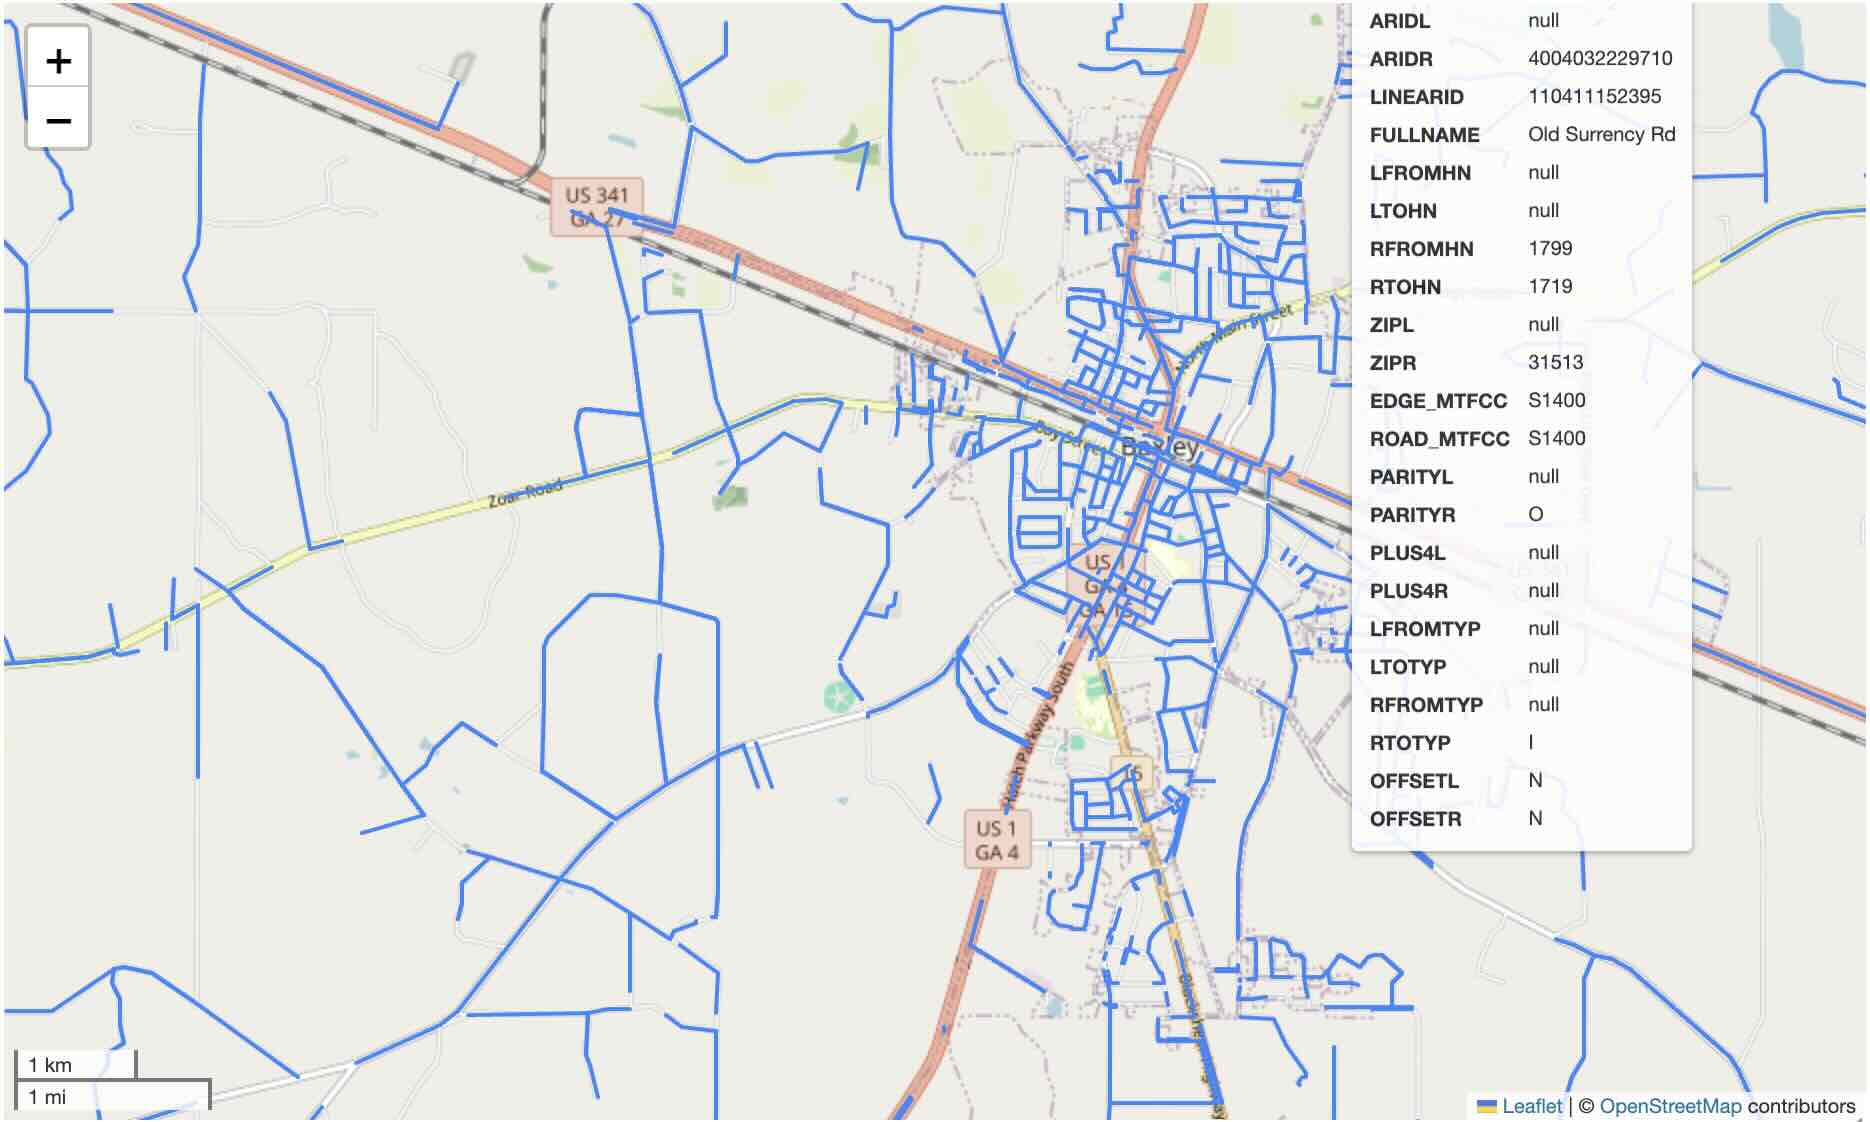

In [0]:
displayHTML("""<img src="data:image/jpg;base64,/9j/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAAB06gAwAEAAAAAQAABGKkBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g/wSUNDX1BST0ZJTEUAAQEAAA/gYXBwbAIQAABtbnRyUkdCIFhZWiAH6QACAAIADgApAARhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAABLxjcHJ0AAAGcAAAACN3dHB0AAAGlAAAABRyWFlaAAAGqAAAABRnWFlaAAAGvAAAABRiWFlaAAAG0AAAABRyVFJDAAAG5AAACAxhYXJnAAAO8AAAACB2Y2d0AAAPEAAAADBuZGluAAAPQAAAAD5tbW9kAAAPgAAAACh2Y2dwAAAPqAAAADhiVFJDAAAG5AAACAxnVFJDAAAG5AAACAxhYWJnAAAO8AAAACBhYWdnAAAO8AAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAnAAAADGhySFIAAAAUAAAB5GtvS1IAAAAMAAAB+G5iTk8AAAASAAACBGlkAAAAAAASAAACFmh1SFUAAAAUAAACKGNzQ1oAAAAWAAACPHNsU0kAAAAUAAACUmRhREsAAAAcAAACZm5sTkwAAAAWAAACgmZpRkkAAAAQAAACmGl0SVQAAAAYAAACqGVzRVMAAAAWAAACwHJvUk8AAAASAAAC1mZyQ0EAAAAWAAAC6GFyAAAAAAAUAAAC/nVrVUEAAAAcAAADEmhlSUwAAAAWAAADLnpoVFcAAAAKAAADRHZpVk4AAAAOAAADTnNrU0sAAAAWAAADXHpoQ04AAAAKAAADRHJ1UlUAAAAkAAADcmVuR0IAAAAUAAADlmZyRlIAAAAWAAADqm1zAAAAAAASAAADwGhpSU4AAAASAAAD0nRoVEgAAAAMAAAD5GNhRVMAAAAYAAAD8GVuQVUAAAAUAAADlmVzWEwAAAASAAAC1mRlREUAAAAQAAAECGVuVVMAAAASAAAEGHB0QlIAAAAYAAAEKnBsUEwAAAASAAAEQmVsR1IAAAAiAAAEVHN2U0UAAAAQAAAEdnRyVFIAAAAUAAAEhnB0UFQAAAAWAAAEmmphSlAAAAAMAAAEsABMAEMARAAgAHUAIABiAG8AagBpzuy37AAgAEwAQwBEAEYAYQByAGcAZQAtAEwAQwBEAEwAQwBEACAAVwBhAHIAbgBhAFMAegDtAG4AZQBzACAATABDAEQAQgBhAHIAZQB2AG4A/QAgAEwAQwBEAEIAYQByAHYAbgBpACAATABDAEQATABDAEQALQBmAGEAcgB2AGUAcwBrAOYAcgBtAEsAbABlAHUAcgBlAG4ALQBMAEMARABWAOQAcgBpAC0ATABDAEQATABDAEQAIABhACAAYwBvAGwAbwByAGkATABDAEQAIABhACAAYwBvAGwAbwByAEwAQwBEACAAYwBvAGwAbwByAEEAQwBMACAAYwBvAHUAbABlAHUAciAPAEwAQwBEACAGRQZEBkgGRgYpBBoEPgQ7BEwEPgRABD4EMgQ4BDkAIABMAEMARCAPAEwAQwBEACAF5gXRBeIF1QXgBdlfaYJyAEwAQwBEAEwAQwBEACAATQDgAHUARgBhAHIAZQBiAG4A/QAgAEwAQwBEBCYEMgQ1BEIEPQQ+BDkAIAQWBBoALQQ0BDgEQQQ/BDsENQQ5AEMAbwBsAG8AdQByACAATABDAEQATABDAEQAIABjAG8AdQBsAGUAdQByAFcAYQByAG4AYQAgAEwAQwBECTAJAgkXCUAJKAAgAEwAQwBEAEwAQwBEACAOKg41AEwAQwBEACAAZQBuACAAYwBvAGwAbwByAEYAYQByAGIALQBMAEMARABDAG8AbABvAHIAIABMAEMARABMAEMARAAgAEMAbwBsAG8AcgBpAGQAbwBLAG8AbABvAHIAIABMAEMARAOIA7MDxwPBA8kDvAO3ACADvwO4A8wDvQO3ACAATABDAEQARgDkAHIAZwAtAEwAQwBEAFIAZQBuAGsAbABpACAATABDAEQATABDAEQAIABhACAAYwBvAHIAZQBzMKsw6TD8AEwAQwBEdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyNQAAWFlaIAAAAAAAAPNRAAEAAAABFsxYWVogAAAAAAAAg98AAD2/////u1hZWiAAAAAAAABKvwAAsTcAAAq5WFlaIAAAAAAAACg4AAARCwAAyLljdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuFAAAUewAAEPXAACwpAAAJmYAAA9cAABQDQAAVDkAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoFD9Ym1iAAAAAAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/bAIQAFhYWFhYWJRYWJTUlJSU1RzU1NTVHWkdHR0dHWm1aWlpaWlptbW1tbW1tbYKCgoKCgpiYmJiYq6urq6urq6urqwEaHBwrKCtLKChLs3ljebOzs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Ozs7Oz/90ABAB1/8AAEQgEYgdOAwEiAAIRAQMRAf/EAaIAAAEFAQEBAQEBAAAAAAAAAAABAgMEBQYHCAkKCxAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6AQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgsRAAIBAgQEAwQHBQQEAAECdwABAgMRBAUhMQYSQVEHYXETIjKBCBRCkaGxwQkjM1LwFWJy0QoWJDThJfEXGBkaJicoKSo1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoKDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uLj5OXm5+jp6vLz9PX29/j5+v/aAAwDAQACEQMRAD8A6wnFN3GlbtTKQDtxo3Gm0UAO3GjcabRQA7cajdpQPk206igCt9qlXh1A+g4qBtRaNsOFx7VfIBGDVSWyik7Y+lMCeO7jkHBAqfdXPyWMsXzJVmB5lUZPPoaANfcaQs3bFVFuR0cY/lVlWVvu0gIWmnTqo/Cm/an6YFWaiaJG7YpWLTXVFd7m6H3Ah/D/AOvUI1KVTiRAKnaB1+5yKgYA8OtVGaWkkJwv8LJ1vWb7u01Ol0rdeKymtlPMZxUZaaPhxuFVyJ/AxXt8SOgD56UbjWNHcDscex6VcW4/vj8qh3WjQ0r/AAl3caNxqNXVuhp1BI7caNxptFADtxo3Gm0UAO3GjcabRQA7caNxptFADtxo3Gm0UAO3GjcabRQA7caNxptFADtxo3Gm0UAO3GjcabRQA7caNxptFADtxo3Gm0UAO3GjcabRQA7caNxptFADtxo3Gm0UAO3GjcabRQA7caNxptFADtxo3Gm0UAO3GjcabRQA7caNxptFADtxo3Gm0UAO3GjcabRQA7caN5ptQXL+XCWoAh+3HcwXHHSrqO5UFsZ9qwrCPzJd57Vu0wHbjRuNNopAO3GjcabRQA7caNxptFADtxo3Gm0UAO3HtVCa6uYTnapWrtNZQwwaqLt0E0RxXYlGV/L0qwHz0rGkt5IH8yH8qtW1wJR6e1XKCtzR2En0Zf3GjcabRWRQ7caNxptFADtxo3Gm0UAO3GjcabRQA7caNxptFADtxo3Gm0UAO3GjcabRQA7caNxptFADtxo3Gm0UAO3GjcabRQA7caNxptFADtxqhcXVzAc7VK/SrtNZFddrDiqi0nqhNdhIbhZk3L+VS7jWI6SWcm9Pu/54q/Hdwyd8H0NXKn1jsJS6MubjRuNNGO1FZFDtxo3Gm0UAO3GjcabRQA7caNxqCWaOFcufwrPa+kk+WFKuNNvYlySNffiq0l9DH3z9Kzxb3U/+tbA/z2qzHYRL97k1fLBbsV29kPGown1H4VIL6A/xCmm0gP8ACKjNjB2GKX7sPeLQuYj0ZaeJQemKzjp8fYkUw6cf4Xo5YdwvLsau/wClLvrI+x3C/dek8u+To2aPZrpIObyNcuQOKpRXkjyPGwHy9Kq7r9eoz+VRWxYXQ3jG6rjT0YnLY3dxo3GokOVp9c5oO3GjcabRQA7caNxptFADtxo3Gm0UAO3GjcabRQA7caNxptFADtxpksjJGzKBkClqOTBjYe1NAR2ty8ybmABzjirW41laf9xh6GtOrqK0rImGw7caNxptFZlDtxo3Gm0UAO3GjcabRQA7cartcMHKgDipu1ZwO4lvWpbLgiwbmQDgCrQc4rPQZkX0q9STCaS2H7jRuNMop3IH7jRuNNoqkA7caNxptFADtxo3Gm0UAO3GjcabRQA7caNxptHSgB240bjUXmLnFPoAduNRecx4QDIp9Uhu3HbTGXGkZR2qaqr/AHatUCCiimSSJDGZH4VRk0APoqvbXUN0heE5AOKqPq1lG7RsTlTg8elAGnRVSC9trlWaJs7RyKj/ALStfs/2nJ2btvTvQBeJxS1lrq1i7Bd+PqKtzXcFu0ayH/WcLj8KALGecUtN706gAooooAKKSloAKKKKACiiigAooooAKM0UlAC5ozSUUCFzRmqEV8kqwMFI87IHttq/QMM0ZoooAKKSloAKTPYUtJgUALRRRQAUUUUAFFFFABRRRQAVG7lSAO9SVDL95aAH7jRuNNFFIB240bjTaKAHbjRuNNooAduNG402igB241AZ3BxgVLVNutUiZE6ztnBAqfcaoVMknY0NAmWdxo3GmjHaipKHbjRuNNooAduNG402igB240bjTaKAHbjTxyKiqRelMD//0OgvJ2g2BVznP6VBb3ZkfZINp7VouAcVl3sOB56cFa1hyv3WiHdao0qQkDrxUNtJ5sIY9aaieexLHgVk1bQtE+9PUUb09RSfZY/U0fZY/U0gF3p6ijenqKT7LH6mj7LH6mgBd6eoo3p6ik+yx+po+yx+poAXcvYimPDG/Uc0ptUxwTTYWJXB7UAV3gkUfL8w9DWaWuYGz0H6V0FNZVYYYZoAy4dR7SD8q0UljfoarSWMTHcvFRsjJ99ce60AaVNKq3BFZ/ntEucggevWp4ryGTvigBzW46px7VAVdPvD8qvgg9KWp5S1NmQ0MT9OD7VF5U0X+rORWs0CN04+lQNC6dORVqpJadA5YvyKCz44YbT7VdjuDjjBFRMqNw4qBrbHMRxT/dy8gtJeZqpMje1TVg+ZLHxIuasR3P8Adb8DQ6cl6EpxehrUVWSfs4qdWVvumoTG1YdRRRTJCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACqN8C0ewd6vVUuPvrQBDp6bFOa0aq2vQ1aoAKKKKACiiigAooooAKKKKACiiigBrLkVkP/o9zv6K3WtmqV1FvQgdeo/CtKUknZ7EyWmhaQ5FPrPspNyAHqOP8K0KmUbOxSd0FFFFSAUUUUAFFFFAEE1wkON3ep6ydR6p+P8AStarlFKKZKerQUUUVBQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAhUMMEcVSksIm+78tXqKqMnHYTSZkfZ7qD/VNke3+FKLi7HHl/oa1qKv2vdE8nYyftN3/zz/Q1ZtLlpiVcYIq7WGWeC6byxk+lXG000kJ3jY3OlZ896E+SLk1XZ7uf5Nu0fTFXYLSOLk8tU8sYfEO7exVitXlPmXH5VpLGqDCjFPoqJTcilFIKKKKgYUUUUAFFFFABRRRQAVkXf7uZJB2/pWvWdepmMn0INaUnaSJmtC7H92pKq2jb4wfYD8qtVDVnYpBRRRSAKKKKACiiigAooooAKKKKAEPSsNI5LmQozdK2JJo4/vnFZlsw+2Er0bNb0rpNozna6Rfgt1gBA71ZoorFu+rNErbBRRRSAKKKKACiiigCKZtsZNUwMCp7g9E9ahPAqJG0FoS24+ZjVqoYF2xjNTUIzluFFFFBItFFFUgCiiimAUUUUAFFFFABTX+7TqMdqAM/pV2M5Wjy19KcAB0qUrCSFqttdckd6s1EFYbielWihrsu3rVyqMkSEZq9igQVh63PthS2Bx5h5+grcrOfTxLe/apmDKBgJigDL02WGDUHt4W3RSD5fqKjtpZIr668qHzcueOmOTWtcaYkkkctuRE0ZzwvX+VSWtj9muJp92fNOcYxjmgDI0/ElxdTMPLbaRs9Kpj/AJAp/wCu39K6EWG27lug/Ei7duOnT/Cqw0giy+x+Z/Huzj2xjFADryCA6ZvZQCqAg+9ZMjM1vp5b1I/AEAVpf2RK4CT3DOg/h+lWLzTRcrCsT+UIenGfT/CgDUorLgsbuKVXkuWdR/Djr+talABRRRQAlFLRQAlFLSUALSUUUALRSUUAFY0duLq6uRKzbVYAKDgdPatmoYoFikkkXOZCCfwGKBGNDJJ5dsrMTiYrn2Ga0JCf7SiXPHltxSnT4TD5OWGG3gjqD7U6KxSOYXBdncDGWPagZlWf+r0/6yf1roqpRWEUSwqpP7jO3p3q7QAUUUUAFITilpMCgAGaWiigAooooAKKKKACiiigAooooAKhl+8tTVDL95aAFFFAopAFFFFABRRRQAUUUUAFVG61bqo/3qqJMhtFFFUQOViKtiqVW0+6KllxHUUUVJQUUUUAFFFFABUi9KjqRelAH//R6tu1VbkZgce1Wm7VDIMoR68ULRh0KennMJHoas2n8X4VS008OPTFXbT+L8KuqrTZMPhRcoooqCgooooAKKKKACqFv3/Cr9ULfv8AhQBZooopAFFFFAFeS2ikHIxWbLpzLzGa2qKAMOA3EbbScfXpWgtwRw4/EdKstGj/AHhmq7W5H+rP4dqALCyI/wB00+sScTxkFV24/u0sWoMvyyCgDYZFbqKrNbkcoafHcxSDg4qxSsUnYziGHysP8Kga3jf7vH0rXIB4NReUmeBinG8fhG2npJGNsni+7yPanpcAdfl+lXSki8449qhZI3+8MGr9pF/GhKDXwMnjueOcEe1WllRvasY27pzGf6U0TOhxIOafs7/A7k81viVjforLjueynPsauLcKeDxWb00ZVuxYopAQelLQSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVK7YIVJ6VdrM1L7goAnsyGTIq5VDT/wDU1foAKKKKACiiigAooooAKKKKACiiigBKa444p9FTYDHT9xdFFHyv0/z+la4ORWZex4UOONlXLeQOgI9K6J6pSIjo7FiiiisSwooooAKKKKAMnUeqfj/StasnUeqfj/StatZfBEiO7CiiisiwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKSkwCspedQ/z6Vq1lR/8AH/8A59K1pbS9CJdDVooorAsWiiiqQBRRRTAKKKKACiiigAooooAKgnTeu31BqemSfd4prQDPsH+XZ6GtOsiH91dOn5Vr1pVXvEw2CiiisigooooAKKKKACiiigAooooAx3QSX2xun/1q0o4IovuDFZxIXUMngf8A2Nafmxf3h+db1L2SXYzhbUkopu9P7woDL2IrGxoOopMjtS0gCiiigAoopjsFXNAypIcyn2phGcLQvTmnxLukz/drM32RdHAAooopnOFFFFAC0UUVSAKKKKYBRRRQAUUUUAFFFFABRRRQAVVdnTP6VaqpIHJPpTQx53bPmq7VV/u1aoEFFFFABRRRQAUUUUAFFFFABRRRQAUmcUtNxzQAuRS0mKTkUAOopuaWgBaKSloAKSlooASloooAKTOKWjFABRTenFOoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACoZfvLU1Qy/eWgBRRQKKQBRRRQAUUUUAFFFFABVR/vVbqCRO4poUkQ0UUVZmFW0+6KqVZjORUsqJJRRRUlhRRRQAUUUUAFSL0qOpF6UAf/0urbtUZ6VI3amUgMqy+W4kT/ADwav2n8X4VQi+W/I9f/ANdX7T+L8K1q73IhsXKKKr3Ujw20ksYyyrkCsyyxXK6VcXEmrTxySMyDdhSTgc+lVf7f1b/ngv8A3w3+NZVpf3VvdvcQoGkfORg8fgKAPSaK5G21vU5Z445IVCsQCdrdPzrrqACqFv3/AAq/VC37/hQBZooopAFFFFABRRRQAUUUUAIQDwaqy2cMnbH0q3RQBli3aEY2gj1705HZfuH8GrSqJ4Y36igCul7HnY/BqyrKwJU5rOm07PzRmqP+kQNtpgdGKjaJG6iqqTyKBvG7/dqyk0bdDj2pDIGt2X7hz9ahYdnWtKkKhhgipt2LU+5jNbIeYzioj50PXkfpWu1up5XioGSRPvDP0rRVZbS1RPJF/DoVI7kD/Z/lV5Lnj5ufpVVoon7YPtVcwyx/Mhz9KaUJfC7CfMviVzbV0boafWCs5U4cYPtV2K5PYg/zpShKO6BWexo0VCk6N7VMMdqkLWCiiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUZkAokOBUCru5NAD/ADealVg1V3AHAqaNcDNAEtFFFABRRRQAUUUUAFZ1+hcKorRqpcffSgBlgNsWDV6qtr92rVABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEMyBl59MVn2jFGaJuq8itbtWPOPIuFlH4/wCfpW1PVOBEtLM2BRUcZ4xUlYlhRSUUrgLRTWZUXc3AFZc128reVb/nVwg5bCckhL9lZlCnOM/0rXrPtrIL88vJ9K0Kuo1ZRXQUV1YUUUVkUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSUtJSYBWVD/x/GtWsqH/j+b8a1pbS9CJdDWpKWkrEsKWkpaaAKKKKYBRRRQAUUUUAFFFRvIF4oAkpD0pisWHTFA3kfNQMy5vkuUkPRsf4VrIcrWVdxkJu/unH51ftm3Rj6VtPWKZnHRtFiiiisSwooooAKKKKACikJCjJpFdWGQaAHUUUUAU5bSKR97ZGfSofsEP95q0qK0VSS0TJ5EZn2CPsx/Kk+wJ2c/lV6S4hiHzMPpVFtQJP7pOB61pGVR7EtQQn2AdnP5UfYD2f9KuW9ws444I7VYqHVqLRjUImV9if+/8ApR9km/v1rUUvbSD2aMn7Lc9BJUbRXAOzfn8a2GIVcmqA5+Y96TryLhSTEXKoA3WrcC4TJ6mqyrvcL2rQHHFZLuay0VhKKKKRkFFFFAC0UUVSAKKKKYBRRRQAUUUUAFFFFABRRRQAVUeRg5UdKt1QkkVJTyKaQEFzPMrbUXIxWzk1nSlT8yMK0qpvbQVgyKr3VyttbtMf4RwP5VZwK57WZC7xWcYLZ+YgdakZoadffbkYkbWU9Paqv9pXbzyQ28AfyyR19OKp20xh1Tc0ZhSbjaf8+tJax3T3119lkEZDnORnuaANO11IzNJFJHskjGcfSoRqz/YftewZD7MfhVWxDJc3Uc/M20/N7f5xVIf8gU/9dv6UAap1W5iUSXFuRGccirF5qRgWFoFDibp29Kiu7q2GmbN6klAAAR1rKnSRbWwTo2Wx7ZIxQBqNqlxbsv2uDYrcZBrbrltQjuomie+cSx7ug4rqaACiiigAooooAKbjHSnUUANBp1IRSDPSgB1FFFABVO9uvs0WUG5yDtH07/QVcrDnF2puJXiDAqVU7gNqY9KALT3cq20BjAMs4XHpyOaWO4njuPs11t+ZdysvHTqKoB2WKxmmXYqELnPYqAD7VZnZbi/iSEhtiPnHbIwKAG/a717c3qKnlDkL32ir73KR24n6hgNo9c9BWXHcwpo5RmAYIU2989OlEcV4rQsYt6xRqFG7GDjn/CgC0l9Iunm6lUF8kYHrnAoE95BJELoIVlO35ex7VmqZTpjFkwqSbuv+1z+VX72aKdraKFgxMqtx6CgB7z3r+a8AVUiJA3Dlsf0pTeyyRwC3Ub5xnnooHX/61Nlktb2N0mYxeWSpGcVDFfOlnAuF82TIXPyrgd/yoAsx3UscskF0ASieYCvcfSoGu72O3F66p5fB2dwp6VYt1hh8y4klEkhGWIxwB2A9KrKwv9sly6pD1WPIyfTd/hQBaee5kuGgtQoCAFmb36AVCNQkFsWZB5qyeVgdN3+FPuLpjMbWBljIA3O3bPQAVFNBaRWG3edoYHeOTu9aAJlnuoZ44rraVl4BXjB9KZcS39ujSs0W0dBg59hVVlkku7ZWnEzA7vlAACjvxVuX9/qMcJ+5Cu8j36D8qAJjczQ26PNGWkI5VB0ptteF9P8Atko6BiQPY1frDt0L6EVXrtb+ZoAlN3exRJdzBPKbGVHVQelbFYd3cRTaYscbAvIEUKOueK3BwMUAFQy/eWpqhl+8tACiigUUgCiiigAooooAKKKKACiiigCq67TTKsyLkVWq0ZtBU8NQVPD3oewRJqKKKg0CiiigAooooAKkXpUdSL0oA//T6tu1Mp7dqZSAyX+S+U+uP8K0LT+L8Kz7z5bhG+n6VoWn8X4VtPaLIj1RcooorIsK4/R/+Qzcf8C/nXYVWis7WGUzRRhXbqRQBZooooAKoW/f8Kv1Qt+/4UAWaKKKQBRRRQAUUUUAFFFFABRRRQAUUUUAFZON98Qen/1q1qybfm9f8a1p7P0Il0LjWw/5Znb7CqsqSIv3R9RWpRWRZgx3s0Rw/wCtX0vEkxg4qxJbRSdRVH7D5bbkwR6GmBpI24U+ssHaeCVPv0qb7X5eBLj8KALLQo3bFV2hdfu8irKSxuPlIqSpsUpNGYwVuHX86rtajrGfwrZZFb7wqu1v3Q/hTjKUfhG+WW6MrfLH/rBke9WI7kdjj2PSpiGXhxUDQRP93j6VfPCXxK3oLlkvhZeS4/vD8qsKyt0NYZjmi+7yPb/ClS4x1+X6U/ZPeOpPMtnobtFUI7k47EVaSZG9qz8iuUlooooJCiiigAooooAKKKKACiiigBvfml+lLSYFABn8KWk5+tJx24oAgkOTingYFRlGVsnke1KzDHFADR8zVaAwKhiXvU9ABRRRQAUUUUAFFFFABVK6YIyselXay9S+6tAFmzIMeRVuqOn/AOoFXqACiiigAooooAKKKKACiiigAooooAKKKKACqd3FvjOPr+VXKawyMU07O4NaWKVnJujHqvB+nar9Y8f7m5MeMK/T+lawYbc9quqtbomD0sLVea5jhHPJ9BVWe9yfLt+/f/CiCzJPmT8n0pqklrMXN0iQBZ7xstwv6fhWnDAkK4UVMFCjApaUql9FsOMbBRRRWZQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAlZVv/AMfrfjWrWVbc3j/j/OtKe0iJdDVoopaxLCiiiqAKKazBBzQGBGelADqKTIpaACiiow4J2igBWJx8tNSPHLdaci7afQMKKKKBFS6TdGyjuM/lVW1ciMEduMVovjGay7T5JHjPb+nFbR1g0Q9JI1lYMMinVCilW4+7U1YmgUUUUCCiiigCOSNZUKN0NZxspozmFv6Vq0VcZuOiE4pmSJrxPlZM49v8KX7Xd/8APP8AQ1q0m0elV7Rfyk8r7mX9ru/+ef6Gm7ryc4A2D8q1to9KWj2iW0Q5PMzY7BRzId38qvLEijCgAegqSiolNvcpRS2Mf/j1vPRTWiZIT/GPzFNntknxnt6VX/s+P1P6f4VreMrXIs1oi550I/jX8xUb3UCfxD8Kr/2dH6n9P8KcLKCMbm5+tTan3H73YrzXnmDai1IjEoCwwaEUDkDFPVd7he1ZTlF6RR0Qi47ssW6YXcepqxQOOKKEZsKKKKBBRRRRYAooooAKKKKACiiigAooooAKKKKACiiigArEKrPcvu6D09uK2HbYhb0FZVmURWZ+5x+VbU9E2iJbpCvYDbwxra21SeaHb99fzq/USlJ7lJJbDcVXFpCLj7Vj95jGc/0q1RUjK89pBc7TMuSnTtj8qIrWCGR5Y1w0nLVYooArfZIPOa42/O4wTntUf9nWnkfZ9nyZ3YyetXaKAM9NLsI23LGOPXJqxNawXDI0q5Mf3e2Py+lWKKAILi2hukEc65AOfT+VTgYGKKKACiim5oAdRTc0uaLALRTc0ZNFgHUU3mjBoAdRTdtG2gB1IQGG0jIPGKTBFGaLAIYozH5RUbMY244x9KbHDDAMRIEz6DFSZFJ1oAgNtbtJ5pjXd64FWaKKAGLGiLsVQF9AOKZHbW8J3RRqp9hipqKAIHtreRt8kasfUgUr28EuPMjVscDIHFTUUAQLa2yZCxKMjBwB0pn2Kz/54p/3yKtUUAV2tLV23PEhJ7kCnpBCiGNEVVPUAcVLRQBFFbwQ/wCqRUz6DFPEaBzIFAY8E06igApqIkahI1CqOgHAp1FAEC21uj+YsahvUAVPRRQAVDL95amqGX7y0AKKKBRSAKKKKACiiigAooooAKKQkKMngCsqS6knPlwDirhBy2E5JFyW6hiO08n2qmbuLPANTQWKr80vJ/SrP2aH+6PyFX7i0ItJmf8AaovertvJG33SKd9lhPG0flVZ9PXrEdtF4PTYLNGhkUtZP+m2/bcPzqWO+To420nSfQpTXU0aKhWeJujCpA6HoRWdih1FJkUtIAqRelR1IvSgD//U6tu1Mp7dqZSAy9RHCH61atHwpOCc46VFqAzED6GpNNOYfwFav4EQviZc8z/Zb8qPM/2W/KpaKzLIvM/2W/KjzP8AZb8qlooAi8z/AGW/KjzP9lvyqWigCLzP9lvyqrb9/wAKv1Qt+/4UAWaKKKQBRRRQAUUUUAFFFFABRRRQAUUUUAFZNlzcO1apOBWXpw5c/StYfBIiW6NWiiisiwooooAayK3DDNUprFZB8px7VfooA55ra4tzlf0q3b3E2PmwcfnWtUDW8bcj5T7UAIlwh4b5frU4IPSqLwyL2Dj361RaeaF/lB2+4oA3cdqgaBG6cfSqkWoI3DjFX1kR/ukGiw07FRopE9xUDJG/3xWrTGjRuopWtsXzdGYzWzDmM0zzZEP7wVqNbkfcP51CQfuuv6cVp7XpNXJ9mvsOxHHc/wB1vzq6twvRuKzmt0blDiods8Xuo/KmoRl8DE218S+43gQelLWIlyP936dKvR3Jxk8j2qJRcfiQKz+Eu0VGsiN3x7VJSAKKKKBBRRRQAUUUUAFJgGlooAhkcQoX9O1UbUSSKXfnnii+fcywL1rQiQRoEHatbWh6kbscowMU6iisiwooooAKKKKACiiigArN1BC+1VrSqpP/AK1PxoAbYjEIFXaq2n+rq1QAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUlFFSBmXsfy+YONlQDz7r5V4UflWnMm8FexH/wCqqdg+Mx+hrqhL3L9jJrUtwWyQjjrVmiisG76s1StsFFFFIAooooAKKKKACiiigAopKKkAooopALRSUtUgCiiimAUUUUAFFFFABRRRQAlZVr/x+Sfj/OtWsqz/AOPl/wAf51pT+GREt0a1FFFZIsKKKKYEboGIPpTioZcdqGGRihcAYFAyLyfQmnIhU9alpKVxDQmGzmnAAdKKKQBS0lFCAWiiiqAQjIxWTJutrjzSMqa16iliWVdpFXCXKxSV0IjBlG0/KelOH7teay4XNu/ky8KentWoMMMNROHL6BF3H7hjPal4pu1du3tTSny7V4qCiSioYmJ+U9qmoEFFFFABRRRQAUUUUAFFFFABRRRQAVVuGziMVZJCjNZ4yxLHvUyNIIXoKsW6YXcepquF3sE7VfHAxSihzfQWiiirMgooooAKKKKACiiigAooooAKKKKACiikpALRRRQAUUUUwILld0LIDjNZ7WjlEjXGR1/GtJ9rHZUayqn+s+WtITa0QnFdTKewnA7V0IFUJLmHH3hWhmnOUnuKKS2Clpuax7u5mj1G3hRsI3UVnYo2qKr3LsltK68FUYj8BWC95cjSo5w53mTGfbmgDpqKwRqDy6XJIDtmjwD+YqG5urkRWmyTYZV+Y/lQB0lFYtvHc+cu67Vxn7oxzUeq3k8cqwWpwQpZselAG9RWWbppNLNzGcNs/Iis5P7Qay+2/accE7SPSgDpD0oHSubuL+5OlR3AO1y+0kdwAakuZbt72K1hk2b0B/nQB0NGBWALi+sbmOK7YSRycA1v0AFFFFABRRRQAUUUUAFFFYuqNeBMoVWIFen3u1AGv16UvIqGfzwmLfbu/wBrp+lU9Nkk+zSNMdzK7Z/CmI0s06sBYppbE3xlYS4LjB4AHbFXnuWNvEYv9bMo2j045P0FIZo0VlWBn+w/KdzgsAW9jTbB7j7VcpckFl2dOgyD0osBr0Vj37XavGQVEXmKOOtaM/2jZi227v8Aa/8ArUAT0Vm6bI32ESSnJBbJ+hrOtZYHRGnmlDN3yQufSgDo6Kz5LeWe4bzWZIVA27TjJ7n8KrW7XU1o8cL5xIUVz12DvQBs0ViwkR36Q20rSLg+YCcgY6VHGr3NtJePMyOC2ADgLjoMUAb1FYM135sFpvZl8zJbZ1+Ue3vV6xMDbvJd2IwCHJyPwNAGhRRRQAVDL95amqCX7y0AOFFIKWkAUUUUAFFFFABRRVO9l8uLC8FuKcY3dkDdkVbmZp38iLpV+CBYU2iobOERxhu7VdrScl8MdiYrqwooorIoKKKKACoZIIpfvqKmopp22CxnnTo/4WIqP+zvRq1KKv2su5PJEyvsEi/dek+y3K/dk/nWtRT9tIXs0ZOb6L/aH51q2ztJCruMH0peKkXheKUp36DUbH//1erbtTKe3amUgKt4ubdvbFRaUcwn2qzcDMDj2qno5/duPQitV8BP2jYooorMoKKKKACiiigAqhb9/wAKv1Qt+/4UAWaKKKQBRRRQAUUUUAFFFFABRRRQAUUUUARynEbH2qjpw+Rj71bueIH+lV9PH7k/WtY/w2Q/iRfooorIsKKKKACiiigAooooAKY8aP8AeGafRQBmS6ch5jpoQxgKwK4/u1q0hAIwaAKKzSIOcMPbrU8dzFJ0OKR7ZG+78v0rLksZYzuSgDdpCARg1hQz3EbBD+tai3PZxj+VADmt1P3ePpUDRyJ1GR7VdVlb7pzTqXKWpNGS0UT9Rg1AbeROYz/StlokbtVdoHX7nIqo1JR0BxhIzVnZThx/Q1biuT0U5+tDAEbXWq7WynmM4qr05eQrTXmjUSdG4PFTAg9KwczRcMMgflU8dyM8Hb7dqHTktVqiVKL02NiiqiXPHzfpVhXVuhrMq1h9FFFMkKazBFLHoKdWffy7UEQ6t/KqhG7sJuyIbQGadpmHArWqvaxeVCF796sVVSV3oKKsgooorMoKKKKACiiigAooooAKo3TiORGPTmr1ZOp9EoAt2ZzCDVuqVh/x7rV2gAooooAKKKKACiiigAooooAKKKKAE4ophT0NNJkXtUgS0VX81h2pPONIVydxlcVlf6q8wvAfp+NXvONULr+CQfw8f4VvQevKTLa5sDkUtRQsGUY9M1LWZYUUUUAFFFFABRRRQAUUUUgEoooqQCiilp2AKKKKpAFFFFABRRRQAUUUUAFFJRU3AWsmz/4+XNatZVl/rnran8MiJbo1qKKKzLCiiigAqBPlkK1PUMincGWmMmpKWkqWIKKKKkAooooAWikpaq4BRRRTAp3UAkXI6jpUFrOf9VJwy8D/AArTrLuoCD5sf3h/StoNNcjIkrao0wcjIpapW04kXPfuKu1k1Z2ZaZAFKyexqekI44pgJRfnpDJKKKbz17UCHUUz588YxTjnHFAC01V296Z+8JGelS0hjG3/AMOKQF/4qkopgJkClpCoNIcBeaAK07g4Rai6CmjBJbpmnAb2CVmbpWRPbpgbz3qzSAYGKWtEYNhRRRQIKKKKACiiigAooooAKKKKACiiigApKKKlgISFHNIGU0Mu4YqLyfSkAsrYGBSxZAyaZ5JqRx8u0cU0hIrguX3r3p0lnHK29ic06DP4DpVmtFJrYbSZnNYwAd61cCq0nSrVDk3uJJLYMCud1SRINRt5W6KM8fWuiowKQzFfVLa6gmhiDZ8tuo9BWTJ/yBIv+uv9DXX4HpS4FAHL6tbNB/pEPCSgK4qG82CGxMgyoXke3FddRgUAc5bXGkJOhhjZW6A9hnj1qG2jvLyea9gKqGJX5vT0/KuowPSl6UAcnAzQW13YS9VGR/n8qkg02CbTRPyJNpPtx7V1GBTcc4oA5GaQy6LFn+GTb+QNWbqZLbU4JpPurGOn0IrpsDpilwKAObllOq3UKwIRHGcliP8APpXSUYAooAKKKKACiiigAo6UnSkA9aADrVLUkZ7QqgJOV4H1FXqWgArNsoW8qZGBXdI/X0NaVFAHPLLcRWRsDC5lwUBA+XB75q4lhKhV45tpVFT7oPAHbNatJgUAZulxTRQHzSepwpGMc/1p9ujC+umKkBvLwexwO1aFFAGdqEbtHHsBOJUPHpV/NOoxQBm2KSJYlQuH+bAYe/FVZ5pLm0+yCBhI2BjGFHvn0rawR0pQaAMS4d3n+zzLJ5KAD5FPznHr6VaaaQWoayiK+WwGwrjK98CtKigDGJ+03ULwRMmw5ZmXbx6VBKke+Tfat5ueNudjeh9K6CigDKXzbGKBTHvRVwxUZIPt7U62DTXr3YQomwINwwSc9cVp0UAFFFFABUMv3lqaoZfvLQAoooFFIAooooAKKKKACsif9/diLstacjiNCx7Cs+wQszTN34ranonIiXRGmBgUtFFYlhRRRQAUUUUAFFFFABRRRQAUUUUAFSL0qOpF6UAf/9bq27Uynt2plIBrDcuKzdHyPNU8Yx/WtSoLRQC5HfFUpWVhNF2msyopZyFA6k8AU6obiETwPATgOMUhkP8AaFh/z8Rf99rR/aFh/wA/EX/fa1hf8IvB/wA9m/IUf8IvB/z2b8hQBvrfWTEKk8ZJ4ADCrVc3B4chgmSYSsdhBxgdq6SgAqhb9/wq/VC37/hQBZooopAFFFFABRTev4UgKnpQA+ik5H/1qMigBaKTIpaACiiigCtecWzfhUdiMQCn3v8Ax7N+H86Sy/491/z3rX/l2R9ot0UUVkWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUARvFG/UVWa3dfuHcPQ1dooAxpWeIZUFT7dKWLUccSD8q1yoYYIqlLYxSdOPpQBYjnikHympqx1tWgJzyPap0kdfuHI9G60AaBVW4Iqu1uOq8e1It0mdr/Kasggjiiw07bFAq6feH5VA0MT9OD7Vr1C0CN04+lJXj8Jd09JIxzDNF9w5HtSrcbeGGD7VoNDIvTkVAyo3DrWntU/4iJVO3wMkjuT2IIFWkmRvask22OYzTPMlj4kGfrT9mn/AA2S5W+NWN+shf8ASbvd/Cv9OlRm5/dkKTk8YqxZlYkww5PNUlyRbZLXM7I06KaGVvumnViWFFFFAgooooAKKKKACiiigArM1BDIUVa06qTf6+P6GgBLEYt1FXKq2f8AqRVqgAooooAKKKKACiiigAooooAKKKKACiiigBpRTUJh9KsUUrBYqmEgVWkTdGye2fyrTqN0G3gU46NNCcSnYvmMD04rQrNV7a3YxJkE9z0rRByOK0qLW4obWFooorMoKKKKACiiigAooooAKKKKVgCiiihAFFFFMAooooAKKKKACkqJpNrYqWpAKKKKQBWVYf61zWrWVYf6x63p/BIh7o1qKKKzLCiiigAooooAYm7+Kn1G4bIK1JQwEopaSoAKKKKACiiigBaKKKsAprLkU6igDGlRraTzUHB6itKGQOoIp0sYZSPwrKQm0l2H7p6Gt/jXmiPhfkbVMcKetKrBhSOFPWsCxc8cCjsBSc4UDinYpgLRRRSAKYzBSB60+oyy7gpoAMvuxjily27GOKfRQBEzODwKqzSuRsxVwkg1SJ3MX7Umy4IaDxzVm3Tjee9VQodgB3rSAwMVMUVN6WFoooqzIKKKKACiiigAooooAKKKKACiiigAooooAKSlpKVgCig8DNRo+7tSsBJVWXPVTUpYn5cU2MDO0j7tUhksa7VAp9FFAiKTpVqqsnSrVMAooppdF4YgUAOopgkjPRh+dOBDDKnI9qAFopu9MbgwwKcCCMjpQAUUm5c7QRkdqCQoyeBQAtNPWlyMbs8U3IOCvI9qEA+imqyt90g49KN6A7SRn0oAdRSFlUZYgCm74wAdwwelAD6KYJYjwGH50+gApCaTPYUoGKAEAp1FFABRRUMs8MAzMwUe9AE1FQw3EE4zC4bHpT0kSQEoc4OPxFAD6KY0iIVDHG44FPoAKKp/2hZb/L81c/p/hVygAooooAKTFLRQA3kUoNLSYoAWim8ilzRYBaKhluIIAPNYLnpmmR3drK2yORSfSgCzRRTEkSTOw52nafYjtQA+oZfvLU1QTcMtADhRSA0ZFIBaKTIoyKAFpM9qOT0pPYUARyxiRDG3eswieybjlTWwBio5ohLGU/KtITto9iZR7DkcOoYd6fWZYyEZgbqOladTOPK7Di7oKKKKkYUUUUAFFFFABRRRQAUUUUAFSL0qOpF6UAf/1+rbtTKe3amUgCobT+L8KmqG0/i/CgC5RRRTAKKKKACiiigAqhb9/wAKv1Qt+/4UAWaKKKQBRRRQAnuKTj0p1FACA46UfgKWigBvHpRx706igBny+9Hy+9PooAp3mPs7de38xS2X/Huv+e9F7/x7t+H8xRZf8e6/j/Otf+XfzI+0W6KKKyLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKheCNu2DU1FAGTPYu3Ktn61TDXNue+K6KmsisMMM0AUobtioLr+VW0lR+hqBrbH+rOPbtVdlZPvrj/AHaANOmsit1FYyX7xnaw4rRiu4ZO+KABrcjlDUBBHysv+FaAIPSjAPBqeUtTMg28Tcjj6VYqw1uh6cfSoWjkT3FEnJ7lR5egzGPu8fSpVnZfvDj2qLI78UtQW0i4sqN7VJWdtFOV5E6cirUiHDsX6KgSdG68VP8ASqM7WCiiigQUUUUAFULp1jmjZunNX6yNU/goAu2X+oFWqqWP/HstW6ACiiigAooooAKKKKAG71HFKCO1QmI54pm1lp2JuWqKrCQipkbcKLDTH0UUUhhRRRQAUHpRUczbIyw7ChAY8US3Ez7jgYzUgM9n7pT7Ff3cj/QCtPaCMGumc7Pl6GUY6XIYbiOYfLwfSrFZstlg74PlNNivGQ+XcDHvUOmnrApStpI1KKRWVhleRS1iWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFISAKCdozVR3LUm7ANY5bNWo/uiqqjJxVoska/MQBUolD6KrJdxSSeUnX9Kn9ifyqnFrcpNdBeKy9O6t+FavAUYrK0/h3H0raC9yXyIe6NaiiisiwooooAKKKKACmIGXhqfUMuRhh2oGTUlIDkZpakQUUUUgCiiigBaKTpSbsdqpAOopu72o3imA6qlxCJF29PT2qzu9KMg8Ypp21QWMu1mMbeQ/Uf5xV6U524qtcW5kG5PvL+opkEhmCg/w9a1kk1zoiOnus0vSnVFvG/bil8wA7cVkWSUUzeBxUUjHcFXikBYqsxAlBPanruX7xqNQGbc35Uxk+8bdwpA+VyBS8BcCoVWQjPSgAkc+XnvVbgDFOcEMB6UxiPyrNmsVoT2ydW7dquVHEuxAtSVSM29QooopkhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBFKrMuFoUMseO9S01iFHNAyHzcDJ6ipk6ZqFQN+0CrFMAooopCIpOlWqqydKtUwCua1jyvtsPnfc2849M10tZF3azS6hBMi5ROp44oApRLpxhna03blibr6YrQ0b/AI8E+p/nWhJEskbR9AwK/nWDAuq2UZto4g4/hagClb/8ge5/3l/mK6PT/wDjyh/3RWYunTRaVJbgbpHIOB9R/QUQPq8ESwrbqQowOR/jQAtv/wAhyf8A3P8A4mrWsf8AIPf6r/OqTQ6jDfyXUEQbcMckY6D39qlnXUbuzlimhCt8u0AjnnnvQBStbh47OWyn4PlFk+hGcVagn+zaIJe+GA+pJxT7zTnnsodg/fRoBj8ORVRrG8ktba0ZNqKSXORxz/hQgG6b5lldRpL924QH/CodVD/2g7x9UCt+WKu3OkGONZLMs0ikYBI6VOLSaW/aaVMRvFtPTqQOKAKWq3P2pIUi6bPMP5VXuMf2baZ6Zb+dWrXTLiOK48xfmKbEGRSzWV39ito0jy8ZJIyOOeKAEthpLToIlkDZGM9OK6Tr0rGSfVmdQ9ugXIycjgfnW3QAgGKWiigAooooAKyrVFnvLiaUZKNsXPYCtWs6S2nina5syvz43K3Q478UAR3iLBdW9xEMMzhDjuD/AIVXiuHggZYgC8k7IuelXEtriWdbi7K/u/uIvT61F9gl8kgMBIJTIh7fjQBFOt2lxbLOyupk4IGMHHStS4jaWB4lOCykCqLQX080Mk2xVibOFzV+eETwtCeAwxQBj7hFa/Zry2KqF27kwR9farsc22W3gibdG0Z57nGMUzZqfleQfLPGN/PT6UhspoRA1qQTCCpDdCDQAtxdyxvcKuMRxhl+tRSXV9Fbrctt+crtQehpTZXUnnvKU3SoFAHQYq3PbPLBFEuMoyE/8BoApy3VzAyW8siK7/MWxwo9B60wajIIp13K7RqGVl6EfSrt1bSPKlxBt3qNuG6EVA1pcywzCQorSDCqvQUADTXsPlTSlSkjKpQDpn3pwlu7qST7MyxpE2zkZyR1/CrFzbvLFEi4+R1Y/QVB9nvLeSQ2mwpId2GzwT9KAAXNzG8H2hQgkyjD0bt+dTQyvNcyqP8AVx4Uf73f8qq3UYh04pPJmRfmDHruHTH8quWUJht1D/fb5m+poAo6kRHcWrlSwBbgDJ6elVriVLiaCJIWibeDuddvA7Cta4t3luIJVxiIkn8R2ovbd50Ty8bkdWGfagCqJb26lk+zssaRNs5GckdaNK8wxzGThvObIHrxTxb3dvLIbXYUkO7DZGCfpUthby20brMQzM5bI96AL1QS/eWp6hl+8tACc0c+gpwopAN59BR+Ap1FACYJ60tFFABRRRQBkj5dQH+e1a1ZUnF8v4Vq1rU+z6EQ6hRRRWRYUUUUAFFFFABRRRQAUUUUAFSL0qOpF6UAf//Q6tu1Mp7dqZSAKr4kibMfINWKKAIfOm/u/pVO4vrmHGEGPoa0qrXUPmxbR17VULX1E9tBVuJWUMF4PtTvOm/u/pVOznx+4k4I6VpUSjyuwRd0Q+dN/d/Sjzpv7v6VNRUjIPNnIxtx+FPiTYvvUlFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFS9/492/D+Yosv8Aj2X8f50Xv/Hu34fzFLZf8ey/j/Otf+XfzI+0WqKKKyLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAopM+lANAC0UUUAFFFFABRRRQBWktIZO2PpWc+nsh3J0raooAzFYr9wkezdKnW52/wCsH4jpVlo0f7wqnLaMy7Ubj0oAuK6P905p9c6Yrm3PGfwq3b3sp+VhnFAGm0aN1FQNbsv3D+dSJcRt1+X2NTj2pWKUmjO5HDDFKMdqvlQRgiqZhy3yce1Tylqa6jCAetCs6fdOaCHThh+VAIPSpNCwk6nhuKsD2rPIB60Kzp93mqUjNw7GhRUCTq3B4qerM7WCsrUEMjIq1q1myNlmcdulAixZjFuoq1UcKbIwtSUAFFFFABRRRQAUUUUAFFFFADDGppETbUlFMLBRRRSAKKKKACqd622Aj1q5WZqLDaq1dNXkiZaIks12wJ/tEn+n9Kv1XhXCKn91RVilN3bHFWQVDJAkgwwqaiknbYZkGK4tTuiO5fT/AOtVyC7jlwvRvSrWKozWaPyvyn26VrzxlpIizXwl+islLma2IjnGR2rQW4hYA7gKiVNoakmTUVCZ4QM7h+dVZNQjXhBn9KFCT2Q3JI0KTIrJ8y8n+6No/KnfZLo9X/Wq9kluyebsjUyKMgVl/YZj1elGnH+/+lHJD+YLvsaHmxjuKabiEfxCqY05e7GnDTou5NHLDuF5dix9qgH8Qpv2y3H8VRiwg96d9ht/Sj92HvCG9t8Y/pVVrmL+HNSvbxK2AtII4x/CPyqb0uwtSATTycRDAoFuW5lbJq1THO1CfQUe16QVhW7lSDiUsvGOlXUJ3jNVLZeN1XVAzSrP3whsXR90Vl2PEritP+EVmWXFw4rSHwyKlujWooorEsKKKKACiiigApCMjFLRQBBFlcqe1TUjLuGOlNKZXbmlYB9FM2fJtzS7Pk25pWAdkUcVD5P+0acsW05zTsA5ulMz5pK9MU7Z84NOUAcimgGmPIxk0zyP9o1PRQMiWLb/ABGlEeDnJqSigRCYudwJrLnMkUu4cKew6VtVWuIhIhFaU5WeopK60II38xQENWNq/czzWfEwtVO/knoBTvtckh/dR1Xsn9nYXOupaB2n5xmn5Od+BinYOzJ61GHYNg9KyLJ1YkAkCmtHk56fSmko+AOMelOfJwFOKAGKd554x6U5Sed2adEhUc09jhc0AUM5YkUxEZiSBTlGBSoxEmBxWa3Nnoi2rvjLDgU9ZFIo3OOoGKT90wxjFaGBJRUGzy+jZz0qT51+8PypAPopoYfSnUAFFFFABRTGdU+8cU0TRnoRTsBLRTQ6npS5FIBaKTIoyKAFooooAKKKKACoJGXoe1TE4GaocucetNDLkXK5NSUgGBilpCCiiigCKTpVqqsnSrVMAoooPSgAopvNLkUWAWiiigAooooAKQ9KWkPSgAHSlpF6UtABSEUtFADeRRmnUUANzRmnUUAHFFNHWnUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEbxRSFTIoYr0yOlSUUUAFFFFABRRRQAVDL95amqGX7y0AKKKBRSAKKKKACiiigAooooAyrji9T8K1aybvi6jP0/nWtWtTaJEd2FFFFZFhRRRQAUUUUAFFFFABRRRQAVIvSo6kXpQB//0erbtTKe3amUgCiiigAooooAz7u23fvY/vCpLS5Eq7G+8KuVkTgQXauOAa2h7y5WQ/d1Rr0UUViWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFO9/wCPdvw/mKdZf8ey/j/Om3v+ob8P5inWX/Hsv4/zrX/l38yPtFqiiisiwooooAKKKKACiiigAooooAKKKKACiiigA6U33NL/ABAUDnmgBOe3FKBilooAKKKKACiiigAooooAKKKKACiiigBCARg1Xa2Q8p8p9qs0UAZzxOv3lBHr3qq87QEbCcehrbqJ4Y5B8wFAFKLUEYYfg1ciKEfKQaz5dNHWI0yOMxDDEg/pTA2CARg1A9uDynFV1mlTrhh7VZjuI3749qVhp22KxDJwwoGD0q+QCMGq7246px7VHKaqfcrkA05XdOnIppyvDCo5JVRaSKdrE014ix8daitv323A4Ws0K871qwkwDaBxV3sY8t9jRoqNJUfp+VSUxBRRRQIKKKKACiiigAooooAKKKKACiiigAooooAKx7v57hYx7frWx2rGTD3uT0H9BW1He/Yie1jWXklvWn0xBhcU+sSwooooAKSlpKlgMaNHG1hxVI6fH2JrQoqozlHYTimZ40+P1NWY7aGP7qip6KbqSe7BRSFooopDCiiigAooooAKKKKAE2g9qYY1PapKSpYEXkrVO9URw8dzitGsy++eSOIf5zWlFXkiJ7EsEBEK/TNSiJhzVkAAYFFZvV3KSE7YrMtBi7kX0z/OtPArLtuLx/xren8MiZbo1qKKKyLCiiigAooooAKKKKACiiigAoopKkBaKKKoBO/0pF6Udmp1ABRRRQAUUUUAFFFFAFZ4YyfmAx/KnkCMjFSkAjFQFkjBaT+GmuwEkjbUyKj3DZucCoWkWS3LQ8+1U1gu5B97HsTWkaffQnm7GiIw2104qG7V0jMinHSs5jcQttZiKvzS+dZsw6cfzqvZ8rXYXPdMns2ZoFLc1JcHERqGx/1C/wCe9PuDwF9axqbsun0IO1Cj5d9ISAKniVTAM9KzibT2LI6UEA9RQMY4pasxIHCqR+lSh3X7w49qhmPKirA6UwE/dv7GmlWj9xSlQaFYp8rdKAFBBHFLTWXZ8y9KcORxSAgmt0nADcY9KqnTk7Ma0aKuNSS0QnFMzP7O9Hpv9nuOj1q0VXtpC9nEyvsU46PR9lux0f8AU1q0Ue2kLkRleVfL0b9aTF+OhrWoo9r5IOQyd2oDt/Kjzb4fw/pWtRR7RfyoOTzMnzrpsIydfatCNVzkdqRsBtx7VKgAHFTKSeyKSsOoooqBhRRRQBFJ0q1VWTpVqmAVVluoYpUt3+8/SrVYF/8A8hW2/D+dAG2zrHGZG6KMn6Cs3+2LD1P5Vcu/+PKb/rm38qwNPe7W2AhtlkXJ+Y4oA2JNTtIQm8n51DDjsadBqVncOIo2+Y9ARism/Zo9UgZE3EIPkH48UxnNxqcHnR+Rtxj3x0oA3Lm+trTAlbk9h1otr62u+IW5HY8GsuyVZtVuGmGWQ/Ln0zj+VF8qw6pbPCMMxAbHpnH8qANNNQtnuPsqn5wSOnpS3V9b2hCzHBYcYFctIHS6nuk/5YzZ/Mml1CT7ZJLcr9yPaq/jQB1AvIBKkGfmkAK8dv8AIp893DbMkcnBk4WuduTMt9amAAv5S4B6d6Lx717m2+2IqYb5dv1FAHQfbbcXP2QnEn/1s097qGOdLZvvuMiucu4Hn1ScRcOihlx7BadFdC71G1k6MFww9xmgDqaKKKACg9KKKAEXpS0UUAFFFY0duLq6uRKzbVYAKDgdPagDZorAhkk8q2VmJxMVz7DNX5GP9pRLnjy24oAdFfpKsDBSPOyB7bavVztn/q9P+sn9a6KgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKhl+8tTVXnZVKliBQA8UVD58H98UfaIB/GKOV9guiaiq/2q3H8QpPtduP4qfI+wros0VV+22/979KT7db+v6U/Zy7BzIt0VS+3Qe/5Un2+D3o9nLsHMive/wCuStasO6nSZlKdq3KuorRjcmO7CiiisSwooooAKKKKACiiigAooooAKkXpUfSlhdZIw69DTsB//9Lq27Uynt2plIAooooAKKKKACs/UEzEH/u1oU1lDLtYcGqhLlaYmrqxDbSCSJT7VYrHUtZTbW+4a2KqpGzuthRYUUUVmUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAU73/UN+H8xTrL/AI9k/H+dNvf9Q34fzFOsv+PZPx/nWv8Ay7+ZH2i1RRRWRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAncGgdcUjdKX+I0ALRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFIVVhgilooAqtbD/AJZnb9Ky5rWdG3j9K3qKAOfS7uIjg8/Wrv251H7xMVckt4pOoqBoJFHGHHvTAYZ2lXjaB71EItw2RjJ9T0/Co5FRRnBBHbtU1teAjGzp6UgBEEQ24xUlWg0UoxxULQMvKVDibRkiIjuOKnCtj7xqvnsRirY6UIJDdp/vGjaf7xokbYm70pscm+PfTJHbT/eNG0/3jVX7WPJ8zFSRSSscOMCgCbaf7xo2n+8aSRiq5UZqBJ2EgjkGN3SgCxtP940bT/eNQ3FwIF96VpwsXmY/AUAS7T/eNG0/3jUdvL50YfGKnoAWJjyp7VLUEX32qeqRDCiiigQxzhc1k2g3PJJ/nmtC6bbE30qpYLhM+p/lW0NINkP4kjUHSiiisSwooooAKSlopWASilopWASiloosAUUUU0AUUUUwCiiigAooooAKKKKLAFZX+t1D2X+latZ1nG4keSQYJrSnZJsmXRGhRS0VlYoSsqDi9YfWtasmLi/I/wA9K1pbP0Il0NaiiisywooooAKKKKACiiigAooooAKSiipAWiiiqAb/AA/WnU3+6KdQAUUUUAFFFFABUJbAG3rU1RALlT3pgM3y+lIQ0g2sOKs0UAYbq9s+5Pu1p2zh1yDT5UDAgjg9ay1LWk20/dPStvjXmR8PoaF3D5sXHVeRWKrsEaMdGxx9K6JSGGRTAkag7VApU6vKrNBKFygrywW0exeTnPtzUDz3DEFk6dOK1ZUyvAqtKfnA9Kl1F1iXGD6Mrxs7g+YMVpIg8sLWWk4eTbj5a09wyBzUSi09rFXutCUAAYFLTR/s0vakSMKAuG9KkqFcO+R2pJs5VRxTGTHpxScMMGmKoTvmmHew3DjFAidDj9234U3GxtvbtVdnkxkLyKikum88RYGOKai3sDdjQooHSmM23FSA+ioiz7sAcVLQAVUuJZYwPLXNW6jVg3bpTjoDRm/a7rp5f6Gk+1Xf9z9DV7enJx0qYsq4z3rXnj/KTyvuZn2q7/ufoaDd3QHMePwNauBVe6ISBj7YoUk3blE4tdSnbz+c/lyd+mK1elYNl/x8p+P8q3qK0VGWgU3dBRRRWJYUUUUARSdKtVVk6VapgFZV/pz3UqTJL5ZQYGB/+qtWkPSgDJj0+6CsstyXVkK4I9Rj1q5ZWv2O3EG7djvjFWh0paAKEtj5t9HebseWMbcfWi7svtM0MwbaYjnp16f4Ve70tAGXdab5s32m3kMUncjvRa6b5U32m4kMsnYntWpSUAZa6aF+07nyLj26dahXRwLI2ofktuLY/pWyBTqAM06fm6hud/8AqlC4x1xT7yy+1SQybtvlHOMden+FX6KAKKWWy/e93ffXG3H0/wAKgGlot8LyNtoznbitWigAooooAKKKKACiiigAqGKBYpJJFzmQgn8BipqKAKB0+Ew+Tlhht4I6g+1OisUjmFwXZ3Axlj2q7RQBSisIolhVSf3GdvTvV2iigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKpXkCzbAe2elXahl+8tCdtgsZ40+PHenCwi96viir9pLuTyLsURYw+n6077DB/d/WrlFL2ku4+Vdip9it/wC7S/Y7f+7Vqijnl3DlXYrfZIP7opfssH90flViilzPuHKjGvY0j2BAB16fhWzWVqPVPx/pWqK0n8ESY7sKKKKxLCiiigAooooAKKKKACiiigAp8ahECrwKZUi9KYH/0+rbtTKe3amUgCiiigAooooAKKKKAM3UV+RT71eiO6NT7VVvxmH6GprU5t0+lav+GiF8RYooorIsKKKKACiiigAooooAKKKKACiiigAooooAp3v+ob8P5inWX/Hsv4/zpt7/AKhvw/mKdZf8ey/j/Otf+XfzI+0WqKKKyLCiiigAooooAKKKKACiiigAooooAKKTIoz7UAI3Sl/iox/eIo5zkUwFopM/hRkUgFopMijIoAWiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAGsisMMM1VNoF5iOPbtVyigDMZGT76491qI3jQtt6itiq8lrFJ1GKAK/wBphnXjrVkdKofYfJcOp4FXx0pFrYinGYjiooGX7P1q1jIxVU2iZ4JA9B0pDK9vEstqFbipI5JIpVgfkHpVloFKbF+UD0psdusZ3Z3H3oAmbpjpWaQ0Vwpc7s9K0JI/MGM4+lRJbKjbidxHTNAGZLLuDO6Nntx0rSgYPBnGOKlPlyjZkH6U8KAu0dKLBcq2P+oFXKjjjWJdq9KkoASL77VPUEX32qemiWFFFFMkz79v3WPcCpLNcRKPQZ/Oql+fmVRWlEoVRjsAPyrZ6U0iF8RLRRRWJYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWSnGof59K1qybn9zdrL2P8A+qtaXVeRE+hrUUDpRWRYUUUUAFFFFABRRRQAUUUUAFFFFKwBTW6U6k7gUwD+KlpB1zS0AFFFFABRRRQAVCFGVNTVXBjVgSwB9KaAsUU0Mp6EUuRSAWqk8AkXYeP7tWsiomlhPBdfzFVG61QOxRsZmwUPQYrTwDWLMBHJ5kJHuBVhL9FGGBrWdO/vRRnGVtGadZ0pIkbFI2oJ/CDVb7SMlvWs3Sl2NYTihLQZYj6Vt9qxbH/W1t06vxsmHwopGQwxtIOdtVFvJ2+6gI9hV4R71ZG6Gqdk5RmibirhblehMt0W88fKCKbLLHHtMmamBd1wvWs6+BGwHrz/AEqKcU5JMqTstCWeWaOX92mR64pgurv/AJ5/oa1cCmKhDEnpTU1b4Rcr7md9qu/+ef6GqkryllkZduOnGK38Cs69X93x/CRWlOavaxEo6bka3V1jiPj6Gg3dz3jH5GrtsQ0S/Sp9qntUOcVpylKL7mSb24/uD8jQb+cdVA/CtTyo/wC6KzNQULs2jHX+lVBxk7copJpXuBvpscpinrqA7rWiFGOlIUj/AIgKjmh/KOz7lH7bCVIwc1G16jY46VHMqLdqABtOOP0q75EbfdQDHtVtQVtBLmGf2hF6H8qq3V0syBVHetP7NB/cH5VE9nDIBgbfpxSjKmnewNSsU7aHy5VkLLgdgeelbFZptI4fmBORV9PuipqSu7lQVkPooorIoKKKKAIpOlWqqydKtUwCkPSlrNub1obyK1CgiTv6UIDSHSiqd3Ncwhfs8XmZ6+1ZkWqXs+RFbhtvB56UAbo606si41F0uPstrH5kg6+gp1tqLtP9luo/KkPT0NAGrRWfaXrXFxNAVAERx+uKat8xv5LPaMIuc/gKANKisnTtTF6xjdQjDke4qezvDczTxFQPKOB+v+FAF+iiigAooooAKKKKACiiigAooooAKKKrSXlrESJJACOMUAWaKiE8JCMGGH4X3pxkQOIyfmIyB7CgB9FZFvezSJalsfviwbj06Vr0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFN606gAqGX7y1NUMv3loAUUUCikAUUUUAFFFFABRRRQBlaj1T8f6VqDpUE1uk+N38NWBxVykuVIlLVhRRRUFBRRRQAUUUUAFFJkCk3L60AOopu9fUUbxSuA6pF6VX8z2NTocqD0ppoD//U6tu1Mp7dqZSAKKKKACiiigAqOSRY13NwBTzxVGa1eWYFm+X0qopdRPyKxaa9bavyoK1IoxFGI16ClRFjXagwKfVTnfRbCjGwUUUVmUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAU73/UN+H8xTrL/AI9l/H+dNvv9QfwpbMf6Ota/8uyPtFuik5//AFUmfasix1FJn2oz7UALRSZ9qTPtQA6im59qXmgBaKTnuRSfLQAufSk578UvP0+lGBQAn0FLg+tLRQAm0UY9OKWigBvTrzRx2FOooAbz6Cj6j8qdRQA3p0pRyKMCloAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKTPpS00AjgUARy/cpB0pZR8nWkHSkWthazrl5opQVbg9B/wDWrRrPnwt1GzdKqMuUTjfQYl4+4B8AVZmuVSPenP0qrdjndgEVXKESFY+dtaWhLbQn3o7mxE4kQOKbK7rgIMk1n21x5I8txx/Krz3MSpuBz9KzlTcdyoyT2MoRSbiqjlaeJ54uMn6Gr9unJlb7zVHJ++uBGOi9a1Vf+ZGfsv5RqX399fyqylzC/fH1qN7KJvu/LWeiRl8M+B9KtQpyWhPNOO5sxugY5PWrAIPSsEwsD+6YNS+bPH14FZ+y/lZfN3RvUdqyUviODVkXaOML1qHBrdDVnsU5TvukU/w4/wAa1kGFxWTGN927DtnH8q2R0rSrpZEQ7hRRRWJYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVG/TdFuH8NXqZIgdCh7jFVB2aYmrqxFayeZCp9OKsVl2DFWaE1qU6kbSsEXdBRRRUDCiiigAooooAKKKKACiiigApP4hS031oAF6U6gUUAFFFFABRRRQAVlSQCWX0z6Vq1TXcsuMcGqi2tgaTKhsHB+RqhlWe3xlutbtZepf8s/x/pW9Oo5SSZlKKSujRBBHSsR4M3Jhj/DP0zW4n3ayx/wAhH/P92pou17diprYj+wTjutRwqFl8qQD0Fb1Zd7D/AMtF7fyqo1XL3ZEuFtUWxbwbchB+VUgke3O0flViCcPFk9elRgALzXNNyTsdFNJoW2QbhgdK0apWuNzYq7SQSIssG5wFrKuB5dwJB0Na8mNtUbpA9vuX+GtqTszKa0LqAquB0qrdW3mqNvUdKfayhoAT/Dx+VK93Anf8qSUlLQHZrUjjSZUCk9KmjVgfnJqm2oE8RJmk+23A+9H+lV7KTFzrY0vl96q3YX7O+OvFV/7RI6pTXvUkG1lxkEU40pJp2ByjaxJal/KG2iSO7Z8q2B9cVBa3KwrtbPXtVv8AtCH0P5VTjJSbSEmmkmQeRe/3/wBTTTaXLkb2zVn+0IPRqcL+A+o/Ci9RdBWj3Lg4FQz9BTPtlv8A3v0p3nW8g+8Kw5WuhrdGddhVdGX/ADirYuo3HykD9KeY7V+pU/lUbWNuehI+la3i0lIizTuif7TDj7wp/mJxg5+lUxp8Ocbj+lWI4Y0UAdqiSj0KV+oTfMKli+4Kq3Uvk7SBuzVqE7owalx0THfoSUUUVIBRRRQBFJ0q1VWTpVqmAVz2osq6pbMxAAH9a6GqdzY2t0Q867iBgckfyoQE6TwudqOrH0BFY2i/euf94f1rQt9PtLdxLCmGHHU1NBawW24wrjfyaAMOzkS21S4Wf5S5+UnjjOaddyJc6nbJAdxQgkj0zWxcWVtdY85MkdD0ot7K2tP9QmCe9AHP29tLcX10IpTFtc/d78mpLSJodVljdy5CfeP0Fb0VrBBI8sa4aTlqBaQCdrkL87DBPtQBytrA4svt0H+shc/984FaWiP5s1zJjG4g4+ua2YLaG2jMUK4UnOOtNt7O3tdxgXbu6/hQBZooooAKKKKACiiigAooooAKKKKACsu0jQ3l0xAJ3AfhitSmqiKSygAt1x3oA56MrHDbk8KtwR7DrV4yxyapGqEHbGc4rQMEJQxlF2ntjihLeCLBjRVx0wKAMKz/ANXp/wBZP610VRLBCoUKijZ93A6fSpaACiiigAooooAKKKKACiiigAooooAKaadTT1oQDqKKKACoZfvLU1Qy/eWgBRRQKKQBSZFBFIMZwQKAHUUi9KWgAooooAKKKQkDrQAtHAqFpMDPCj34qlJeRj7mWP6U4py+FCbSNAuB05+lRtMAOy/Xis8fa5v+mY/KnCyQffYt9KfKl8UieZ9EStexjgnP+7Vf7VK/+qUn9f5VcW2iX7iD8asAP04H0o5oLaI7SM3fetwE/SjZft/CB+VaXln+8aTy/wDaNHP2ig5PMzvIvD1IFH2a57yj860wg70uxPSj2kuiQciMz7Ex+9KK1LaPyoVjznHem+WnoKnQAKAKHOT0YKKWx//V6tu1MpzkAgU2kAUUUUAFFFIfQUAJ7+lKKT27CnUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBQ1A4hH1qe2A+zoPaq2o/cUe9XIRiJR6AVq/4aIXxEmPTijB9aWisixOaTB9adRQA3B9aXB9aWigBMH1ox70tFACYFLRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUARTf6umjpUrLuGKh2SDgYpFIdUckSSDDCnbZfajbL7UDKwtE7kn2qdIlj5HenbZfajbL7UhkT28ch3MKz7i3EOGU8Vq7ZfaoLmOQwtnHHP5VtSm00uhnOKaCGJQA4J5FSpGqEsOpqvaF3hAXHy8Va2y+1ZyVnYqLuh1QPbQv1X8qWRpIx93P0qob4DgjFCbWwNIje12sfLJ4pn+kR9avwXMZGTxmre2KTng1p7SXUnlj0MMyKf9Yn5cUmyI/dbH1rYa2Rv8KqPZ98D8KtVUvIlwIYImTJz19Ksq7qflOfrUYGxdoBGPWnAgDP8AKuecuZ3OiMUlYsrcY4YflU6yI3Q1ngY5oHXjipuHIjTorPWV14U5qws6nhuKq5DgyxRSAg9KWmQFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGTJ+4vQ3QNWsKqXdv5ygr95elUkubiFdrpnHrW9udKxnflZsUVmDUR/EuKmW/gPXIqHSkuhXOi7RUSzwt91hUgIPSotYoWiiikAUlLSVLAKWkpaaAKb2+tOpvZaYDqKKKACiiigAooooAQ9KjG7eARxUh6Ud6AFrL1L/AJZ/j/StSq89us+3d/DV05KMk2TJXViVCCtZh3C93gcf/WxWkqBaftXrilGVhtXIN8jdBinSx7wPapqKQzOEESRt5R9OtV/OVW2NWg+yMEMOvSsh1Xzyp6f/AFquKU2+bsF+VLlNKJeCU4q6OlUbf5oQicYq4MfSs7dhscRxiqygcxN0NSuWUcc/SowqKcucfWmhFFbCTHzMAParSWMC9efrSXVwYNuzB3f0qr5952Q/lXR78le5l7q0saqxogwqgU7avpWR5l8egP5U4NqBGR/So9k+6K512NTavpUbxJj7o/Ks3F/70eVfH+I/nR7O32g5vI0ZIINm4Iv5Ck+zwY+6v5Cs7fc27K0hLL6Z4rUWSNwCvQ9KUk1rcItPoZflob3y8fL6fhV77Fb/AN2qtxHLHP8AaIxx/wDWxViC9jk+V/lP6VpLmsnElW2YjWEJ6ZFM/s6PsTV8Mp6GlyKy9pLuXyR7GX/Zx7N+lNOnyj7rCtfikJAGTVe2mL2cTD2zwyiJW5Poa2/wFZdoDLO0x6f5/pWtTrPVIKa0KV6FNueOmMU+yObZabe/8e7fh/Olsj/o6j6/zqf+XYfaLdFFFZFhRRRQBFJ92rVVZOlWqYBRRRQAgpaKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApvejrTulABRRRQAVDL95amqGX7y0AKKKBRSAKT+IUtIaAAUtJ3paACjpTC4HA5qpNcJH985b+6KFrogbsWS/93oO/aqEl0M7IRvb/PSo9s91y/yJ2FXYbdUHyDHv3q7Rj8Wr7EXb2KYtpJPmuG/AdauR26p91QPfvVkKB0p1Jzk9ylFIYIx35pwAHSloqbDCiiigAooooAKKKKACpF6VHUi9KAP/1tvUfMXy5U/hz/Sn21ysy46MO1XJACMHpWJPA9q/mxfd/lW0bSXKQ7rU2aKgt51mTI69xU/SsWraFoOlN6c/lR7n8qUDuaQABiloooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiikYhRk0AZeoHcyRjrWoowAKyrZfPuWlPRen9K1q2qaJR7EQ7hRRRWJYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUU0sBxQA6iiigAooooAKKKKACiiigApCARg9KWigDJsTslaE/5xWrWVJ+5vQRwG/8A1Vq1pW3UiIdhagkt4pByKnorMszfI8v5EKn2am/dPdT+lQyxmW7MYOM/4U8x3kIx99fzrf2SstSOfyHrfhW2SfpV9Jo5B8prEYxSHDrsPt0pWtZ4Dlf0rOUHHcpNPY3ioPBFQtboenH0qqkkijgg+x61ZS4Q8N8v1qLFJ2IXt3AwvSq+HX/69aoIPSgqrcEVNi1MylAbpxThnp1FXGt1PK8e1VjHJGOn5UrFJoTJU/Kce1TrcEcOPyqsv+11oxk57UkNpGkrq33TTqyUkVjiPirKzuvDdKvbRmfL1RdopiOrjin0yQooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSYBpaKAGGNCOQKprawyE5H5VePApqbcZWqUmtgsii2nofuHFQPb3FuN0bZA9K2KKtVZdSeRFO1uhMNrcMKuVlXNsUPnQ9uwqza3QmG1uGFEoK3NHYUX0ZcpKWisbFhRRRQgEbpR3x6UHnijuTTAWiiigAooooAKKKKAEbpR3pG6U7vQAUUUUAFFFFAB0rLe+k8wrCoIFaLLkg+lZViMTshHQfyramlZtkS6JDXnuH+8n6U8DdtZlwat3AG9cVWaQZwMVlKV9kbQjbdl63GIxU9VYixPHQVMchhzxSsSx20duKqzW6zHBPIq5UEfLlqadtUKxkXNuYMDOQelbidKzNR/g/H+lai9K2qO8YtkRVm0hajLKudxAqSsi/OZFQVnTjzOxUnZGvRRRUDM2WTfcG3IG3/62aqpKbVzG3K1Mf8AkI/5/u0k4H20Z74rrjZe70sYvuXYriOQYHPt3pj2sMuWPB9RUElmPvR/Kf0pgnngGyZcr6//AF6hR602U30khxsGHKPVq3jkiBEp3Z6U+OZXHynIp4kjbAVgfpUSnJqzKUUth/HpVO+fbBgdzir1ZOotl1T0FFJXkgnoiOG3uSgMbbQe3SpPs95/z0/U1pxrsRU9BimPPFHw5xVe1beiJ5EkZzW12w2s+R9TV20UpGIz2qN76DGBk/QU+2cPll6UpuXLqhxUehbooorEsKKKKAIpOlWqqydKtUwCsPUZbkXsNvBJ5YcVuVzupxrNqVvE/Rhj9aAB5r2yu4Ynl80SHGMfhRLLdyajJbRz+UqjIz06Co7i1j068t5Yfus2DnnHT+lKLaK61maOYZULn09PSgCWc3lrZvIbjzDlQCO1Ry/2hBaLefac5Cnbj1qfUraG105o4RgFgaqz6ZAunC5jzvCK3t2oAt3GozC2gEQxLOB+FRTrqdhH9pM3mAY3KelR3Alkt7TUIxuMYG4D2/8A1U681JLyD7LaozPJjjHSgBNSv5wIZLZiokTOBVm5v2/sxJ4jiSTCjHr3/lVWaDyrmxt25wMGq9pbyG/Fm/3IGLfyx/SgCeK8uTpUs5c71cAH24q+b1P7O3CVfN8v1Gc49Kxof+QLN/10H9KvHT7T+zPtGz5/KDZ98UARTXl0NNglVzvZiCfxqzLqDy6WZ4jtkUhWx2NZ7/8AIMtP98/zp+r2zWztJFxHN94e4oA6W3Ytbxs3UqD+lTVBa/8AHtF/uL/Kp6ACiiigAooooAKyNTa8WPKFViBXp97tWvVDUkZ7QqgJOV4H1FAFieATgAsyY/unFZlsjedJPE7tFECoDHO5h/StK7Z0tpGiBLbeMUlpF5FrHEBghR+dAGRhzYf2h57eZjd1+X6YqcO19ciNnKJ5SuFU4zn/AAqm8SOjRi1ZZ2yMc7Bnv6VcuIo42ijmhLoiBQ6ZyCO3HagCfT5W3zWxbeIWABPXB7fhWlWZpsHl+bNs8sSEbV9AowK06ACiiigAooooAKKKQnFAC9Kb1oA9adQAUUUUAFFFFABUMv3lqaoZfvLQAoooFFIApD0pelRlx0HT17UAOJAY5qF5Qq5Y7VqrNdoGxEN7fpUa27yNvuDn2quTrPRE83SIhnlmOy3GB6/56VLDaqpyfmb9KtpEFAGMD0FTgAcChz0tHRAo9WMVAOvNPooqbFBRRRQAUUUUAFFFFABRRRQAUUUUAFSL0qOpF6UAf//X6tu1RkBhg9KkbtTKQGNLG9nKJIvu/wCeK0YZkmTeO3apXRXXaw4rM0/hnH0re/NG73Rnbldkao9TS0UVgaBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFUL6TbHsHVuPwq/WQB9pu8fwr/StaS1u+hM9rF60i8qEDueTVmiis27u5SVtAooopAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFQSr/ABCp6McYoArJLjg1OHU1UdCDTeRUXJuX6KqIz9qtDOOapFIWiiimAUUUUAFFFFAGZqC8JIO3FX4m3xq3qKiu03wMPT+lRWL7odv93itXrTXkRtIvUUlLWKLIwq8NgZqSm9qd0qgGlEY5IBxTqqveQIduc/SrGcdqbTW4JroRtBG3IGD7VUlglC4GG+taNFSBzyy3Nuec4q/Dfq/yuOfar7Ro4wwzVM2Sq2+Pr6UAXFkR/umn1mFSh+YbT/s9KDdNDjcQRQBeaFG7YqnNE0SEr0AqzHdRSDg4qO9YC3PvgU4xu0huVkZ0AIUsKsYyN3SrFpGvkLuFPe2H8P5dqKusmOm0opFMbl5H6VZW4Zfv9KiaOVB0/Km5GPm61ma2TNBZUbpUlZZHQrUgkePvn607kOHY0KKrpcKeDxU4IPSqItYWiiigQUUUUAFFFFABRSEgdaWgAooooAKKKKACiiigBrYA5oXGPl6UMAVwaVQAMCgBaKKKACsq5tjGfOh4+latGKqEuXYTjcp2tyJhtbhhVysq5tjGfOh4x2FWba6WZdrcMKuUFbmjsTF9GXKTPYUnX2FHsOBWRYdOBTgMUg4paVwCiiimAUUUUAFFFFADTzxS96hdyjVMOlMBaKQkAc00t8uVpAPppdR1NNwWTng00Qr35oGKW3jalZQ/c3uD6/zrZCqvQYrJ1BQHVvUY/KtqO/KZz2uWZj8x9hWXHF5ils1fnPMn0qG1HygepqYScYNo0lFNpMPIvI/udPY00y3Y5dSce3FbY6UVXte6M+TszIGoPjDKPwqSK9iUYYHNaDRRsMMoNV2tbYnJGPpxRzU+wWkupQvZo5dvlnOM/wBK2QRjis77DCQSCRio/sk8fMT/ANKp8jSSewlda2Nasi5+a8VfTAoM93B/rBke/wD9aooWM90Hbj/6wpwpuPvClK+huUU3iqlrcPPu3YG3FYKOlzW/QrH/AJCP+f7tF1xdxn6fzpsjiO+LN0H+FNupY5JEZDkCupLVehj0ZtdqiZA0e3tTwwI4o/hrkNjLezZDuhOCO1VIofMYpnaRW+QGFZVyrQzCdR9a6KdRv3TKUEtRBDeR/wCrOR7Gmok8lwplB6jtxxV+KZJB8n5elWu+PSp9q1uh8i6DJHESFz2rJghN27SScCpb2QyOsCVoQxiKMIO1C9yN+rD4mUp7SGOFmUcgU+wA8rNWbgZgce1VNP8A9WfrSu3DUdrS0NGiiisSwooooAik6VaqrJ0q1TAKMUUUAHFGBRRQAUUUUAFIFUdBS0UAGKKKKADAooooAMCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApp606mmhAOooooAKKKKACiiigAqGX7y1NUExAK5oAcKYXApo3P04FSBVQZrNy7DGBWblqzGW5nO1vkQdq0y5PCUoQdTzVU5NapEuNytDbqg+QY9+9WlUL0p1FPzY0rbBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVIvSo6kXpQB/9Dq27Uynt2plIBDWXY/65xWoelZdpxdyD6/zrWHwyIlujVooorIsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCC5JWBivXFVtPVRGWHU1eZQylT0NZlkTHM0B/zito/A0iH8SNWiiisSwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKADApNq+lLRQAgAHSlqGXjGKSMtTsK/QnooopDCiiigAooooAQgEYNZVkfLmaI/5xWtWTL+5vQw6HH+Fa09U4kS6M1aWiisbFlGe7WImNRlv0qt5d3cffO1fT/wCtSycX4/z2rVAxXQ2oJWRmlfcqQ2ccfJGT61ax706isXJvc0SS2Kh3hqnV88YpFcd6eNvapQkOpKWkoYwIBGDVWWzik7Y+lWqKQGHJYSx/MlQsZdgWTP0ro6haKN87gOK1hKzTFJXViCGYIgRhjAxntVtWVvunNVDbuB8pz7HpWdL9oik3KMD26VIzeqJoUbtisyLUSOJBWkk8bjg0rDRXe3cD5elV/mX7w/Otamsit94VNi1MzOX6dqFdk6f/AFqttb90NVijJwwpFpplhLjj5x+VWFdW6Gs4cjHSjgDK8fSi4nFGpRVFZnUc9KsJOje31qrmbi0TUUUUySvMMstSBSi/LzQxTqakpjGBsLluKcCCOKCARg03bhdq8UgH0VHkonNKsit0oEPooooAY4UjBp46VBN1UVOOlAwooooEFFFFABisya0IkDw8Vp01unFVGTjsJpMQc9fyp1Rpn+LvUlZsYUUUUgClpKWmgCiiiqAKKKbuzkLQBWmVjk9qmUl0+XikQHb83enlkjHzELTAAuVw1OAAGBTPOh/vr+YpwZT0IosA6ikyKWkAVRu7Z5tuzHFXqKqMuV3QNXVjAlSZM72zUtswCf7pqS+GM+5H8qqxfJJsbv8A5Fbtc1MiLUZm+OlLUULbowalrmNBrHAzVQnNXcUwopoM5RuRx/cNT1GBhSBUlBaWghUMMEVkBFjv9iDAH+FbFZLf8hH/AD/dral19CJ9DUPSsvTh9/8ACtQ/drN03+P8KUPgl8gfxIuvDE4JZRmsq7gSErs7/wD1q2ezVmah1T8f6VVGT5khTSsOOnkco9V8XCy+QrnP6dK3O1ZI/wCQj/n+7VQqN3v2FKKVrBsv16GkP27+IZ/Kteis/a+SK5PM5/bPC3mBduPyqyuoMB8y84q1dDEEv4fzFMs0V4ArDI/+vWrmnHmkiVFp2RStpI1k8yY81rLcwt0YfyqM2UB/hx9KiOnR4+UkVMnCWo0pItuVeM4IPFZ+n9/rSHT5B91hSWAIkZfSjlSg+Vhd8yujXooornNBCcUm4UNUZIHWmMWT7tWqoMWccDAq/wAUkIKaXRfvEClrm9XMX2+AT/6vb830z7UwOjV0b7pB+lN82L+8v5iuWAtvt0A0wnr83XGPx9qfqljb2ojMWRubB5oA6hWRvukH6Unmxbtm4Z9M1h3scemWjG1yplIXOfrSjR4Psmcnzdud2e/+FAG6WVRliBQSoGScCuRnuXuNIQuclJduf+Amp73VYJrI26K4Yheo44xQB029Bjkc9KUsqjLEAVyd6DJa2KL1ZcD/AMdpbq7NxpoSTiWNwrD8DQB1lFMT/Vr9BT6ACiiigAoo4ooAKKKKACiiigApruka7nIUU6sbVbcGLzy7cFcLn5eoHSgDVklihAMrBc9M8UxLm3kbZHIrH0BFPkSJh+8AIHrWdYRJK7X20KD8sYAxhR3/ABoA0y6KyoSAW6D6U2SaKEZlYL9eKyXtxDqds+9nLb/vHOML2p0zQw6iZLsfIUAQkcD1FAGsjo6hkIIPcU6sfTHVprlIhtjDAqOnUf8A1q2KACiiigAooooAKQ9KWigBB0paatOoAKKKKACiiigAqCVQWXNT1WnBJUDjrUvYBxcLwKbtZuW/KnKoWnVKiAgAAwKWiirAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqRelR1IvSgD//0erbtTKe3amUgEPSsu34vXH1rVrKi/4/zWtPZ+hEuhq0UUVkWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVk3YMNwsw6f4VrVUvI98JP8Ad5rSk7SJmtC0pBAIpap2Um+ED+7xVyokrOxSd0FFFFIAooooAKKKKACiiigAooooAKKKTIoAWikz7UZFAC0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACEA9aUADpRRQAUUUUAFFFFABRRRQAVm6gnyq47VpVXuk3wMParpu0kKS0JIW3xq/qKkqjYPuh2/3avUpqzsEXdGVccXqe+K1RWXecXMTfT+daS9KufwxJjux1FFFZFlJlOelSQ9as0gUDkVNhWFpKWkpsYUUUVIC03s1OpvY1aAdSFQwwRS0UAUpbGJ+Rx9KiMTRjDLx6r1rSooAzVkdBlW49G61LFexPweDU7wRv1FZsunEcxGgDXBBHFLgHisCP7TE4U8D9K0luHX74z/u0ATNbo3Tj6VXMLoOOlW0lR+hqSlYpSaMg7hwaduzwBWi0SN1FVjbFeUOfrSsaKSIFkZD1/DtU4nLEZqArz8woXHQdKVx2RdVIz0OanrOAx904+lSrO6/fHHtT5iHDsXKKjWVG6VJVEBVfAE3FWKY3HIHNAD6KbuAAzxTqBELqS6+1TUzLbsdqfQMKKKKBBRRRQAUUUUAVi+xwG/CrFZ+oJ8gcdqtW7+ZCrVUo+6pCvrYmooorIYUUUtABR0oqB9zNsHSrAcJNzbR0p4UL0oVQgwKdQMb2WoJrdJ/v5G30qYc49qyZw8t0YgcD9OlaU1d6aESdkKbOMceaB+VKLHIysgP0p407+835U06e4HysK35/wC9+Bny+Q37BMOjCopEuLcAluvpUvlXseNpJ+hqCWWd/wBzLyfTFXG76oTsuhtxNvQN6gVJWPDdtAojdOlXEvYX4+79a5pUpLoaqaKl98zIo71DcrhhIv0/KpZCHuoh6Y/nSyplWX8qvm5eQSV+Ys2z9ux6VerEt3+XjqvT6VsqQygisJR5W4ml7pSHUUUUhDf71OpKB0oAWslv+Qh/n+7WtWSf+Qj/AJ/u1rS6+hE+hqN92s3Tf4/wrSb7tZum/wAf4UQ+CXyB/EjS/vVl6j1T8f6VqetZeofwfj/SnR+NBP4TV7VjSsyXhZBkjt+Fa6uhHykGszj+0P8AP92ilpf0CfQX7Xd/88/0NKbq7H/LP9DWidoHFLgbjS54/wAocr7mPLPcOhV0wD7GrdkR5K/lVqVQUIx7Vm2h8qR4m7dPwq7qUGkthWszXopMiml8cYrmuaD6xrc7Lpl7ZNavzn0xWTwt4QOR/wDWrWk7qSXYmW6Nfevbn6U3eT04+tR5U42/LSscnkZHtXPcsR24wx59BUqBHAPWsu4BhnWYdDVzy2I3oce1aSp6JolPoTysoGM1YwKo4DJ84rQpRVhjcVj3lpLLqEEqpmNfvHitqiqAw76yc3EE9qn3G+bGBwMU7VbWe5WIQru2tk9BW1RQBQvrT7XbtD0PUfUVlj+2PJ+y+WOm3fntXR0UAc3caXKmnJawDe4fc2OOxrQv7eSWwMMa5fC8fQitSigDnZbK5ZLEKn+pxv6cdP8ACm6rpcssomtVyW+8On410lFAESghAD2FO5p+BSEUANpeaXHFLQAyjmn4pMUAN5op2KMUAN5peaXFLQA3n0qreQPc25iTAOR19jVyigCvdRvLbvFFgMwwM0+GMQwpEP4VA/KpaKAKk0DyXUEy42xbs/iMDFMnju/NEluVK4wUbp9RV6igCnaW7w75JSDJIcnHT2A+lXKKKQBRRRQAUUUUwCiiikA0dadRRTAKTgUmfSgCiwBkmlHSlooAKhl+8tTVDL95aAFFFAopAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRSdKSgB1FFFABUi9KjqRelAH/0uiu7gW+3IznP6VT/tBf7taUqI+N4BxUXkQf3F/KtE4W1RLT6FMagncGqazot153b/61a/2eD+4v5VmrGhvtm0bfTt0rSDhrZdCJJ6Fj+0IvQ/lR/aEXofyq19ng/uL+VH2eD+4v5Vnen2KtIq/2hF6H8qP7Qi9D+VWvs8H9xfyo+zwf3F/Ki9PsFpFX+0IvQ/lR/aEXofyq19ng/uL+VH2eD+4v5UXp9gtIq/2hF6H8qP7Qi9D+VWvs8H9xfyo+zwf3F/Ki9PsFpFX+0IvQ/lR/aEXofyq19ng/uL+VH2eD+4v5UXp9gtIdG/mIHXoafzSBQowOAKXFZ6dCw5o5oxRikAc0c0YoxQAc0c0Y96Me9ABz6Uh5GMUuD60YPrQBlWoMVy0P+f8AOK1eaQIN2e/rQB2NXOXNqKKtoLzRzRijFQMOaOaMUYoAOaOfSjFGPegA59KPwowfWjB9aAD8KOfajB9aMCgBOKX6DFLRQAmD60n1Ap1FACBeMrRk+lA4OPWmgH1pgOz7UZ9qMH1owfWkAmfajPtS4PrRg+tACZ9qdSDII5oHpQAtFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUhGRilooAybP8Ad3Dxf54rWrJm/c3iuOh//VUr3uXCQDdXRODk00ZxaWgzUOHjarguIVGNwp0kaSrsIzVYafD6mpTi4pPoOzT0JvtcA/ipv223Hf8ASm/YIPenCxtx2pfuw94b9ugHr+VJ/aEHoakFnAP4ad9lhH8I/Kj932D3iD+0IfRqfHeRSuEUHJqX7ND/AHR+QrOnUQ3SFBgcdKajCWiQndGt+FL+FJg+tLg+tY2RoHP0pPQDoKXFL0oAKKKKACiiigAooooAayKwwwzVdrbH+rOPbtVqigDHnWZB8q4P+zUcV/JH8sgrcqtJawyDpigBIruKQdcVZBB6VmC0MOdoDClViv3CR7N0oA0iARg1A1uvVePaoReKp2SdfbpVtZEf7pzRYadigyPFyw/KkRsirkvJCDvSmBCOBj6VLiaKZU2jtxTleROhyPenNC6dORUefUYqdi9GWkuEbg8VMCD0qhgGk5HKnHtTUiHDsXWCt8pp/QVRW4GcuOfarJlBX5OvpV3IcbDoyxzmpKQdKWgkKKKKACiiigAprEgcU6igCs5EiFG71UsHwWhPatIoprKk/wBHvA46GtoapxIelma9FFFYlhRwKQ9KjVDtw1ACtuI+SpBTVUKMCnUAFFFFABWT/wAxH/P92tasq4imSczxDP8A+rFa0uq8iJ9DVorOiv0Pyyjaf0rQVlYZU5HtUSg47lJp7C1j3WI7tX+hrYrM1FflRvTiro/FYmexoFVIxisSKFXmaJuMZ6e1bMLb4lb1FZMm6C5MmOKulfWKFO2jIljdZisZ5XvU7C8HLDIH0pLZlLySMQM+vvWuNrpxgiqqzs7NCguxz6s8LZxj2q3Fe7AFK8U24j4Pqv8AKljeNlBcLnoc0nKMo8zRXK0+VMtpfREfMcfhU63Eb8KaoGG2I4wv0NRNbw/wSD9KXJB7aCvJGyCCeKF6VgxNNGx8o52+nT0qdrycdUC/gRSdB7IFURs1kt/yEf8AP92mrfMv3lqHzwbnzyMf/qxVQpSV/QUpJ2Nxvu1m6b/H+FTC9hK8nH4VX09tpf8ACpUWoSuim1dWNX3FV57cTgBuMdMVPuX1pcisU7aouxlnTm/hemCxuQdwYZ+ta24YyOahadB3A+taKvLYj2cSl9lvP7/6mrdvHNHnzm3elUHut0pOTtHTbURupd5YcA9B6VVqklaxN4o2WkUDnj61jySILgSLz60iQyz7jnle1OgiRiAytn6cVMXGG7G7yJvtDSjYMfN0I7YqxYNmHLNk+9RwWrx/KAu3171bS3RH3r+Vc1jQeZOwFZNkqktu9q2qx7BFYtn2ropxtCXyJfxI0kROgOakXb0WkVFXpTGHl8qKzsWRXkXmQ8dV5qG0nPlAY+7xV2T/AFZJ9KztOXO8/StlrTfkZ7SRdcq6YFXaotEqZIq9WRYUUVRudQtrRxHMSCRngdqAL1FZsOqWk8ixRk5bgcVINQtmieYE7YyAePwoAvUVlrrFgTjcR+FWpLuCKSOJjzL93HSgC1RRSUALRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFUYr6OVYGCkedkD221doAWiiigAoopM0ALRSZozQAtFJkUmc9KAFzikwTSgCloAAMUUUUAFFFFABUMv3lqaoZfvLQAoooFFIAooooAKKKKACiiigAooooAKKKKACiiigAooooATv9KB60nb606gAooooAKkXpUdSL0oA//9Pq27Uynt2plIArJj5vz/ntWtWTBzfN+Na09n6ES6GtRRRWRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAnekHP1pe9IBxTAUGlpvXg9aUHtSAWiiigAooooAKKKKACiiigAooooAKKKKAENH8RFI3Sl/iNAC0UUUAFFFFACdxQKP4hRgg8YoAWikz+FLQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGZfquUJOKtQW8cS8dar6iv7tW9DirkJzGp9hWzf7tEJe8S0UUViWFFFFABRRRQAVmagvCv74rTqnfLmA+1aUnaSJmtCzG29A3qKfVWzbdbr7cVaqJKzsUtgooopAFFFFABRRRQAUUUUAFFFFABRRRQAUxo0f7wp9FAGbNYB+UNUDFc254/SuhpCARg0AZkU0u0MQD9OtXFuEPXg0NbIeU+X6VWkidR8ygj170wNEYPSmsit1FYIuZ4Tg9Per8eoRtgNxSsMmNuRyhqEhkOGH5VeSRHHymn1PKWpszNqnpTQMHrirzwI3T5fpVQ2zg57UrFKSGx3eDtB/Ori3CE4PFZhgU8fdNSxRsilX5HatJctrxZCTvZo1QQelLWeNy8qfwqZbjHDj8qhSBwLVFNV1boadVEhRRRQIKz7+PMYcdq0KZIodCp7iqg+VpiaurEVq/mQKfTj8qsVl2DbHaE1qU6kbSCL0IJCSwRanFZktw0cowMk9q06TjZId+gUUUVIBRRRQAUYFFU7pJ2A8k4x2HFOKu7A9B8trFL1HPqKoGC5tjmI5Ht/hTkvZoztnX+lJNdNK6LAcV0xjNadDJuLJEv8HEq4+lMvLiOVFSPmtFoY3GGANV0so0kDr26DtURlC97DalsS2q7IFVutPkHy8VIMZwQKikdVQn0BP5VluzTZGPbwLMGzwRjFSRm6tiVVcj6cU/T/ALzfhWviuipUtJp7GUYaJmJJNOfmePH4Gq0aqzYbgVpag4CrEOp5/CqMkBRM9x1qoOKXa4mn9xbis4nHJORUn9nx+p/T/CqUYmYZR8Z96seRef8APT9TUarTmKaXSJbhto4hxzn1qpcAG7RB0GKPs95/z0/U0+G1lEwklOcUKyfM2LySLxiBGCePSomtYiMbB/L+VWqK502tjWyM9rGM9tv0NRNZKPuMR+FatU57yOF1jIPzd+1X7WS6k8kSDT2DbhIc9MZp893HGSsYyf0rJXduGzr7VIsYYDgtn0rSqoqV5fcRFu1kOaWcqecBfTjrUwtQsqJJyG9Ktw2YVT5pyW61d2rxx06Vj7WW0dC+RdTGuokiddgwCOhp01sYrZc9V/ka1yqtjcAcVDdLugYe38quM9Y36C5dGMtFXyRIByRz+HFW4+V3Vm2LExeWOua0XwqBBUzjaTRUdkNj+7T6QYAoyKgYtUrW2aAtuI56Y9qt70HGRTfNiH8Q/OqTdrIVkSUxztHSm+dD/fX8xQ0ihdwwRSsMbOcQMfaqmnjCFveprpx9nbHpUdkFWHcSOe1ar+GR9otSfdyat1TfkZNXKyLCs/ULmG0i3uAznhR/ntWhWPe6U93ceeJduAMDGcY/GgCPS7EqfttyP3jcgelZcX/INvP95f51tw2N3HKrvdM6j+HHX9ajXSSttNb+Z/rSDnHTBoAzvMmnsFtY7Yk4AD9uKkniaC4sIn6rgH8xXQW8X2eBIc52DGapX2ntdyRypJ5Zj6cf/qoA06KzLayuoZRJJctIo/hI/wDr1p0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFY0duLq6uRKzbVYAKDgdPatmoIoEikkkXOZCCfwGKAMeGSTyrZWYnExXPsM1fkY/2lEuePLbilOnwmHycsMNvBHUGlisUimFwXZ3AxlvSgDKtP8AV2H1k/rXQrVNLGKJYVUn9znb071dHSgBaKKSgAwKTApaWgBuBRtFOooAbtFGKdRQA3kUoNLSYoAWim5xS0ALRRRQAVDL95amqGX7y0AKKKBRSAKKKKACiiigAooooAKKKKACiiigAooooAKQ9KWkI4oAO/0paT3paACiiigAqRelR1IvSgD/1OrbtTKe3amUgCsm35vX/Gtasm1/4+3P1/nWtPaREt0a1FFFZFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACetA6UnrSjpQAYpOvHenUhFAADS03r9aUGgBaKKKACiiigAooooAKKKKACiiigBD6UfxGjv9KF6UALRRRQAUUUUAJ/EKQCl/iFA6UAJ0680dOR0p1N6fSgB1FJ04paACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCperm3PtiizOYF9hipp13QsvtVTT2/dbfQ1qv4ZH2jQooorIsKKKKACiiigAqKZd0TL6jFS0hHFNaAZ+nN8jL6GtGsqz/d3Lxf54rVrSqveJhsFFFFZFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUARPDHIPmAqg+ngHdH+RrUooAySoX1U+3SpRcNEvz4Ye1aBVWGCKpzWkbKccD0FMCaO4ikXIOKemec9KwGtpYz8tWLeedflPb1oA1fkdjx92oTAeqHmo0nz8v3asBlVP8KTRSdtis25PvCmI+6rUzZUDsaTyo2Hy8VPKWpkGB0Xj6VKJZF46ionjkj5xn6UEkEAjGanYrRlxJkYen1qYe1ZUkkaYDVKrOvKnNXqldkcq2RoUVWW47OKnVlb7poTJasZM3+j3QkHStSR9qbhVS/jzFv/u1Ua5Y2wT14/Kunl51H7jG/K2Pth59yZW6D/IrXqrZxeXCPU81arOo7vQqCsgooorMoKKKKACiikIoAimEXlkuOBWPDbtPuZflA6Vav5MARr3606zngVBH90+9dMLxhdGTs5WIRJd23DDKj8qtxX0T4DfKf0q5waqS2cLjIG0+1RzRl8SK5WtiznPK81VvCVhOPSs2JpY2JgyQtST3XnRYxg5q1RakrE86sWbBf3ecd60qrW67FCegFWaxm7ybNIqyKTWzPdCYn5RjA+lE6ANns3WrtRypvTFTJtoqFkzDyYHK9q2IJkkXg1lXC5UP6cU1Y3wHhPOOlb2jOKk9DPWLcVsb9FZcN6V+SYYPr/8AWrSVlYZWsZQcdylJPYdSMwUZprOBWVc3TFlER4HWpSb0iNtIsPexYB5x7VTlc3UgSMYA6VX2Y/eEcH0rSsIcKZGHXgVuoKC5upldydiK3syWSbkY6itVEVBhBinUVz76s1SsFFFFMAprAFcHpTqjbkhaAMxLWZPlSRVb0zg0n2a6bnf+pqES77rzOgJx+HT+Vbo4FdVSUo2MoxTMn7DMerClGnv3etais/bSK9mjK/s5v7/6Uv8AZ3+1WpRS9tPuP2cTHmsxDEXz0q1ajdbKuB3/AJ1Je/8AHs34fzpLL/j3X/Peqcm6d2SklLQhu49kJ/CoIrISxK4bGatX/wDqfxqe1GLdPpQpOMNAaTlqZr2UqD5Xrc5FV5Pu1arNzb3LUUthKWiipGFJS4ooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACikzScmgBcgUZFGKMCgAyKMijAowKAEJGKAQBSkcUAcUwDIoyKMCjApAFLTRTqACiiigAooooAKKKKAGijHpQtOpgNzTqTFJ0pAOqGX7y1KDUMv3loAcKKBRSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAG9PpS4IHHSlpvZQKYC5pab9RR9KQDqkXpUWfwqVelAH/9Xq27Uynt2plIArJs/+PlzWtWTY/wCuc1rD4ZES3RrUUUVkWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAN9aUdKT1pRQAtFFFACEUnX606kIoAAaWm9frSg0ALRRRQAUUUUAFFFFABRRSHnigBO31p1J1OaWgAooooAKKKKAE/iFC9KP4hSL0oAdRRRQA3/Z/KlHpQRSdeDQA6ikFLQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAhGRisnT2w7J+Na9Y9t8l4VHfIran8MkRLdGxRRRWJYUUUUAFFFFABRRRQBk/6u/B7H/Ctasm++WVJPT+law6cVrU2iyI7tBRRRWRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUx+Fp9MfhaAIkYOxGOlVp4tkDP3FTxHMjYpJlb7O4PpVx3QPYowq7IGHzZ9ailkeM4X8u1WbJ9sZBHFSskZGeTmnNWkxR2RUivExtkH5VcXa3MbVliMTSCOMdaurAYV2sPxWiUHG1wUr7F5NxBDUCPevz/hVZZHX7pBHv1qdLuJjtPyn3qCjLuABNszwMVa3fL8vSpJ7MTN5kZ5P5VnNFNB1GB+lb8kZxST2IU3FttF/IxzQP8AYOPpVVJkZSsnB7elTR5C56/SuadNx3N4zUth8krPGyHBGO1UbdPMlVT0HNTfZyG3RHFM/wCPdyAMiumm0k4wZhOOqclY3h0orLiuT/CfwNXUnU8Hiud6aM0t1RPRSAg9KWgkOlNDA8U6kwBQMWiikPpQIyV/0i9z2X+lWpbGN+U+U+3SpIoIoCdmeaJrhIMBu9buTbXIQoq3vGf/AKVadeV/SpZL1XhIHDHjFaCSRyLlSCKyJ40e6EUQx06VUWpP3kS1ZaF2yjEcOW6tzVKVVkuRGox6/wCfpTmguLflDx7e3tVeObZIZGGSauMdXJMlvRRZug5GWGPpVSa5eCTG35OxqRLuGQbQdv14qwyq/wApGRXOvdfvI13WhHFcRS/dP4VPWbLYLnMJ2n9KuRKVjVXOWHeiSjvEE3syncIBuB6EcVUtmPKjtyKt37YQL3P8qz8eTIpq4Q9xr7gc/eT7Gw0MVygYjn1FUDHcWZyvK1dgbZlTwB0qrdyoy7o5M9sDpUUqj0iOpBLUia4mlBSMduadZRBjuZcg9KitQXcohIPf0rYVFt4do6Cicre5DYmMerMu4RVdbeLvWwiBECDoBisyzXzZ2nPbpWrTqaJQXQIdwooorIsKKKKACqV1J5cT+/yirh6VkXJ8yVIfT/P8q0pK8iZuyKzx7I0f1rfUhlDDoRWfdp/owwPun/61WbUlrdCcdMflxVzfNFMmKs7Fmim0v0IrA0FopOfajPtQBWvf+PZvw/nTbH/UL/nvS3h/0Zvw/nSWX+oX/Petf+XfzI+0R6j/AKpR71bgGIUH+yKpaj9xB71ejGEA9AKH8CBfExJfumrQqpMQE5q3WZYVn3VxeRSBbeHzFx1rQrH1S/8As4+zw/6x/wBBQBHbarPNdC2aIDscdsU5NVdrWa42D90QAPqcVJpsNtaxhRIjSv1wR+QrFi/5Bt5/vL/OgDT/ALUu1iFw9v8Auj3B7VLc6m0ZhFum/wA4ZGePwqnDaahc2aReYqwsBxjnH5U2/hMNxZwQnBXAU++aALg1OeKZI7uDyw/AINbOK5i6S5iu7dr5hKm7jHGOldRQAUUUUAFFFFABRRRQAUUUUAFIaWigBnSn0U3kdKYDqznlvZJZFtwqrHxlh1P+FX8msySW3u/Mt5iY/LODzjj1+lKwE0V7vs0ujGx3cbVGf8jinWFw91E0kg2kMRj0AqLS3drQA9FJVTjGQOlN08kRTHH/AC1fpRYBkdxe3Cl4miCkkKCDnAOKsXd21rFlY2dtucgfKPrWS8em/wBntJD8rAfLz8wbsK1ZDIdNYyfe8k5+u2mA43LrYpcBdzsqnA9TiohPdw3EUNzsYS5xt7EChLj7Np0MrLlQiA47cCqsojjvYZrd97yNgjOflPUj0xSA2xTqQUtABRRRQAUUUUAFIelLTTQAo6UtFFABRRRQAmKjZQwwalooArbip2tTwQelZ91MZH8m35YdxUCXkkZxIv8AStfZO2hHOjYoqvHcJIPl5qcEHpWTVixaKKKQBRRRQAUUUUAFFFFABRRRQAUUUUAFN7LTqb2+lADqTApaKAG/Xmpk+6MVHUi9KYH/1urbtTKe3amUgCsmw++/4VrViL5tk/IypramrxcURLRpm3RUcUiyoHXpUlZWtoWFFFFIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAG+tKOlJ60o6UALRRRQAUUUUAIRSe4p1JjuKAFFFN9x+VOoAKKKKACiiigApPWjnOBSH5eO5oAUdKWiigAooooAKKKKAE/iFIvSl/iFIvSgB1FFFABSEUtFADevTrSg0EUnvQA6iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACscnZfggdSP1GK2Kx7z5J0cdgP0NbUd7ET2NiiiisSwooooAKKKKACiiigDP1BcxA+hq1btugQ+1Mul3QMPb+VR2DZg2/wB04rXen6EfaLtFFFZFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTHxtp9NbG2gCJAmSy0wktC4PpUfV/3dSovyEGqGVtP5jYe9WUBVSDVPTycOB7VeKlk+birq/EyKfwox7PAuEz7/AMq3uMVjmy3H90fzpjfarcYJ46e1azSqP3WRG8VqjUaGJ/u8H2rOmsHzuQ5q3bqXiV84NW92GC1zNW0NTBWS5gODnFaSXO5RvXIPpRqGBEPrimxW7+UpRuw4q+Vctyb62ITZxMMxP+FMFpcIN6HB9BT5RIg+7t/3aji1B0+VxxVKtIXs0WUZvs7mddu3HI6mohLG3APHoauJcW84wcc9jUT2ETDMfH8qn3HvoVeS2KjQIfmX5aZumi+9yKka1uIvufMKYkxB2ycVraVv5kK8fQmjnU9Dt9u1XFuCPvj8qymQPLsQY+lPxNF935hWcqS05XbyKU+6NkSIehp/PtWOlxGTyNpq55zZ3cEVm04/Eikk/hLmfWkGM8/hUSzK3/16pSX2JMKoKCnCLl8JEny7mkMgev0rGUfa7nn7v9BU8t4piIj4J4xUthHsj3nq38q2iuSLkyH7zSRBLaNBmWFsAUWKmSRpj2/rTr+XJEC/j/SrkUSwwhfSm5vk1Eorm0IL1ysWD1PAotYV8oK4B7/nVOZjcTiLPC8f41rsyKu5uAB2qZe7FRGtXcxpokNz5MQwOBUmy6teV5X9KhgmVJvNkGa1xcQshYHgdq1m5RsraExSZVjv1/5ajB9ulXEliZflYVl2sIuHdn6f40lzbC3AZT14xUunC/KtBqTtccg+13O7+Efy7UXUe0Y/u1dsovLiB7nmnXKAru9KynO0k10NIR0s+pUtiJFG7txVR4EFwYoBRE/kswP+cVZsUJbzD9Kvl5G5/cQ3zJRNGFEVQQoU1VvpdqeWP4v5VodBWPj7Vd4PKj+lZ0Y63fQqe1kT2s8EcQTPPeryyI33SKrNYwHtj6VA2nf3GqnyS1uJcy0saWRS1k+ReRfcbNKst6pAZM/h/hS9l2Yc/dGrRSc9sUc+lZFjJTtQn0rNs/nleZh9KsXpKw56Z4pbSMLEn5/nW0dINkPWVh92CbZhUVhgw49DVm4GYXHtVPTj8jL70L+Gw+0jSwKTaPSlorEsTA7UYPrS0UAQXEbSwmNe9Z4ivYRtToPSteitI1GlYlxuYcoupcB0PHtW0n3arzShG25AojlQfedfzpybkloCVh8xATmrlZjyRsCGdcfWtOs7WKCqU2nWlxJ5syZb6kfyq7RQBQi0uyhcSRphl6cmnjT7RYnhCfLJgsMntVyigBkcaRRrHGMKowBUUlrBNIk0i5aP7vtViigCCe1huQomXO05Hb+VT0UUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFQSW9vMd0sasfcVPRQAgAUBVGAO1IqImQgC5OeKdRQBXNrbbvM8td3rgVNhWXawyCMYp1GKAG7ECeWANuMY7YqJLe3hO6KNVPsMVPikoATNOptOoAKKKKACiiigApp606mnjmhAOooooAKKKKACs/ULhoUWNOr1odKqTRhpI3b+HOP0qo2TuxPayIrW3EUfzfePX/CpXhVhggH2NTCik5Nu40klYyZLMod0JwfSmLcTQ/LKvFbNRtEjDBFaKr0kiOTsV47qNuFbH+9xVkP6iqUlgh+5xVbybqD/AFZyP89qOSD+FhdrdGwCD0payFvGU7ZVx9OKuR3Mb/dYfQ8VLpSQ1JFuimBx34pwIPSsyhaKKKACiiigAooooAKTofalrJ8+a3lKT8qf88VcYc2wm7GqOOKWm/Xil5HWoGLUi9Kj4qRelAH/1+rbtTKe3amUgCmOgdSp70+igDJtHMMxgetasy+iKkTp2/yKuwSCWMMK2qapTREdPdJqKKKxLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAb60o6UnrSjpQAtFFFABRRRQAUUUUAJ05FNLKuCSADT6o3sJkj3L1Wqik3Ziei0L1FVLSbzY+eo4NW6TVnYad0FFFFIBMUdTg0tJ3FAAOlLSDriloAKKKKACiiigBP4hSL0pf4hSL0oAdRRRQAUUUUAFN6fQ06igBBxxS03stOoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArK1H+D2z/StWqGoD9yMetaUtJImfwlyJt0ase4FPqtZnNun5flVmokrOxS2CiiikAUUUUAFFFFADXGVxWbp5wXjNalZMP7u+K9M/8A661h8LREt0a1FFFZFhRRRQAUUUUAFFFISB1oAWiozIOwqLzl7uuPrSv2As0VTMtv/wA9ab9otv8Anofyp2l/KK6L1FZ32q3H8TUq3kR4Bx9afJLsHMjQoqBJcjIIP0p4k9jU3GSUU3cPpRvT1FADqKTcvY0tMAqtIXZto6VZqLcN2MUxlCwYsW3Hpir+4kHIxWVZMUn8sjr/AErVlTI64xWtZWkRT2KGm/x/hWk33azNN6v+Fah6Uq3xsVP4SCJucYqpqJ4QfWrUci7vLBB+lZ184aTb/dp0l76Cfwl+1GbZcccVEkzC58nGQO9WIz5car2AqhakNNJKf85oST5mD0sia9SSQKEGRmryoFUAdqYJAcqKerhhx2rNy0SKS6ke4lyvUCo3tIpO2KfDyS1WKRRj/YmifcORUqsy/cOPZq06jaJH+8KQiuLoL8sox/KklhiuSAvX1FRT2RcfK3TtWcBNbt1xVwTv7opWtqWDBc2zHaM8Y45pv2jnDrtx6VYt7qQ5Zhn6Vb3QS8OB+NW6il8aJUXH4WZ48mY4JA/SmGKSI/uz+FXXsIm+5xVVobiDkfMKqNtoP5MG/wCZfcRNO23ay4NSW5RV4wSeoNAkhddsowe1NMCn7hx/Kh8qXK1Yau3dak7QwSHpsPt0pnk3EPMLZHt/hUG2eMccj25FPS52nkYHtTXOlpqhPk66DUfZPvuAc1ozXKeVuQ5/xpjSRTffG4e1UHiHmCOLnPahOM3rpYTTgi3Yxn75/i4p+oSYVYl79agSea3ADpwOKjRxNc+ZIcDt/QVXK+bnexN1y8qNKG3QQhGGfWq8lgOsRx7VeTB6VLWCqSTuacqaK1tD5MW3v3rPvX3ThG6LWuxVRk8VUMNvJLvyGPp2qoS15mKUdLIFvbcDGcfhStdW7rt3U77Hbn+GoZbOBE3AdKX7sa5jOmwWDLjmtW1XYNvYVlyRqsioveteEnn0p1H7sUhxWsmxbmXy4iw/Cq+nx7YzIf4v6U+6gadV24GKtooRQq9BSulCyFbUdRRRWRQU319qdTexoAAopce9LSE4FAGTeFnkWEHr/wDqrTQDqOnT8qy0+e8z2T+nFayDC4rapolEiPVg4ypX1rM07+P8K0n4Q1n6cOG/ClH4JA/iRp0UUVkWFFFFABRRSHgUAU5bSOZvMJIJ9Ki/s5PU1oY6D0p1aKpJaJk8iMp9PQDqa2QMVWk6VaqXJvcailsJTeRT6wdTnnS7igik8sOOvakM3RS1i2iXInXfdrIo6qMVTtDqN55hjn27DjBoA6aisS01CVfOhvPvwAnjuBVeIanfp9pWbywfuqPagDo6KxPPvV02R5xslTofXpVWD7XNEshvFXcOhxxQB0tFRwhliUO24gDJ9aoatNLBab4TtO4DigDTorEsL9msZJJjl4c5/p/hVLT7i+u3khMpB2ZBPbkf0oA6iiuYP9oi9Fl9o5IznHtUl3Je2729t53zNwW/H+lAHR0VkQJcxP5s1yJEQElR9KqwHUdRDTpL5KZwoFAHQ0VjxXd1b2sr3q/NF90/3uwqtHHqtzD9qE20nlUHTFAHQ0VVspJ5IAbldrjg1aoAKKKwZ2ha9kS/ZlTA8schffpQBvUVnWkckaSCGQSR/wDLPJzjjofao7Rrn7dKtyQTsXAXoKANWis3UJn2Nb25w+0sx/uqP8e1QPJK1tZwIxUzBcsOuAvNAGzSGsobrK7WMOzRyIxwxzgr6VVEU0lib8yuJcFxg8ADtigDep1V7d/OhSXpuUH8xVigAooooAKKKKACiiigAooooAKKKafQUAHWopeq1OBioZfvLQAoooFFIAooooAKKKKAImhRhgiqclgh+5xWjRVRk1sJxTMbyrqH7hyB2/8ArU5bwqcSrj6cfpWtgHrUbwo42kcVp7RP4kTyW2IY7qN+jD6dKsBx34qg9gp+58tV/Luofu8gf56UckH8LC7W6Nr6UVkJelTiRcfTj9KuR3Ub9x9KmVOS6DUky3RTQ478U6sygrO1FfkRvQ4rRqreRmSAhRkjBwK0pu0kTJaEsJ3Qof8AZFSYI6Vl214kaCKQYx3rSR0kGUIIonBxYRaaF4+n0qZfuio6kX7tQUf/0OrbtTKe3amUgCiiigBjoHQoehrMtGMMxgetasy+jKkTr1H+RWtP+RkS7mnRUUMnmxK/rUtZ2toWFFFFIAooooAKKKKACiiigAooooAKKKKACiiigAooooAT1oHSigdKAFooooAKKKKACiiigAooooAyGH2O4yPuN/L/AOtWsp4qC5h86Lb3HSq1jNuHlN1X+VbS96PN2IWjsaNFFFYlhSN0paQjigA/iNLSdwfWloAKKKKACiiigBP4hSL0pe9IvSgB1FFFABRRRQAUUUUAN7EUo6UHjmjocdqAFooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAEJA60zzof76/mKyX33VwUB4H5ACpv7O44atvZxXxMjmfRGmCp6GlrJOnuB8r00W12gwrfgCaPZx6SDmfY2KKxwL9eRn9KUXF6p5XP4f4Uex7NBz+Rr1VvFzbtVL7fMpwyj+VD3+9ChTqMU40pJp2E5xtYsaeSYcehq/WVpx+8PpWrUVVaTKh8KCiiisygooooAKKKKACsu9VkdZ07cVqVBPGJIyv5VdOVmKSuiVGDoGHQinVnafJlDEf4a0aU48rsEXdBRRTC4HTn6VIx9NLAVXkmCD5zgeneqZumc7bdcn1NOMZS2QnJI0C5xnhR71Se7iXhMuf0qMW0kh3XDfgKuRW6oMKMe/enaC31/InV+RS23U4w52L6dP0qRbKLGPmzWiEXvzT6ftJbLT0HyLqZ4sU7j9aeLKIfw1dopc8u4+Vdip9mQdEWka2iI+dAP93irlFTd9w5UY8ttHGpdCVx61ZsHbyyZG47ZqK9YySLbrV6OJFQLjpxW07+zsyIpc2hJ+7PpR5aegppRQOBSsuTgHGK5eQ0IoZIZ8+WPu1L5fuazNPXdv5x0rS2kdDV1afLKyFF3QeV/tGgxntRmXtikzKOuKzsyjKyEvcrjj/Cr5lYjtWZbQLNuzkYx0qU2bD7hP5V2VIxuk3sYxbtew63mghZscA+tXftURHBFZRtph/DmofLk/un8qt04y1UhKTWliazOLhPx/lUs2Den0/+tVdI3MoRPlPv9KvJZSbw7MDxVVJJO9+goLSxbLxjC9aCsaLnGAaou8kUn3MgVHLdB0K4INc8acnaxq5pGjBLFLwg6dashQOgrOsowIt+cE1dJcDORioqNKVkOO2pIAB0pariYd3T8xT/ADRjI5HtU3GS0VH5nsaduX6UXQDj0rH/ANZeKp6L/TmtUuuOtZUHNzI3pn+dbUurIn0Rd+zLjKnafaoWidfvKCPUda0B0payLMM3UkD4XO33q5FfRScNxVt4Y5B8wFZ8unDrGaYFt4IJ+eD9KpPaTRcxHI9KVV8sYOVI9OlWFndB82GHtVxqNaEuKKQmwcSDaaZ/rpfUAdvStPNtcDBxVV9PI5ib860g4brQT5tnsVzCVOYT+FMjfZLvk61KFuo25XdVyaAk9AVocnFWlqNJP4dCu82ISFIIPFMhgieP5+D2pjWxxlOnvSb5YwAy5AojpG1Ng9/fRN5VzB/qjuHt/hUqX+PllXH0qOK7VTzxU++KRcSKD9KUpf8APyIKP8jIbu4EqrHFzn/OKUaecfex+FVYofOdvL+UDp/SrAuLm3+WUZ9K1aaXLTMt9ZFfEscvlRtz04qV/tija/INTWEZJMzfhU0xy/8Au1nVqWdrGlOFzOj3NON/atXdHBDvzxWXCCxZ6mvWyyQr2oceaoo9h3tC5pxyLKoZOlS1HDGIowg7VJWDtfQpBRRRSAQ8Ck6YX0qHz4/O8ruKnAp2sAtMPzEJTicDNCDau9qQFGC2eF23kEt6Vfpi8/Me9PqpSu7sEraEU3ETfSqenfcb61buP9Q/0NVdO/1R+tXH4GQ/iRoUUUVkWFFFFABSH0paT+IUAH8RpaRelLQBFJ0q1VWTpVqmAVzWsGJb6EzDKBeQPTNdJS4FAHO2c+lC5UW0bK7cA/5NVNO1CCz81ZQSWbjArrMD0poA9KAOct7ea8e5uWXYJVKrn/PtUMd1FHZ/YL5HUoe31zXVHil2qeopgchbBhY3isCMbeD2ot5dIWFRPGxcDnH/AOuuwwKTaPSkBHA6SQo8fCkDH0rM1z/jy/4EK0Ht97bt7r7A4FOjhEefmZs/3jmgDl7uCRLkQRcLcha0LJFj1adF4CoAPw21vYFGKAME/wDIeX/c/pTNVRZL62jf7rcH6ZrocCjAoAz1022iSRYV2l0KdT0NZdlfLp0ZtLtSpU8YFdJSFVPUUAYI+2alZTGQYBx5Yxjpz/8AWpkGrJb2ogkRhLGu0DHp0roqTauc4FAFOwa5e3D3XDHoMYwKu0UUAFZbzyQyvHdRl4ycoVXIA9DWpRQBk2Ef+kyzRRmKJgAFIxk+uO1Txow1GV8HaUUA9qv0UAZE1lOqzvHMf3mSV2g544H9Ki8m4itrWfmQxYJXGCFK4xj2rcooAyBuvbtZAjJHGjDLDGS3HAqsJJ47I2HkuZcFBgfLg9810FIaAIbeMxQJEf4FA/IVPTeKdQAUUUUAFFFFABRRRQAUUUUAITigCkHPNOoAKhl+8tTVDL95aAFFFAopAFFFFABRRRQAUUUUAFFFFABSEA9aWigCF4EcYIqm9gvVflrSoqozcdhOKZi+XdQ/d5A/z0qRL0qcSKQfb/CtUqD1FRPAj9Rn2rT2ifxInktsRx3Mb9CD7VYDCs57Feq/L9Oah2XUI+Xkf57UckX8LDma3RpyQRS/fUfWqD2MifNA3Tt0pEvSpxIuD/ntV2O6jfGDzT9+AvdkUxdzwkJOta0Miyxh16GoyEkGCAfapkAVQFGAKiUk9kUk0f/R6tu1Mp7dqZSAKKKKACq90M27fSrFRyjMbD2px0aB7FWwOYcehq9Wbpx+Rh71pVdVe8yYfCgooorMoKKKKACiiigAooooAKKKKACiiigAooooAKKKKAE70DpR3oXpQAtFFFABRRRQAUUUUAFFFFABWRcqbeYTR8A1r1Qv1zED6GtaTtKxM1oXgQQCKWoLZt0CH2qes2rOxSCiiikA0dBTqaOgp1ABRRRQAUUUUAJ3oXpSdDSjpQAtFFFABRRRQAUUUUAFN7fSnUnTkUAKKKb0+lOoAKKKKACiiigAooooAKKKKACiiigAooooAKjlby4y/oKkqref8ezY9qcVdpA9ippyZLSfhWrVDT8eUfrV+rqv3mTD4QooorMoKTApaKAG7V9Ka0MbdVH5VJRTAybX91cvHWtWVJ8l+D/ex/hWoOlaVejIh2FooorIsKKKKACiiigAopCQOtRNLgen1pAZ7/6NeB+zVpb+wFZN1NFJwvJHftSRrNcry2FHH+RXRKF4qT0MlKzsi5JdRr1bJHZar+ZczD90uxfXpViK1jXou4/7VWxGO/NZXivhRVm9zPjs1B+c7j+lXUiwMDC+wqcADgUUpNy+IpRS2EChegpaKQkKMnikMWimhgRkdKdQAUUUUAFMdxGhc9BT6zb+TgQr1NVCN3YUnZDLRDLKZ3/CtWoYIxFGE9BU1OcrsIqyE7gUDrmk4BpV4FQMzNN/5afhWpTVRV+6AM+lOq5y5ncUVZWCk7gUtRSttjdvQVKQyhpv8f4VqVn6cuImb1P8q0K0rfGyYfChD0piogXA5p5GRioeY1AAzWRZn24DXbE9BmtJk4+TisqzXe7HpWn5JHRjWtZLmsRT2AQ9yaDAvoD9amAwKCQvWsbFFYwt0UAD2qOSFyu09DVsuoqHzU353jHpmmo9gMy4giiQFd2fenLDdIo2NgHnAOKfdETTpGOR7e9au1cYxXQ5yjFGSimzIxfD+I/mKUvejqP0Favlp6Cl2L2FZ+07xRXJ5mOJLsfwZ/4DUcUjQM29PvfhW1s9zUUhjiGXamqnTlFyeZVS7hP3iy/yqV7xEQspDegFUZJI5DtijGf8+lRCBg4WX5R61TpQSu9BKT2RrwXSTcYwRVkEHpXPrvif92c/1qxHeEcSDH0rP2b3hqi+fubBUEYIqs9qp+4dv0pyTq2NrAj071J5iD7xxWdyjFks54juT9KWG6nRtjfrW5xisTabuc7OBWkI8xLdi6t7H91uD+lWw4IypyKyZLGRPu/NVVXkiPHHtW3soyXuMjna3Rp3SXAfdHyv90f4VVWcfxcH9KmivxnEo/KkvGheMMmM5qUk3ySRV2veiytHH5mXfv6Uhikj+4cj2qYWc4QOh7dOlSW/n+Z5brwe+PStG3vFq3YStazRVhlEY2nI+laEcyPw2GHpSPC38agiq0lsF5U7TWDlCTu9DVRaVlqi8s8ajaq4/Cqkz5Rn/vcVIgIQBuTUF1naABxUQV5pFy92F0OtwECluByTTbZfPuTI3Qc/4VE0qmLavB6VZtC0SZAHNbu8VKT6mNuZqMehrUVXW4U8EYqcMrdK5y7WFqGeQRRlvSpqybpjNMsCf5//AFVdON2TJ2Q+xiJJnbv0rTpqIEQIvQUjckIKJy5ncIqysCjecnoKVjvO0dBSudoCLQo2jFSMWiiikBBdf8e7/Sq+n/6n8amu/wDj3ao7D/UCtV/DI+0XaKKKyLCiiigApvYmlPSk749KAHCiiigCKTpVqqsnSrVMAooppdF4YgUAOpg60qujfdIP0ppZU+ZiAKAHnpQOlIro65Qgj2pNyqMsQBQA+ikyMZ7UwSRk4DD86AJKKKKACimq6N90g/SgugO0kA+lADqKZ5kY4LD86BJGejDj3oAfRUfmxf3l/MU8sqjcSAKAFopqujjKEEe1DOiDLkKPfigB1FIpVhlSCPaloAKKKrzXdtbkCZwp9KALFFRxSxzJviYMPanB0L+WCNwGce1ADqKRmVFLMcAU3zIxH5pYBMZz2xQA+kNRxTQzDMTBselMNzbq/leYobpjNAE3FOpOaWgAooooAKKKKACiiigApvWlNAGKAFooooAKhl+8tTVDL95aAFFFAopAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSFVPUUtFAEDwK/3hn61SexX+H5f1FalFXGbjsJxTMby7uH7nzD25/Ste1cyQK7dTSFB24qdOFApynzLYSjY//S6tu1Mp7dqZSAKKKKACqV3P5ceB1PAq07BVyeAKy4VN3OZWHyL2/kK1pxXxPZEyfRFuyhMUeW6tVyiis5O7uUlZWCiiikAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAJ3oXpR3oXpQAtFFFABRRRQAUUUUAFFFFABUFyu6Bh7VPSMMjFNOwFHT2zEV9DV+sqwOyR4v88Vq1dVe8TDYKKKKzKG9h7U6mdmp9ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA3px2pRxxS03rx3FADqKQUtABRRRQAUUUUAFFFFABRRRQAUUUUAFRyrujK+oxUlFAGVpzcun0NatY8H7u9K9Acititq3xXIp7WCiiisSwooooAKKKKAMu/8AleOQdv6VpLjHFU79cwbv7pqa2bdEp9h+lay+BEL4ixRRRWRYUUwyAdOfpVaW4RPvEfQdaFrog2LRYCoHnCjJIX61Q86ebiFcD1/+vT0s1+9Mdx9BV8iXxuxHNf4RDdM52wLu+tILaSQ7rhvwHWtBIto2qAo9qlCgUc9vgVg5e5WS3RVKqoAPHvVOz/dztC2P/wBVa9ZF2DDcLKv+cVdLW8WElazRr0UikMoI6UtYlhRRVWe5SEe/pTSvogbsSySpEuWOKzC016+0cIKWOCW6bzJuFrVRFRdqjAFbaQ23I+L0MswXNt80J3L6f/WqWK+Q/LINp/StGoJbaKb7w59RS50/jQctvhJVYMMinVkGC5tjuhO5f89qmivlPyyjaaTpdYjUujNBiFGT0FZNspuLgzN0H+RU17OPLCIfvenpVi1i8mIDueTTXuwuJ6uxZooorEsTApaKKACiiigAqCZGkhMa8FqnpoB7007BYjt4jDEEPUVNRRQ3fUEraBRRRSAydO6t+Fa1ZOn8M6/Stata3xkU/hCq5ZWOMZqWRtqZqtGQoLN/DWaNCleSkP5anGKkisAyBpCQT6VViU3FwN3fk1dupZIFCj+Kup3jaETBWd5MgRFjvQg6D/CtmsFVeK4XzOp/rWxJPHCPnP4VnVV2rFQ2Jqry3MUP3jz6Cs+S7mnPlwDH060+GwJ+aY/gKSpqOsx81/hGm6uJ/lhXA9qfHYFvmmbPtV9USNCqDApr3MMfVh+FPne0EHL/ADDkhjjGFAFLIIyv7wDFUW1Ff4F/OqzNPdkKBhf0pKi3rIOdbIvvbRSBdvy46baozwxwxMAd0hx9a1IYxFGsfpTjFDu3YG71rFqz90v1MR4TDGrscMewoJlRg0w3D3qxMPNvBEeg/wAM1YNiD1diPTtW8p2SUlcyUddCq15iLykB6dTVmyCpH7tVN7fajHadw9OlOl/0REROrc1DkrKFMpJ7yNnIqJ4o5F+ZQc9Kyo7wqNrj8q0I7qKTkHaB60nCUNWhqSZUl0/jMZ/A1n7QjbWHT0rfkmVYTIvpxVOxiDKzuM5raFT3eaREo62RGL9YwAFZqnS+hkYRlWQ+4xWddBY7oxqpwf7oqA5JG4EbemeKnkjL4WO7W50MiyOhSI4J6VnPBeLhid+Pxqs1xKx4JX2FS2108TYcllNWqcorYXMmAmw2HG3FXkKlC45AqhLPGsp8z50PQ+lSW4KW7ytwGHArCUYvZWZrGUvkVdwuGUou3PYVN9nnTlP8KSEi3ha6x935RQ0hWPzvOBb+7nitpzcfdRnGKeovmzR8SLxUiTp2Oyl85mkic/cemXEa+ekUY69cVleD3VvQ0TktmWzcsiEnBA6VFYqCxlc8npVd7V1+4cimrKY8K69K0UfdtTdyW/e95WN+kiHBk9azY5c8K2avtIpj2rxXPtozS3YVfmO80+mqVI+WnUEhRRRQBQv3CxbP739KmtEKQKDVGT/SbsJ/Cta4rafuxUSI6u4UUUViWFFFHSgBvfPpSjpSdgKdQAUUUUARSdKtVVk6VapgFc3q/lfboPP4j2/N9M+1dJWPeWss1/BKqZjUfN0oAygLb7dANMJ6/N1xj8farRj/ALR1KSKUny4Rwo/KrF7ZubiCe1QfI3zYwOOKSe1ure8N5ZAPvHzKaAK0sQ0u9hNuSElO0r+Q/rTtU8y7uY7GH+EFj+XFSrbXl5cpc3iiNIuVUVHBpklzLLcXm6MsflAI6UAPtLgzaPKp+9GjKfwHFVtP02C7sxI+Q5yMj2qeOwuLaS4hiUtFJGQDkdccf4Uy2XV7eD7NHCoH94kcZ/GgC3o00jxPDIcmI4H0rXb7p+lZ1hbLp8GJnG5zk/4Vd86FhtV1JPQAigDk9JkaC6Rj9yTKfy/+tSTyNPqAuP4PMCj8MVcXTbn+zjGUxKsm5RkdMAVI2nTrBaoiZKNufpxnFADdXsoIYTcRg7mfnn1qaaygttOkliB3Mgzz9Kuatby3NqI4V3HcDjpxUl1DJJp5gQZfaBj6YoA562GlNGizbvMPBx0q60f27UjauSIoF4A9sVr2MJitI45FwyjmqNza3UN59usgGLDDKaAJItNNtdLNattj6MpqjawLqlxLPcklVOFXpVmGG+ubtbm6HlpH0UGmfZ72wuHks1EkcnO30oAt2dg9nO5jf9y38PpWnWRZW90bh7y7+UkYCDtWvQAVkOk9tdy3Ai85JMdOq4HStes0wXcEzyW21kkOSrcYPtQA2z+zSNN5G6NnxuQ8FfcCmWkIg1CZAxb5FOW5NWLa3mWd7q4K73AUBegAqRIHW8e442soUfhQBTvWN0JYUP7uJSXPqwHC/hUTASRWEDfdYAkf7q1cn021kVyqDewPPuai/s9ktolgwssRDexOMH8KAGzhbe/ieIBd6ODj/ZGRUCW0TaOXZQWKF8981dit7iS4+0Xe0bV2qq9OetVvsd8sBskZPKPAb+IKe2OlAGhaMz2sTt1KLn8qtVHHGsUaxr0UAD8KkoAKKKKACiiigAooooAKKKKACiiigAqGX7y1NUMv3loAUUUCikAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVIvSo6kXpQB//0+rbtTKe3amUgCiiq9zMIY89z0ppX0QbFK7kaRxbx960YYxFGEHaqVjD/wAtn6npWjWlR29xdCIrqFFFFZFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAJ3pF6UvcUi9KAHUUUUAFFFFABRRRQAUUUUAFFFFAGSn7u/x6/4VrVk3fyXCSD/ADitatam0WRDqgooorIsb606k70DpQAtFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTW4GadTW6UAL/EaWk/iNLQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBj3X7q7V/oa2KzNRXhH/Cr0Db4lb2raesIsiOjaJaKKKxLCikJA600uB05+lAD6KiLnGeB9eKrPcwj7z8/wCzQtfhQXSJroBoGX2qtYyYhxjocVEbwN8sabvr/gKfpxAV8n0rVxlGm7ozunJWL/7w/dHFL5eeSfwo8wdAKT94fTFcurNTNb7VKdmPLX8qkjs416/Mf0q8Ix35qTGOlb87tZaIjkXUiCHAB4x2FSBQvQUtFQkUFFFNZgtMB1VL2PfCcfw81MJM9BT8bhhulVF2dxbqxUsZN8O3+7xV3pWFa3CwBiRnOMCpc3V30+VfyFbTpe83siIz0LFxd7fki5am29mSfNn5PpViC0SHnq3rVqpc0lywGo31YUUUViWFFFFABVeW2il6jn1FWKKadtgsZcdiUlDEgqK1Kb2p1VKTluJRS2CiiioGFFFFABRRRQAUUUUAFFFFABSHpS0h6UAZdp8t1Iv1/Q1q1lRYW/Yetata1d0RDYjkTeuKzbs+Wuwfxf0rWqCSONuWANTBpO7Ka0sVNPjwhlPfgfhVe8JO3Pv/AEq5nau1OBUCWLOcyt+VaxkubnZDjaPKitPJ58oMYPFTxWLud0xx/OtKOGOIYQYqWk61laIKn1ZHHDHEMIMVJRRWJoY8++W6MIbA/TpU62EajL81F/zEf8/3a1G6VvOTSSXYzjFO9zL05VbfkdMVrdKy9N/j/CtSorfGx0/hE7/SkA45o7fWnVkWZP8AzEP8/wB2tasaR1jvi7dB/hWgt3A3Rv6VvUi7Ky6ERa1LB6Vk3vPlr/FWkXVl+Qg/Ss1v317gdF/pU0lZ37BPaxJNa4VCOQvWqk0KIgdc89jW5z0Has/UD+7UH1pUr8ysE0rFEicQgEfJ1q9bzxbQqnaQOh6VajT92ozjAFZc6h7gRoMdjirVp+61Ym3LqSSyGG98wqSPaory4Fzt2IVC9yKktARc7M5Vc5/lVjUCqxqi8bj/ACqeS01Arm925Qd45JwzA7MdqZ5bF8RqSO2RVtbaKVR5TDIHOP8ACkBurceoFaxlbSL+RFu6KRXnBGKkLS7PKOcLT3c3DquMUo86H3X9K1vt3FbtsHyS2Rt84fOakie0CBXg+Ye1V/lds/dHpWir9CuP+BVy1FqaQ2H3MKyWn7tduOgqpYtvL3cnQDj8KsXElww8uMAA96rzYjiS0i5z1xUwjd2Kbsi1BIblCCNoB7Ur2xxj7wqxBGIowoqapla/ulRbSszn5o1j5GR7U4SzRj5xkVNj7Vd/7K/0q81v/d/LtW8pWSjJXIirttaFJJ0P3Tt9quLcMv3x+VZUkf77y1H5UoE0P3eRUuktOV28ilN9UbiyI3Q0yeTyoi/pWStwvcbT6iknlMgWNTmlGnLmtJClKNrxZb0+PCmU9+laVVYJI1QRjjFWQQelROXM7jUeVWFpu5c7c8+lKSFGTWVa5muGmPQU4xumxN2sjWpDycUtN7Z/KoGKOTmloHFFABRRRQBFJ0q1VWTpVqmAUgpaKAG7aB1p1NHWmA7tTVp1NFIB1FFFADWRH+8AaaIogchQMe1SUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUlLSGgBtPptOoAKKKKACiiigAooooAKKKKACiiigAqGX7y1NUMv3loAUUUCikAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVIvSo6kXpQB//9Tq27Uynt2qvLKkK7not0QD2YKNzcAVk83lx/sLQfOvX/upWnFCkK7UGK20przM/i9CRRgYpaKKwNAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigA/iFNXpTv4hTV6UAOooooAKKKKACiiigAooooAKKKKAM7UF+QN6GrkDb4lb2qK7TdA3sM/lTbFt1uB6cVrvT9CPtFyiiisixO9IvSl/iFIvSgB1FFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSGlpD0oAP4jS0nfPrS0AFFFFABRRRQAUUUUAFFFFABRRUbypGm89BQBJRUe/8AuioGuEXh3H4UlrsGwXqg25Ppio7KT9xj04qvJdxlSigtnjmoYRdICIxtz68V0qL9nZ6GXMua6NjeccDH1qB7mNeHcf8AAaqfZZX5lfP05qdLOIchc/71Y2gt39xd5dEQm8XpGpb6/wCFJm8fgfux+VaKxADA+X6U/YvfmjmS+GIuV9WZf2RicyuT9KsJaRryq5+tXgAOlLQ5yfUagkQiIAcfL7Cs2zULcMjdgf0rYrHwI7/Hv/MVdJaSQpdDYooorIsKKKKACiiigAppUHrTqKAEAA6VBcTiFM9+wqVmAGewrJCm9n9EH8q0pxvq9iZO2iJLK3DDzHH0rUAAoACjA4ApaU5czuOMbKwUUUVAwooooAKKKKACiiigCl9oP2n7PgY/+tV2sd+L4H3FbFaVIpWt2Ji9wooorMoKKKKACiiigAooooAKKKKACq9xOsCZ79hUkkixLuboKy4ke7l8yT7g/wA4rSEer2Jk+iJLOEu/nydT0rTFRsQq/L29Kikm/u9aUpczuOMbInLDO0dahG8sQOaZEDgsaUEpyv3akomWJVpyKQTmlVgw4pqqQxPagCSiiikIKKKKAMn/AJiP+f7taMx2xM3oKzhzqH+f7tWrvAt2xntW8ldxXkjOOzINOXh2+grSPpWdp7rsKd60e9TV+NlQ+EOp9qWmr0p1ZFGO6K99sbp/9jVo6fCemRVf/mI/5/u1rVvOTVrdjOMU7mLNaGBd4bpRZMiuWdgDU982E2+p/lQLFHQY4OBWnNeHvk8tpe6aH8I96y7nM1wsK9qaYLmDmNsgVBDP5cvmsMmlThbWISl0ZZaC5txuRsgU20+89w/8IqW4vEkh2x9TxTDiKxAHV/8AP8qevLZoNL6DrFchpD34qMA3Vx6qv8qfu8izGOr1asYvLh3Hq3NTJ2vP5DS2iVXsgD+7O0/pUbTXEQCyjcP8962TjHNYly/GB37VnCTk1GWpbikuZaDYfmkaQ1buH8m3EQ6t/KqgSWD5gMjuKVXWa4DSHaB0z/KteS8udbInmtHlLcdijRDdw1QPazw8r8wrVWRSPb9KkGD0rL2suo+RdDAaZypQkrVfkd627wRCIswGegqCygVoizjIb+laxlFLnSJab90qxXksfX5h6VakvkaEheGPFLLp6nmM4rPkgli+8vHtVL2cifeialjFsj3Hq3NW5GEaFz2FYyXbJgCn3F2JYti8etYuEnPU0TSjoPsELu0rfSr8kMeM9PpUVmYhEFUjPcUt4+yA+/FKfvTsOPuxM2GLzizkZFSrCiNu5GO1XLKPZCD/AHuasOqHqKKkndqL0HBKyujLnk2YwAc06KfP3Tg+lR3CjdEnrSSW+eVGP5UckFFc2g+aTbtsPmunceSvfjirtoixxhcjPeqcMSoMnk1Ntx93j6VE6iS5I7FRp395mgelHfHpVOObDbXI4qdJUPXipuHKTUUUUEhRRRQBFJ0q1VWTpVqmAVSub+3tGCTEgkZGBV2ua1SQpqNuyrvwPujvzQBrQalaXL+XE3zeh4oe+t4rgWzH5zj9elZG2a5vY7ow+QkXLE+grMd450lu2fEu8FV9v84/KmI7C4uobVA83AJxxVRNYsWbbux9RWZqs3n6dBMP4mH54qLUJ5ZYUjlt/JGR8x5/lSGdHJdwxzJAx+Z/u1T/ALZsQcZP5VTuVC6jZqpyAqgUa2iKsO0AfNQBdGsWWM5OBx0q5PdQW0QllPynpim3FpFPA0OAN3THY9q5yyhmu7hba4OUtuCPx6f57UAdEt7AZUg5DSDcBjtVusGf/kOQ/wC5/Q1vUAFFFFABRRRQAUUUUAFFFFABRRWNHbi6urkSs21WACg4HT2oA2aKwIZJPKtlZicTFc+wzV+Rj/aUS548tuKAHRX6SrAwUjzsge22r1c5Z/6vT/rJ/WujoAKQ0tIaAEFOpgp9ABRRRQAUUUUAFFFFABRRRQAUUUUAFQS9Vqeq1x/DQA8dKWmR/dFPpAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFSL0qOpF6UAf/V6O7nWBQe56Cs2KGS6bzJunYVqTQpIyM38OeKeBjpWimor3dyeW+41UVAAOgp1FFZFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAfxCmr0p38Qpq9KAHUUUUAFFFFABRRRQAUUUUAFFFFADJBuQr68Vn6ccb0PtWnWTb/ALu9ZPXP+Naw+FoiW6NaiiisixO4oFHcUCgBaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBvYj0p1J3FA44oAWiio/NiB27hn0oAkoqMyqvBqvJdpH1IP0oWuiDYuVG8qRruY8Cs177/AJ5g/jUUpuJ4yGjwv0xV+yl10J510NNLmN+BwfeojeRg7SR+FZYjZipc4B6GneT8mzYfM9e1HLBbv7hXfRFhr4hvkGV96gZprklQMAdhxVhrGQuQAuw4/CrQs1wOSD7UueK+GIcr6sz4YXuIw5fjsOtW0s4uwJ+tXY4kiXagwKkodST6jUEV1hAGAAv0qURjvzT6KixQgUDoMUtFFMAooooAKKKKACse6wl2r/Q1sVlaioBRvrW1H4rEVNjVopkbbkDeop9YlhRRRQAUUUUAFIRmlqGd2SItHyR0ppdAM66lLN5CfjVuAxwIIx1PX61Rt49vzt1qxirqSS9yJnHuX/MT1FOBB6Vj960YOlZItMsUUUUxhRRRQAUUUUAFFFFAGTOMXkfvt/nWtWRecTxn2H86162qfDEiO7CiiisSwooooAKKKKACiiigAooooAx2LXs2xeFWtRYwiBE4Apyqq/dAH0pJJFjXc3AFaSleyWxKVtWR/JH8hPX1qNY97Z7VSRGvJt54QVsAYolHl0HF3EwAMCo0JbIIwKc5Kr8opw6VmUNVAvShU296fRQIKKKKACiiigDJg5vmPpn/AAq5e/8AHs34fzqnZ83DtVu8I+zt+H866JfGl6Ga+FmUEkjRbiP/APVWxBMsyhh1HUVFaBTbKp9/51XNnMjkwNgfXFOTUrp9BJNbGmCBxS5FZf2a8/56fqaPs15/z0/U1n7NdyuZ9hP+Yh/n+7Wr2rFiV0vAshyR/hWvIQEp1VsvIIdTLuPnnjjPbr/n6VqpwuKxUjN1K7dPSrkNtPE4+b5aqpFWSvsKL62Jrx9kBHrxUdpCv2cbwDnmor9izJEK0ABHGB2AqXpBIe8jHmhT7QIouKe9jKowpyKfZgyztN6f1rQuJBFEW/KtJTlFqKJUU1cx0DzzLE/8PH5VvAYGKztPjwpkPU9PpWjWdZ62XQqmtCC4bCbR1NY4/ez+w/kKuXcnX24FV7dcR7u5/lUw92Ln8jRq7USSVgsJPd+BSx2QeEE9TzUTjzrgRL91eP8AGtoAKMVd+SKSM370mzGMFxD/AKs5H+e1OS8dDiVf6fpWrujbgEGs66ljHyKAx6fSnGXNpJCa5dUyG5m8/YiHOa1YwkaBAegxWI8MkKrIeDn8qnENywDB+oz1NXOC5Uk9CYt32NfcvrQSh64rFlS5iXczcexpyQ3LqGV+D7msvZK17l8/SxdltbeTkcH2rOktXj6YYe1TfZrr+/8AqaPIu15DA1pFuP2iWr9CgMqfQ1ZeOdsB2yPzqRYpZ51WVcY64Harr2sif6s8elOpUtawoQLETxlQqHpStWFJHPE24cfSnx3si/K4rlNiaTm5iH0/nWogBTBrIVw10hbgCtiPG3itKm0URDqRtbofu8fSoGjkTtke1XqKx5UbKTRiyw7zuBwfQ1FmWHhxkVttEjdRVdrdgPl5+taKo0uWSuieVbrQqRXXocH0PSrqXA4DD8ulUJLdT22n9Kh2yw8ryv6U+WEvgdvILtfEjdVlb7pp1YkdwO/y/TpV6O5OMnke1RKLj8SBWfwliTpVqqTSIy8VdpIArPmsfOu4rrdjy+2OtaFFMRUu4WuYWhVtm7jOO1RxafaxwCFkVsDBOKu4owaYGIdHY2gtTNwG3D5fbGOtX7u0+125gzt6YOPSrmKdSAzG08tNbzF/9SoGMdcVJf2P20IN23Yc9M1fooAKoWtj9mnmn3bvNOcYxjmr9FAGTd6a9xci5jl8sqMDAqa0tLmCTfNcGUYxg/8A660KKACiiigAooooAKKKKACiiigAqGKBIpJJFzmQgn8BipqKAKB0+Ew+Tlhht4I6g+1LFYpHMLguzuBjLelXqKAKUVhFEsKqT+4zt6d6u0UlAC0UUhoAOKWm8dqdQAUUUUAFFFFABRRRQAUUUUAFFFFABVef+GrFQS9VoAjjYBcVJuWm+WtL5a0aC1F3L60u5fWm+WtHlrRoMcCD0paaFC9KdSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpF6VHUi9KAP/9bq27Uynt2plIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAE/iFIOODS/xCmryMGmA+ikHpS0gCiiigAooooAKKKKACiiigArJn/d3iN9P8K1qy9QXG1x9K1o/FYmexqUU1G3IG9RTqyKEPSjvn1pab2+lADqKKKACiiigAooooAKKKKACiiigAoopCQOtAC0UwuB05+lJl2+6PzpXQElIWUdaZsZvvHH0pwjXvzU84xrOOgGfpS/MQCvWnZReOBTfMHTBqeZgGwnqazmgQ3SKozt61oZk9sVUNmzTNLvK7vShJgQttNxKsrbQMbapiI7EYqTuznHatoW8WAHG7Hc1KAF4HArSLkthNIy7e0kAUngrWkI/U08ehpaLdwI1iRU8vHFSUUUWAKKKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFZ+oD90p9DWhVW8GbdsVdN2khS2HWh3W6H2x+XFWKo6exMOPQ4q9RNWk0EdkFFFFQMKKKKACqDsRV+qkiHdwKQmQDmmMT0WrghytOECClYVihsNXbfODmpPKWnqoXpTSGkOooopjCiiigAooooAKKKKAMnUBgp+NX47iGT7rD6U+SJJRhxmqMmnr/yzOK2Ti4qLIs07o0qKxtt5B93JA9OamTUO0q/lR7F/ZDnXU06KgjuIZPusPpU9ZNW3LQUUUUgCiiigAoopjyLGu5uAKAFZlRdzcAVksXvZdq8IKGeW9bavyoK0oYVhTatb/wANeZHxeg+ONYkCL0FPoorAsawyMDiovKf+9U9FAyFY2ByTSkENvzx6VLRjigBqsGGRTqYhX7o7U+gQUUUUAZWndX49KvTxtLCY1ABOKoad1b8K1q2qu09CIL3TJFpdqMK4A9iaX7Nef89P1NatFL2zDkRlfZ7z/np+po+z3n/PT9TWrRR7VhyIx/sdzu37hn1zTZYrmNCzvkD3raqvJEZkkjHHTFVGs7q4nBW0ILJR5Kke5/pV+q1tGYk2HtUf2g/avII4/wDrZqGuaTsUtEisP3197L/Srd4+yE+/FURa3KksrYP405rS5dfncEfU1s1G612IV7bFuxj2QA/3uar3rGSRYFq/mONO4Cis6zXzZWnbt0qIvVzG1oomnGgRAg7DFK7BVyaQuEHzECq9w4KgdqwZrFdDLnJZwnelWZ4sBl6DAogG6QyHtT7nhEHc8n8K6Va6pWM3s6hY0+Pgynv0qe7n8pPl+8eBUFvdxKgjPy4FRQg3U/mP91f8gUOPvOUtiU9EkV3hMUayE4LdvatGztlVRKw+Y/pVWb/SLsRjoOP8a2aKk3ypBCKuVLxN8Rx2H8qisnzEo9DirkmNuKy7U+XI8X5fhUR1g0U9JI0p4xJEU9RVPT24aJuorR7Vh3CFbnAO3d/Wil7ycAlpZm2doGTgU0NEx2qQfYVnDTmP3n/SrMNmkLB8kkUnGCW4032LOwduKAXXpyKfRWRQm6N+GH51WksY35Tg1ZKg9abgryp/CmBmtb7Hy2GOOmefypPM8sboyeOxqKcPLdkJwxxj8BSrMM+XcLzW0qbsmjNSWxYi1BG4fg1fWRH+6Qay2so5BuiPWoUglhfDZA9qxNDdoqgs0i+jD261YS4jbr8v1pATEAjBFQNbqfu8VYoosNOxly2/99fxFVTE8ZzEa3qiaFG9vpVRnKOi2BqL3MMzkcSDmulrIntjt6ZFauKG4vZWFquo7NIKSsy9v5badLeGMOXHHakBrUVjw6lL9oW2u4fLL/dPakn1ZYb0W20bQQC3pn/CgDZorP1G8ayiWRVDZOP0qnJqd3bgPcW+1DxkGgDbpazZb/ZcwQIoKzAHP1qlNql5b4823Cg8DmgDforEk1G+hiMstuFUEDr61PdanHDBHJCN5l+6KANSisafULmKdLZYgzsoOM/p+lLFqUouVtrqHyy/SgDYooooAKKSloAKKKKACiiigAoorOee4muGt7TCiPG5yM8nsBQBo0VmpPcQTpBdYZZOFcDHI7EVpUAFFFFABSUtIaAEFOpop1ABRRRQAUUUUAFFFFABRRRQAUUUUAFQy/eWpqhl+8tACiigUUgCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpF6VHUi9KAP/1+rbtTKe3amUgCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooATvSAcUvegdKAE68d6UGgik+vWgB1FIPQ0tABRRRQAUUUUAFFFFABVO+XdAfbmrlRTLuiZfUVUHZpia0IrNt1uvtxVqs7Tm+Rl9DWjTqK0mENkFN9RTqT+IVAxRRTV6U6gAooo6UAFFN3r2pu8nhRSugJKTIHWmYkPB4+lKIwOpzU84AXXtz9KTczfdGPrT8InoKQyAdOfpU8zGN2u33uPpThGO/NN3Ofuj86NrN1OPpRZsB/yJxwKaZAOgzRsXvzTgAOlPkAZmQ/dAxRsJ5JqSiq5UIZsX0p9FFUAUUUUAFIRxS0UAN7Z9KdTexp1ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVHMpaJlHcYqSimgMzTTw6/StOseyGy5ZPqPyrYrSt8RFPYKKKKyLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACongjk+8BUtFNO2wGbJp69YzioNt5B93JHtzWzRWiqvZkci6GWmodpFx9Kux3MMn3TTngikGGUVSk09esRxT/dvyD3kaWRR0rGYXdqM5+X9K0beTzYlcjk1MqdldbDUr6E/J6VleVPcyEyfKq9q1cHvSYx92lGXLsNxuNjjSNQqjAFSUgGBS1IwooopAFFFFABRRRQBHlVb61JUMw43DtUincoNAx1FFFAjJ07q/4VJLeSrKY41BxUen9X/Ci3w947dhmuqSXNJsxXwpIX7Xd/8APP8AQ0fa7v8A55/oa1No9KNo9Ky54/yl8r7mX9ru/wDnn+ho+13f/PP9DWptHpRtHpRzx/lDlfczobyV5fKkUD/9VaMf+r3VktxfnH+flrU3qseARn0oqJaWXQICJwuDWTcM0d2ZAP8AOMVsc1lt/wAhDn/Py06PX0CfQUaicYKVMt9AQAcjFLelEh6DJ4FMt7SMwgyDk1XucvNYXvXsJdXMbQ7YznPFT2cQSAZ781RmsnB3RDK9hUiXzR/JKmMU3G8bQEnr7xcntlmAycY6YrIli8sZByOlapuo3T5Dz6VmTfO4iXtU0nJS5ehcox5bk9unyKn97mifDXaJ2GKtW6857DgVQEZupnKnGP8AIpUtW5sdTRKKNOS0hlHTB9RVRtPI5jeo/wDTLf8A2lH4ipo9QU8SDH0q0ppe69DP3XuiuIp7Y71G4njjtT/9PkHoPwFaSOki/IQc1JgCpdXuilDsZIsp35dqheNrSRGBzW7VG7jDRt6jkfhThVbdnsJwSWhaiOUBrP1BPuyD6VNYtmL6cVJdqHhYegz+VRH3Z2G9Yk0T+ZGr+oqSqGnvuh2f3T+lX6icbOxUXdBRRRUjCkPSlpG6UAY5/wCP7/P92r8tusi8j/61UW4vv8/3a2B0rao7ctuxEVuYmJrU5XlP8/lV+G4SUY/SrLIDWdNaYO6L5T6dqfNGfxBZx2LZt0bmP5fpVG4tpiMjHH50sV0yHZNwa0lcMKzlBx3KTTMNLm4gOG/WtKG9Vx8wx/KrLwxyD5gKq/ZDH/qufY9KgZdV1b7pzTqyyNp5BQ+3SkF8Y22PyB6UAaEnSrVZ32mKReDWjTATFc5qgkOo24hwHxxnp1rpKryWsEsyTuuXToaAMg2twsn26/kDCEZAX2rHAkktZWMLM0jb94HAx/k12M0EdxGYpRlT26fypUiSKMRIMKowB7UAcxfXH2jSoHPUNtP1Ap+oxXyQK1zIJIwRkAYrY/syy8vydny53YyevSrU0EVxH5Moyvp9KAMW5KnUbMpwu0Y+lP1z7kP+9Wl9it98b7eYgAvJ4Ap89tBchRMudvI7fyoAmkjWVDG4yrDBrmdLtVN9IHORbkhfzxXU1XitYIJHljXDSctQBiXqytrESwNsfZwcdOtN2TxarD9tbzM/dI4x+FbrWsDTrclf3ijAP/1qJbWCaRJZFy0f3e2KALFFFFABRRRQAUUUUAFFNyaMmiwDqybeRLa8nhmO3zG3qT0I/wDrVqZNRyRRzDbKgYe4osBn3UiXN1BBCdxRw7EdABWtUMcUcIxEgUewxUmTRYB1FJRQAtIcUtJQAgp1JiloAKKKKACiiigAooooAKKKKACiiigAqGX7y1NUMv3loAUUUCikAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAh4qVfujNRfxAVKn3RTA/9Dq27Uynt2plIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAG+tKOlJ604UAFJilooAb29xThSHjmk6fSgB1FFFABRRRQAUUUUAFFFFAGTafJcvH/nitasl/wB1fAjv/wDqrS8ztg1rWezIh2JKQ8c+lQs5X7xVR71Wa6gX+It9KySb+FFtpF7IX6U3f2ANZ/22R8CKLIFae9R0pTUo7iTT2GYkPXGKUR+9J5hPCijEh4bj6Vnqyh+1F5wBSGRR05+lNEY7nNPCqOgxTUAGb2b7o/OjDt944+lSUVXIhDBGO/NOAA6UtFVYAooooAKKKKACiiigAooooAKKKKACiikPAoATsKdSd8elLQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGOuI7/n1/mK2Kx7rCXav9DWxW1XaL8iIdUFFFFYlhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFW9/wCPZvw/nTbL/j3X/PenXv8Ax7N+H86bZf8AHuv+e9a/8u/mR9ouUUUVkWFFFFABRRRQAUUUUAFFFFACEZGKZGuwbakphX5g2elAx9FA9qKBGTpwHz9ulVoJZY3Zo1yT7f4VNZcTMvtUlsNt46fWux6ORgtkH2u7/wCef6Gj7Xd/88/0NamBRgVhzx/lNOV9zL+13f8Azz/Q0farv/nn+hrUwtJ8tHPH+UOV9zFRme7DOMH0/CpG/wCP7/P92lb/AI//APP92kf/AI/v8/3a2f6EL9TXHSsW4ZkvGZRz2/KtgOmOorNvUAInj6jr/SsqLXNYua0ES1klIe4P4f56Vp8KNoqmLuMRhu/pVQvPcNmP5QOnam4ylvohJpbGxld230pGjRxhgDWT511H98Z/D/CpEvgPvAil7KW6HzrqMuLeJT+74x1qK3XgyH6U6aZXUkHlqmgUBUU9O9EpSVO0i4xjzaFlz5NqT3xVSymhiU7zgmpr9x5QVT1NOjsomiXcOcU48qp6kSu5aFtZIn+6wNQ3EMJjLMo4FVn01hzG351A6XiKUOSvT1ojGO8ZCbfVE+nL8rN74rS3DOKybW5SFfLcYqd54s7twpVYy5thRlaOhoVFKoI56YxVI6goGFGf0qIz3Uv+rTA+lJUpehXOitC04zHFVkWc8nMjf1qFBIlwN/Vv61uAjFa1JuL90iEbrUyrL91cNCf84rWrImxDeK46HH+Fa9Z1eki4dgooorEsKa33adTH+7QBlld1/gf5+WtYVkrn7Y59P/1Vq9evBrar09CIDqMZ4pAexpaxLKs1skg6f/WrPInteRyn+fyrZPoKaVyNo6CtIVLaPYlxK0FysgwPyq2CD0rMms8HdFwfSo4rp4zsmH41Tpp6wFzW0ka5AIwRVC4tIm+6MfSraSqwz2oV9zEDoKyLMOayli+ZeldJVeT7tWsUAJmijFN6UAPopoNLQAtJilooASilpMUAFFJiigY6ikooELRSUtABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAlLRRQAUUUUAFFFFABRRRQAUUUUAFFNPFOoAKhl+8tTVDL95aAFFFAopAFFFFABRRRQAUUUh9BQAtFIOlLQAUUUUAFFFFABRRRQAUUUUAFFFFACfxCpE+6Kj6MKlT7opgf/R6tu1Mp7dqZSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBv96nU3+9TqACiiigApvT6U6igBvHvS89sUtJtHbigABpab168GlHoaAFoppYCm4Z/YUm0gHFwKbh29hTwqrzTS/Zaz5rjM+9hcMjxgtj29KZi9k+8239P5VpbGPLH8qdsUdq3jUaSViOQy1slP3yT+GKtJaIv8Aq5RQ5ye7GopEaptOKVFUDOKceOaOhxU2GLRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSHqBS0339KAFHXNLSAYFLQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGRqAG9cda1h0rJ1H/WKPatVelbT+CJEd2OooorEsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAq3v/Hs34fzptl/qF/z3p17/AMezfh/Om2P+oX/Petf+XfzI+0XKKKKyLCiiigAooooAKKKKACiiigApCMjFLRQAxAFG3NPqNgoO48U/II4oAybfi8ceuakmtpTMZYjjP4VGnyX/AD/nIrWyK6Jy5WmuxnFXVjK8i8/56fqaPs97/wA9P1NaufajPtUe1fYfIjK+z3n/AD0/U0v2a8/56fqa1Ae1LR7VhyIzorPyj5jnJqEjN/g/5+WtRyAKyJXEV6XPb/Cqg3Jv0E0o2NHag7CqE06N+7iXOeM0wefdn0X9Ks+UltHvUZYd6XLGHxbl3ctFsQQ2ZPzS8D0rQEaAYAAFNRy0W/2qp9rf7OJMDcePasp1HLcuMFHYvbF9KYYYm6qKji+0Z/ebce1Lcy+VFx1PApRTvZBKyWpn+Uklx5cXCj+lTG0mj/1bZpbAD5quyv5cZf0rolUd+WJlGCtdmM7szASfw+lbNrOsq4HG2qllH8hkP8XAq7AqqnAAzSrOL9y2wQT3LtJgGmqexp9cxZXlt4pB8yiqosIAecmtE9Kjqoza0uLlREsMSfdUCpe1FFO4zIvRsaNh1H9KQJeS8E7R+X8qdf8ASP8AH+lMC3koxnA/KuqPwLYxe7I57YwoHLZrYgfzIlb1FZ409zy7/lUME5tpDG3K5xSkudWT2Be69jbopFIYZHSlrlNgqOT7lSVFIQF56f4UAZtv808p+v8AOtbHFZdgpO98ccVqZ44rWt8ViKexWuJxDHzye1SQuzxKzjGRWaAbu5/2F/lV2ecW6YGD6Cm4bRW4J9ehZ9/ypQMVFE7OiyOMZ7VNWTVtC0FV5bdJBgirFFCdtgMyG1eOX73y+lWY90Z24qwVBpASnXkVUpc24krbDHIK8VbrIu2aEb4xkHr7VrA0uWyuO/QWsPUZbj7bDbwSbA4rcrndUiE2o28TcBhjj60gHCW8s76K3mkEqye3SptLnmmkuBK2QjAD261Zt9LtraTzVyzDoW7Vi2N9BZSzibPzNxgemaANHV7ia3SIwtty2Dip9Vnkgsy8R2nIrP1Fxf2a3FspIjfkY9qiv7+O+t1t7ZWLsRxjpQBNdXk+baASeUJI1Zn+tWbP7alxsMgngI+/kcVWun+zmGC8iDwBAN2OQcYqpbqpvh/ZhYJtOSeg4oAu6nqUsbeXaHAQ4Zvf0qxdzypqNvCjYVsZFZF5aXVpZhJGUpv7dc4qe9ke3vLaS6O4oMtt+tAHT4pKz7bVLa6lEMQbOO49K0qAG0tGKSgYucUtNooEOopKKAFopKKAFrPa/PmvDDE0jR9cYAq/VC1RlubliuAWGOPagByX8bpC6g/vW249DUzTqtwtvjllJz9KxxHLHBHL5bHy5yxAHOPYVZR3n1COURssYQjLDFAFa0kcx2OWPJfP610FYFpDKsdiChG0vnjp1reoAWkoooAKWmjrTqACiiigAooooAKKKKACiiigBvenU1adQAVBKfmWp6q3Gfl20ASiiowdoGakFIAooooAKKKKACk/iFLSfxCgAXpS0i9KWgAooooAKKKKACiiigAooooAKKKKADFSL92o6kXpQB//0urbtTKe3amUgCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAj3LllyM+lSVn3NqzN50Rw1MhvCp8u4GCOM1r7O6vEnmtozTopAQRkdKWsigooooAKKQsB1qB5Qoyx2il5ATMVFQSTRon7w49PWqTXDynZbr+Pf8A+tTo7QZ3SnefQdK05LfHp5Ec1/hL8XlsgkXofWnGTsvNNVDgA8Adh0qQADpWHKWM2k8t+VPAA4FLRVpWAKKKKYBRRRQAlJ2z6U6m9D7UAOopBxxS0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAhpP9mj/AGvypQMUALRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGRf83CD2H861V6Vl3Y3XaL9B+tao4FbVPhiRHdi0UUViWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAUr5gICvrin2a4t1zVGT/SroRj7q1rgADAraXuxUSI6u4tFFFYlhRRRQAUUUUAFFFFABRRRQAUUUUANZQwwahT922w9O1WKayg8ntQMzb2IgiZO3+RVyCXzow4AHY0/5ZFI/Cs22Y29wYW6Hj/Ct170LdjPZmtzRg+tLUEs8cQ+Y1il0RZLjHJqCW5SLrWe91LMdkQ60+OzJOZTk+laqmlrMjmv8JGbiaZtkIqBozE6+Zz61uoqIAFXGPSq7Rq7MrjNUqyWiWgezuPRkZf3ZGPao7hS0RAqq1o8Z3QH8KVLtlOydazdK+sC1O3xD4poxBgkDiordYjaiOUgVYWG2k+ZACKrwwGSRnlXA7CoUN79CnLawsTGKZYkberfpio5Cbm42L91asTLHbxFkGCeBUFm8SZDcE1rSi1FzRFRptRJ7Xh3FR3jbmWFf8+lXfkiUv0FZaRy3DNKOCKVFfafQKj+yjVVQiBB0AqSH/Vis1Lp4/3c4rQt3Ro/lNRKDW41JNaEvsfwqVT2NR8dKB6d6gCakpFORS5xUgNIxTe1ONMPSnEZlXvIiX6/0rSUrjgVlzc3ES+mP51rJ92uifwxRnHdifL71jWsKz793XitysnTurfhRTdoya8gktUEErWr+TL93tWqCCMiq9xbrMnoR0NUradoH8ibp29qbSmrrcF7uhrVmX8nAjHU/wAq0SQFzWTF+/ujIfup/kVNJa8z6DntYv26GJBGOw5qwAPvD8qagwOadjuKzbuUlYYiKo+UAfSs6OGS4mMkwwB2rT+nWjPFVGdthONyOSVIFy3T0qjFf/NiQYHtTBBNcy5mG1R/nir8lvC0e0gAD9K0tCOjI1exMrqwypyKdWBCJtx+z5wKsi6uIv8AWp/Sh0eiBT7mtRVBL+I/e+WraSxuPlIrJwa3RaaexHKuB8v5VbIqhOxb5FrRpIY0Gl4oxSdOlMB1JgelApaQBgUgVRyABS0UAIQDwRSBQvCjFOooAYRR9afSYFACDHaloxSUAOopoNLQAYpMU6igBnIpQaWigAo7UhoPSgApaTigUALSClpv0oAXNB4pKU9KAFooooAQdacKaOtOoAKKKKACiiigAooooASkNOFNPWhAKOlLTcelGSKAHVDL95alyKhl+8tADGjDCogzR8NVoUhAPWgYisCKdULKQAF7U4Nt4NIRJRRRQAUn8QpaT+IUAC9KWkXpS0AFFFFABRRRQAUUUUAFFFFABRRRQAVIvSo6kXpQB//T6tu1Mp7dqZSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKzr2WRGQIcVo1k33MyLWtFe8TPY1R0paKKyKEOegqvLbpMvI57VY70L0pp22CxkAz2R/vJ/n8q0YZ45h8vX0qRguMNWY9qwbzLfjHb/CteaMvi0ZFnHY1SQOtRNJxk/KvvWaLxlXay5f3pRDNOd0549B/nio9k18Tsg5+w57vJ2QLuPqf8KRLZnO+4OT6CrscAQYUbfpU4UL0o57aQVg5e5EkQUYA2j0FTBQOlLRUWLCiiigAooooAKKKKACiiigApCOKWigBvbNOpOh+tA9KAFooooAKKKKACiiigAooooAKKKKACiiigAooooAKTrxS03tj1oABzz2p1FFABRRRQAUUUUAFFFFABRRRQAUUUUAFFJkUvFABRRRQAUUUUAFFFFAGRcf8fq+xWtesabm+H1Wtmtqm0fQiHUKKKKxLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKq3UvlRHHU8CrVY8n+lXQjH3VrSnG712RMnZaFmwh2R+Yerfyq/SAADApCwXrxUyfM7jSsrDqKarK33adUjCiiigAooooAKKKKACiiigAooooAKKKQkDrQAwlY+3WqN7FuAkXqv8qszShYy+MgVlmSW5byxgD0ralF35kRNq1h5vZDGqL1xyagi8pmzOxrRtrdY+n3u/t9Kme0ifqOfWtPaQWiI5G9whWPGIwAvtVkADgVktZzRHdC39KVbyeI7Zl/pWbp31iy1K26Naq/8Ay0akju4ZOAcfXij/AJaNWMk1uaRfYfVe5MaxFpBkCrFU71SYeO1LbYqxUS3uAN6cenNTLdunyzLzTpJI3iBV9pA6VUklLQop5NbRnzWjJGbhy6xAyS3RVCBmtF7WJlA6YGM1lhZYtrjjd0qw91I0ZQja1aST0VPoRG32yuzMoMQbK1o2skPlhAcEdc1mRsRMmBnJrSls1f5o/lPp2pzcX7kgimveRXUfapyx+6P5dqc1s8SedE2AKbG8lplXXg0s0/mRrFH36/0FV73MlHYnTl13LlnK8yncB8uOaudfaoYIhHGFFSO6ou6ToK5pWb901Wi1Ip7lYAGI5NU/tt03Ij4+hqxbyfah86DCnirm1fSq92OjROr2Mv7Xd/8APP8AQ0fa7v8A55/oa1No9KTaMdKOeP8AKHK+5g+ZJ5wcr8w7VbF+68MlRzfu7pG+lasYBXkVrOUbK6JinrqURqK91qvZSxxswc4zitYxRnqo/KoHs4W/hA+nFQpwtaw+WW5ZV1YZBGKr3Fus68cEdKqmwkTmFqb5t3D99cj/AD6UKHWDG30kiH7RIkZhfqOBV20i2RAf3uT/AErPkc3Mg2jBxVq0udp8qXjsDWk4+7oiIvU1aKKK5DYQigYPWlpMUARSSpEC0nFZkt1JcHy4hgVcuYklChicjpioILaWKTOflFbw5Er9SJX26E9vEbdAMcnrVolOjVGs3ODT/kesm7u7LStoRvawP1UfhxVR9PH/ACzbFaDKTjBximu5THHFONSS2YnFMyHS6g5HIrfzVZyClWj0puXN0BKwmfSmlkX75ApcVzuq+Ub+AT8Jjn6ZqRnRhlYfKQfpQGU/dIOPSuYi+zpqUI04kqfvemP/ANVWtG/1t1/vD+tIDdLKv3iBSkqoyxwKwtd4SH/eqfWj/oJ/3hQBqlkVdxIA9e1CujjKEEe1czeK+21kkQvAI1yB64//AFVNp/2M3fmWkhjGOY2H9c0AdFkDrTS6LwxArldTnkuk85OIEbav+0fWrGreV9ugE/Ee35vpn2oA6JXRvukH6U6uSAtvt0A0wnr83XGPx9q62gBu2kwRT6KAG0uaMUmKAFopBS0AFGBRSfSgBaKKyfNvZriaGFlRYyBkjPbpQBrUVkx3szx25bAZ5CjY9vSrTzSLexwDG1kJ/KgCZZ4XCFWB3/d98VNXOWf+q0/6yf1roqAFooooAQdadTRTqACiiigAooooAKKKKACmjrSnpSLQA6iiigBMCs6+89TGYe2c/pWlUEvVaadhNGfHf4+WZdv0q8kscgyhBprwRyD5hVF7Fk+aFsHtWnuS8ifeRqVCUXdk8Vni5ubc7ZlyKsrcQT4ydvsal02hqSLa9KdTU+7TqzKCk/iFLSfxCgAXpS01elOoAKKKKACiiigAooooAKKKKACiiigAqRelR1IvSgD/1OrbtTKe3amUgCiiigAooooAKKKKACiiigAooooAKKKqXVw0G3aAc04xu7IG7FuimqdwzTqQBRRRQAUUUUAFZN3/AMfSD6fzrWrJuP8Aj9T8K1o7kT2NaikyAOeKheUIM9B6npWRZNUYZjworOa/Kn92M/WtUsq8foKKkZRSuJNPYaIx/FzSl1XgfpTfmf2FOCgVkolFG5tjN+8UAH+dNs7kH91J97sa0qzbu1z+9i69xXVBprkkZtW1RpUVStboSjY/DD9au1EouLsy077BRRRUgFFFFABRRRQAUUUUAFFFFABRRRQAhHFJ6GnU3p9DQA6im9KdQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAh9KO9H8QpF6UAOooooAKKKKACiiigAooooAKKKRmVRubgCgAZgo3NwBWS881zJsg+UCmySSXknlx8KK0oIUhXatb2UFruZ/FtsUfs15/f/AFNH2e8/56fqa1aKn2rHyIyfIvP+en6mgC/Toc1rUUe1fZByGV9suE++n6YqRdRT+JSPpWhtHpUbQRv95R+VHNDrEOV9GRLeW7d8VOJI2HysD9KrNYwHoMfSoDp/91sUWpvZheXYiP8Ax/j6j+VbFYxtbiJhIhye2Kct7PFxKv8AStJw5rcpMXbc16Kopfwt975atrJG4ypBrBwa3RomnsPoooqRhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBVupfKiOOp4FRWEOyPzD1b+VVpT9puQg+6tagOBgVtL3Y8pC1dySqN+cQ49SBVh5RGhdugrKnna6wka9KKUG3foE3ZWNG1G2FB7VaqKMbcL6VLWTd2WtgooopAFFFFABRRRQAUUUUAFFFMZscL1oAHcIKhVHl+Z+FqRQm3c/Wncv14HpTAQ7dnlKAR79Kz5LEdU49q0wAOBS1UZuOwnFPcxBJPbHDjK/wCelXIryNuM4+tXGjVhgiqMtih+5x/n0rTmhL4lYmzWxfDA+1BRWGCAaxf9Jt+Oo/z+VWob1TgPxUuk1rEFNbMfJYREfJ8pqifPtT1raV1YZFZEn+k3W0fdFXTk3pLYUklsTxXiNxJ8p/SrnDDjkVBLDCy5YYwOorMjMwyYc4FTyRmrx0K5nHRmp9mg/uCqDKs1wI4xhRxxTheN5RB+90FR2jlJQpHDd6Ix9mnJg3zWijVKIQAQMDpVC7IeRYkHNX5HEaFz2rGjkaNxKRnNFGP2gqP7JO1tJCPMQj5eafHenpIPxFNuLgSqEj79asQQ/JskCkdsVcn7v7xCS19wmEkUqcEEelZsMBuCxT5QOlWZLIdYjj2qKCdrX5HXg0Qsk/ZsUunMh2by39wPxFMknkutsQGK0WuYvJMinOO1VbGMkmdup6U1LTma2FbojQijWKMIvapKQDAxS1zGoUUUUgMe/GHUj6VqRkEcVRv1+QN71YtTujB/2R+lbS/hohfEy1RRRWJYVBO4RCT0FT1k3chYiFerf5FXTjd2FJ2QlpG0j+c3ep7q1DjenUVYto/LjAqxVOo+a6Eo6WM60uc/uZfvDpWjWdd2xY+bH1FSWlyJF2P94U5RTXNEUXb3WXaQmonkApqeYTuxgVkWPG1mwB92paaqhadSAglRduQKZGhHzClnuEhIVu9KzgFccCqs7BcFZmk9hTnjZj14pN8SA8gYqNryAfxUKL6ILolZdqYqyfSs9Z0nU7e1aHei1txDqxb6zknv4JQm6NR83TH5VtUUhkMUUMX+rRV+gxWDbxanZySmGEMJDnkj/GujIpAe1AGLc295fWf71BHKjZA7YxUEyapfxrbyRCNcjLfSuhNAoAybiC9gkjkszvRFCmMnjjiqyWVxd3YuJ4hAgGMDqa6GigDnLzRgsI+ybmbPQkYx+lTSafIt1beWu6KMck49c1u0UAY19ZObiCe1QfI3zYwOOK2aKKACiiigAooooASilpKACk6GlooASqlvA8c08jYxIwI/AYq5gUUAY4sbhYFCFfMjlMg9MelSpBdNeLczlAApXavatOjAoAybexliS1Ulf3Jbdj36YrVFLRQAUUUUAIKWkxRQA6ikooAWiiigAooooAafSl20g5NOpgN5FLmlpMCkAtQy/eWpMY6VRu7jyGjyMg5/pTUb6IV7FsUVXiuYZR8px7HirFJq2jGhCoNZ0ttDuG0Y+laVV9hLgmnGTWwWRMgwoFOooqQCk/iFLSfxCgBF6U6mr0p1ABRRRQAUUUUAFFFFABRRRQAUUUUAFSL0qOpF6UAf/9Xq27Uynt2plIAooooAKKKKACiiigAooooAKKKKACqN+uYd3901eqC5XdAw9qqDtJCktBLVt0CfSrFUNPbMRX0NX6c1aTQR2QUUUVAwoo6VHvzwtK9gJOBWRKQb4cgD/wCtV2WRIdpmPXsKrz2TSTF8gLx/KtKUkt9FYifkRyXeTtiG4/56CmrbSynfcHHt3/8ArVdhgWMfuxj3PWrAQCjnS0poOW/xGRdxrGsYRcDn+la6KOves7Uv+Wf4/wBK0l6VU/giEd2OooorIsKKKKAMy4syD5sHX0/wot7zH7ubg9M1p1VntEmGR8retbKaa5ZkONtYlkEEcUtYySzWjbJB8v8AnpWrHKkqhk6VM6fL6DjK5JRRRWZQUUUUAFFFFABRRRQAUUUUAFFFFADen0o+lOpMelAAKWm9fY0ufWgBaKKKACiiigAooooAKKKKACiiigBvr7UopO31p1ABRRRQAUUUUAFFFFABRRSMwUbm4AoAGYKNzcAVjySSXknlx8KKJJJLyTy4+FFacMCQrtWt0lTV3uZ/FotghgSFdq1NRRWLdzRIKKKKQBRRRQAUUUUAFFFFADOy04qp6imjotPoAqPZQN2x9OKqtp7jmNq1aK0VWSJcEY+69h65I/OpE1Hs6/lWpUTwRSDDKKrni/iQuVrZjEuoH4DD8eKscVnvp8Z/1Z21V/eWUoBOVPp6UezjL4WHM1ujaopByKWsSwooooAKKKKACiiigAooooAKKKKACiiigAooooAKq3cvlRcdTwKtVjv/AKVdbR91a0pxu7vZEydloQwym35Kdfwq4t7EeoIrRAAGKia3hbqgq3OMt0JRa2M66njeIKhzzVyFQkSj2ppsICeMire0VMpR5VGIRTvdjV61JSAAUtZFhRRRQAUUUUAFFFFABRRSEgCgBGO0VGm5WLNRtZ/nHAp33z7CmAAbuT+VSUUUgCiiigAooooAaVBqnNaI/OMH1FXqKak1sDSZiGC4h5jOR7dfyqxZxFASwwTWiVB9qqSP5O9j2rR1HJcpMYJala7kJIgTqetNt3RYjE52GnWcZJM79+lSXQhVNxUFjwKJranEcf52ZbgBmwdwHepjDdJEDheKuWsC+Xucfe/lVtyqIWboBSqu7UV0HDRXM6aXz9kUdSSoqSwoOgGKSyjyTKfoKmu2VI84+Y8CqmtVTQovebM8KkjtghB2p0cskLHHzAflTrdrfGyUc+tWLho4otsQA3+npWsm+bla0M4pct0yWO6ik4+6ferCRo8WGHFUBZAxA5w1MSae2+Vhle1Z+zi3+7ZfM0veRHLCon8mKtuNAiBR0FZ1jGSTO3U1qUq0vs9hQXUKKKKxLCiiigCjfDMX0pLJv3KD6irFyuYW+lUrA/Lt9D/Stl/DI+0alFFFYlkUrBV9Ky4AZ5zL+X+fpU17JhNo/i/lU1nHsTNbL3YX7kbu3YuAYGKWiisSwrLubfy289Dtx1rUprKrqVboaqEuViauitAY5f3g/WrJZVGScAVkxFra4MPUH/Iq48TyrtbgH0qpwSfkKLuh7XcCj735VTfUD0jX86DZxoVyTg1dSKBBhQKr92vMXvMyJVmkIkYcnt6ULbXD/wAJrVA/eLxxVnIqvbtKyQvZoxo7Nt2JDjHpV9bK3XtmpflJOOtTVEqsmUoJFd0jiQ7QAParQqjeNiBvpWgvSo6XH5BmjIpcCqslzBFMlu33n6UhlqkIqN3EKM7/AHVGT9BWf/bVh/eP5UAaQp9Z0mp2kWzeT86hhx2pYNSs7hxHG3zHoCMUAX+lFUru+trTAlbk9h1pbW/trr5YW5HY8GgC7RVFNQtnuPsqn5wSOnpTrm+t7QqsxwW6YFAFyis2TVbOJtjk5wO3qM01dXsm+6TwM9OwoA1KKrx3UEsH2hG+Qfpiq/8AadqIfPydmdvTvQBoUVmx6rZSuED4J6ZGK0qACiiigAooooAKKKKAEpuTT6KAG5paoRXscqwMFI87IHttq9QA6kooyKAF7UmKWigBtFOoxQA2loxSUDHUU2igQ6ikpaACiiigAqtcIr7VYZFWagl+8tAGfJYKeYzt9qhDXdt15X8xWwKTANaKq9mRyLoUEvo3XDfKf0q3H0659KrzWscmSBz61YhjEUYQdqUuW3ulK/UlooorMYUn8QpaT+IUAIvSnU1elOoAKKKKACiiigAooooAKKKKACiiigAqRelR1IvSgD//1urbtTKZNMI5I0bo2f0xT6GgCiiikAUUUUAFFFFABRRRQAUUUUAFIQCMUtFAGTYnZK8X+eK1qyR+6vvY/wCFaW/svNa1t7kQ2sSdKjL9loCE8t+VP+VBjpXM5djQYEJ5b8qflUGOlM3M33RgUoQDrzSUWwMzUG3bOMdf6VooPlOaoal/yz/H+laKV0te5EzW7H0Ug6UtZlmXqX/LP8f6VpL0rN1L/ln+P9K0l6VrL4IkR+JjqKKKyLCiiigAooooAjkiSVdrjIrKeGW0bzI+V/z1rZorSE3HToS43KlvdJKADw3pVus24sv44OD6f4UyC8Kny5uMcZqnTTV4CUraSNWikBBGRS1iWFFFFABRRRQAUUUUAFFFFABRRRQAmKOR70tFADePpSj0NGKT2NADqKQehpaACiiigAooooAKTrxRnsKT/ZFAC9T7UtFFABRRRQAUUUUAFFFFACMwUbm4ArHkkkvJPLj4UU6d3uZvIj+6K0YYUhTatbq0FfqR8WnQIYUhTatTUUVi3ctIKKKKQBRRRQAUUUUAFFFFABRRRQA0dBTqb2FOoAKKKKACiiigArL1L/ln+P8AStSsvUv+Wf4/0rWj8aIn8JpL0p1NXpTqyLCiiigAooooAKKKKACiiigAooooAKKKKACiijpQBUu5fKi46ngUyxh2R7z1aqv/AB93X+yv8hWuBgYFbS92PKQtXcWiiisSwooooAKKKKACiiigAooooAKKKKACq0jbjsWm3VwIU4+8elEGfLEhHLdKrl05gur2JtpVQnrUgAAwKaBgbWpw9DSAWiiikAUUUUAFFFFABRRRQAVk3ZMs6wJ/n/IrVPAppjXqMbquEuV3FJXViq0YiiGD06Cs2VmlfA5Cir1yznIUfd6VXgQxpkjk04SUbzKcb2iSW7tJH15Wo7ht22JOSetMYNazBh0NSWg3zGVvwq1FJ+06Gbba5C9HAEQKD0rOYG4uRGp+UcfhWhdy+VFgdTwKjsIdkfmHq3T6UQ91OYS1tEe9nEw5qhJZyxYZfmH+e1bXU4oHPNRCo4jcUzKiuUJxLlf5VpARuuOCKjltopeowfUVQMFzbHdEcj2/wquWEvh0Fdrc1VVUGFGB7U6s6K+U/LKNpq+rKwyprOUWtyk09h1FNZkT7xApnnw/3l/MUrDJaKh8+H+8PzFHnxf3h+Yo5X2C6HSDKYrLsjtLr9P0rRM8JGNw/MVmQEfamA6Nn/GtoL3ZIiW6NodKY5wMCnDpVG8l2Jx1PArKMbuxbdkUwPtFwSPujp/StlQFUAVRtIjGBkdea0Kqo7uy6EwVkFFFFZlBRRRQBlXy7JElH+cVpKQUzVW+TdBn+7RaHzIAD24rZ6wT7ELSViTGQd3I7VC2UNWioVMVFHyWFZGgqSMRwAaTdJ/dpA626bnqWJvMjDqTg07aXF5FT7VifymUKPX8KvKQ4yDxVGe3jd/MbPPp7VPHAqoArHAqpctlYSv1KmoSjyvLX16VsjpXOPH5twyZ6f0rottVNJJImPcdWDff8ha1/D+dbmDWXe6dJdTJNHL5ZQYGB/8AqrIsu3o/0Ob/AK5t/Kud0+S7W2CxWyyLk/McVpJYXYDrLcl1ZCuCPUY9auWNr9ktxDu3YzzjFMDHvmaPU4GRNxCD5B+PFMZzcanB50fkbcY98dK2JbEyX0d5ux5Yxtx9f8aW7svtM0MwbaYjnp16f4UgMuzVZtVuGmGWQ/KD6Zx/KnXypDqls8IwzEA49M4/lVu603zZ/tNvIYpO5FOtdN8qb7TcSGWTsT2oA52VXS6nuk/5YzZ/Mmn37/bJJbpfuR7VX8a310wD7TubIuPbp1qIaQBZG0D8ltxbH9KAFvUT+yi2BnYvP5VY06OM2MWVHK+lSz2vnWf2Xdj5QM49PapLaH7PAkOc7BjNAHLzW88FwdNhP7uYgj6f5/lV3WIUgsYYYxgK2P0rTlsfMvo7zdjYMbcfWjULL7dEsYbZtOemaAMi6+0agqQx2xjwfvH/APVXSgYAHpSjgYooAKKKKACiiigArGjtxdXVyJWbarABQcDp7Vs1DFAsUkki5zIQT+AxQBjQySeVbKzE4mK59hmr8jH+0olzx5bcUp0+Ew+Tlhht4I6g+1OisUjmFwXZ3Axlj2oAyrP/AFen/WT+tdFVKKwiiWFVJ/cZ29O9XaAExTcU+igBgp2aQUuKAFoptANADqKKKAExSYp1FADKXNLikxQAtLTMUUAPqCb7y1LVW4YK8eff+lAWJB7frTs4qON1k6U45UZoAZht2exqaoYdxG5qmoAKKKKQBSfxClpP4hQAi9KdTV6U6gAooooAKKKKACiiigAooooAKKKKACpF6VHUi9KAP//X3NSTdErj+H+VTW8nmwq3tUs6hk2noRis2wYozwN2/wD1VrvD0I2kadFFFYlhRRwKbuX1oAdRTd6+oo3ilcB1FR+ZjsaTzQOoxRdAS0VX89OzKPqarveoOM5+lUk3shXSNDgVGZAOlZP2meQ7Yl/rTvstw/8ArW21fs7fE7E8/ZCXLDzkkBB+ntWx8qD0rCif7OSsiZz69sVP9s7Ku761VSlJ2S6Exkluae9m+6MUoQd+azPMvZPujaPyq5bRzID5zZz0rN0VFblqV+haoooqSjL1L/ln+P8AStFeoqOa3SfG/wDh9Km21o5LlSJS1Yi9KdQBiisyjL1L/ln+P9K0l6Vm6l/yz/H+laS9K1l8ESI/Ex1FFFZFhRRRQAUUUUAFFFFABVae1ScejetWaKabWqBq5jLJNZtskGV/z0rUimSVcqac8aSLtcZFZUlvLat5kJyP5Vt7s/JmesfQ2KKp290svy9G9P8ACrlYuLWjNE77BRRRSAKKKKACiiigAooooAKKKKACkxS0UAN9jS8j/wCtS4pMelABkUtN59BRx6UALkUc/Sj6CjHrQAnstOAxRRQAUUUUAFFFFABRRRQAVDPJ5URf0qaql7/x7t+H8xVQWqQnsQafHhTKe/StKqll/wAe6/j/ADq3TqO8mKC0QUUUVBQUUUUAFFFFABRRRQAUUUUAFFFFADe1Oqv58fmeR/FVim1YEFFFFIAooooAKy9S/wCWf4/0rUrL1L/ln+P9K1o/GiJ/CaS9KdTV6U6siwooooAKKKKACiiigAooooAKKKKACiiigAqley+XFsHVuKu9BWOP9Lus/wAK1rSWt3siZPSyLlnD5cQJ6nmrlA4orNu7uUlZWCiiikAUUUUAFFFFABRRRQAUUUUAFRySLEu41J0FZF8xYL6VcI8zSFJ2Vyo7PPJ7npW3CmyNY/7vSqdjAMeafwrSI9K0rS+ytkRCPUOopOv1FHuKUj0rA0AUtN9xTqACiiigAppp1FADenHanU3/AGaM44NAFO9nMabV4Jp6lo7cGTl8VXeF3vRvGVGPp0qWVt747LWlS0YpIKavIbyetSRx7mDDtUROBVuOMImO9YRRtJ2RWvFDJ6VXtW/dcdVNNcG4u/LY/KP0wKrtuiZok6Hiuv2V48nzOXms7k75u7kIOg4/xrZACjA4AqlYwiNN5+8f0q6eeKipJOyjsioq2rE7fWnUnU5payKCijIpMigCCW2il+8MH1FUWtZ4TmFuK1cik6sBWkajWhLimZCwz3L5myAPwqx/Z0fqf0/wq+COtG5R3FN1ZdNBKCKP9nRep/Sj+zof7zfpVzzYv7w/OpKXtJ9x8kTP/s6L+8f0p0NtbwsJGbBHTJFXqyb8dG7A4qoSlJ8rYmkldI0FOI6zH/0i4CDlUqxJPshDDqQMfiKjsIzy1OC5U5A9WkXuVwFqemBMHNPrAsKKKKACiiigBkib4ynqKoWIePKMMVpViTGUXGxWx6VrT1TiTLSzNfacnPSoEKiXAI5rLdbn7rbj+dNQTRNvCHj2rRUVbcn2nkat4N0JA6021UiBcnGM8VJD88QLjk07yR2zWN7LlLS1uUzcO8ogAGK0AVRMEgVnSWUpkLRkAVF9gn9RWvLB21sRdroNtuZmb2roa5hI5SzJGdpHXtXS4NKstQp7DqKbg0YNYmgp6Uo6U3BowaYDqKbg0ZI60gHUUUUAFFFFACUtFJQAtFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA0U6mrTqACkwKWigBuMUtLRigBM0tNxScigB9FJmloAKTFLRQA2szUWKmPaM9f6Vq1Tuo95THGM/0oWnQZmR3C+u3+VWTOxTnke1RPbd3H5VXMLqf3ZqkoPbQfvLdXNiJ02gCpqwRM6HEg/pVuK5/unP1pShKO6EnF7GnRUCzoeDxUwIPSpC1haT+IUtJ/EKBCL0p1NXpTqACiiigAooooAKKKKACiiigAooooAKkXpUdSL0oA/9Do7qdYdue+f0rGaZRcCZPxrauIo5Nu9c46VALZB0jWrhOMehEotlQ3y9gfzphvT/CP1rQEOOiIPwqUBsY4H0pc0OkQtLuZa3Vw33Uz+BpN943ATH/Aa1fL9zSeX/tGjnXSCDlfcy9l6wzjH5CgQ3f9/b+NawT3pdielHtH0SDkMn7JM33pF/Ol+wccyfkK1PLT0FOCqOgp+2mHs0ZIslHUn8BVhLSIfdXP+9V+ipc5vdjUEuhEEbGPu/SnCMDrzT6KiyKGlEYYYA0gjRRhVAp9FUAUUUUgCiiigAooooAKKKKAMvUv+Wf4/wBK0l6Vm6l/B+P9K016VrL4IkR+Ji0UUVkWFFFFABRRRQAUUUUAFFFFABRRRQBnT2IPzwcH0qOC8KHy5+McZ/xrVqvPbRzjngjoa2jUTXLMhxtrEnBBGRS1jW8jW03kydOlbIqJw5Sou4UUUVAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACql7/x7t+H8xVuqd7/AMe7fh/MVcPiQpbC2X/Hsv4/zq3VWy/49l/H+dWqJ/EwjsgoooqBhRRRQAUUUUAFFFFABRRRQAUh4FLTW6UAZUQzfnHYn/Ctesq1+a8kb6/zrVratukRT2CiiisSwooooAKy9S/5Z/j/AErUrL1L/ln+P9K1o/GiJ/CaS9KdTV6U6siwooooAKKKKACiiigAooooAKKKKACiiigCGdd0TKCFyOtR2sIijxwc9xTrpd0DD2/lVfT3zEV/umtUvcJ+0aFFFFZFBRRRQAUUUUAFFFFABRRRQAUUVE7DHoB1NAENxMI0z+ArHkMhVWc5z0qyM3c2cYRegovV2sorrppRaj1MZaq4+CRrWXyZPumteqd1biVMj7w6Uyyn3r5T/eWspe8uZFx0fKXen0NKOOKXFZk8ssE4cnKelZxjzaIpuxdnVzGREcGqlncFv3MnXtWgpDKCOhrMvICh8+LjHXFXTs/cZMtNUalFVbe4Esee461ZBrNq2jLTFooopAIelC4PJpOv0FHX6UARu+xSe9ZwmiU7SaL0+j4I6CqSLsAjnTOe4qGax0NaFd757CrpHHFQW0QjjAFWKpImT1KNvbNGWeTBJ6UqIgPQbh3q7VORlhZnbpRUbkyYpIlTYMjmpQVHrVSORWZHToau0R7Axny+9LxTqKYhvHpS/hS0UAUJ4Ll5N0bbV9OlUT9pWXyd5z04NbtZN6PKnSYf5xXTSnf3TKcbai/Ypz956Uace71pKcqCKdWftpFciMz+zhjhjUQa4tDhvmStikIBGDQqr2kHIuhWhuopeAcH0qO8QvHhRk9cCklsUbmP5T+lV0nmtnAmGQKqMVe8BN6WkVmLSbIcYK8H/P0ragQIgqhbxMP333t/Sr+/5gB0orS1sh01pcmooHPSisCwooooAKKKKACsi+UrIJBWvWffn91j3rSk7SRM9izGzPhh90ipXXcuKgtARbpmrNQ1Z2KWxCN0aAdaczEDIFSUUhke47M45o3HZnHNSUUAYTN5N0S3AP8AWuirLvoPMj3L1FaYrWTTSZCVhaz7i9aG8itQoIk7+laFYGoMq6pbMxAAA/nWZRp3c1zCF+zxeZnr7VmRapez5EVuG28HnpW0k0Lnajqx9ARWNov3rn/eH9aALNzqLpP9ltY/MkHX0FNt9Rdpvst1H5UmOPQ1VtHS31S4SchS5+Un0zTb50uNTtkgIYoQSR6ZzQA+TVb2DaJbcLu4HNSyahfQxGaW3CgEDrUes/ftv97/AArckRZUMbjKsMGgDOutTjhgjkhG8y/dFRTajdR3C2qRBnKg4z7Vn6Xaqb6QOci3JC/nipbsTnWVFsQr7eM9OlAGhbag8lx9kuIvKfGRWpWRbWE4uvtl44ZwMADpWvQAlLRSUALRRRQAUUUUAFFFFABVaS8tYiRJIARxirNZdpGhvLpyATuA/DFAF8TwkIwYYfhfenGRA4jJ+YjIHsK5+MrHDbk8KtwR7DrV4yxyapGqEHbGc4oAbb3s0iWpbH74sG49Ola9c5Z/6vT/AKyf1ro6ACiimn0oAFp1AooAKKKKACiiigAooooATFJTqKAG5pcijApMUAOqGX7y1JVS5mWJk3dDn+lAE/ao2hRvb6UqSI4+UipKQ0UXt2HoR71Sa3Xt8v1rbprIrfeFOLcfhG7P4kYWZoh83K1NHcj12+3ar7W/dD+FU5LcfxLj6VXNF/GvuEk18LLaXPHzD8qsK6swxWJ5Usf+rORT47nyz8y4+lP2b3g7i5ltJWNlelOrPjuD/CQRVpJkb2rPyK5SaiiigkKKKKACiiigAooooAKKKKACpF6VHUi9KAP/0erbtTKe3amUgCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAy9S/g/H+laa9Ky9R/g/H+lai9K1l8ESI/ExaKKKyLCiiigAooooAKKKKACiiigAooooAKKKKAKV7b+Ym9R8y/wAqbZT718tuq/yq/WPcxm2mE0fQ1vD3lyP5ES0fMjYoqOKRZUDrUlY2toWFFFFIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKp3v8AqG/D+Yq5VO9/1Dfh/MVcPiQpbDrL/j2T8f51aqrZf8ey/j/OrVE/iYR2QUUUVAwooooAKKKKACiiigAooooAKa3SnVHMcRMfQU0Bm6cMu7e1a1Zmmjhz9K060rfGRT+EKKKKyLCiiigArL1L/ln+P9K1Ky9S/wCWf4/0rWj8aIn8JpL0p1NXpTqyLCiiigAooooAKKKKACiiigAooooAKKKjdwvFAN2HkAjFYxDWU2Ryp/lWiXYjIqCQeYu1q0pyto9jKTXQvKyuoZelOrHtpjbyeS/QmtilOHKzSMroKKKKgYUUUUAFFFFABSZApjSKorOkuyx2xDcf0/KrjBy2E5JF6SVUXLHA/wA9KzS0t2dq/KlOS2lmO6Y/hWnHGsYwB0q7xhtuTZy9BkEKwoFFZ+ofeX8f6Vr1maghIVh0FKk/fTYTXu6Gn2qk8UULG5OQR/8Aqqa3mE0Ybv3FSSIHUqe/FSvddmVuhIpFlQOvSmTwiWPafwqhbMbecwN909P6Vq5pyXK9BJ3Rm2UpRjbydun+FaJ+YbccVRktvNcSQsAR1q9146U6lt0EexQjtTFcblPyVfHy8GlwMYo6e4qJS5txpW2FpD7Un+7TBIhPDAkdhSsMf/s+lNlfYmaeOBWddTAHnoPSpZUUUblOjMMgenWpLSIyMGD5UVXR5WYrF37PWxZ2/kR4PWpSLbLgGOKaTg08UkmMYoZkyIzAVTn/AHg/CrAj7k01xHtwKe2xmm+pRtW/dsvocitgcgViRER3JXs3H+Fa0B+TBrSp8d11Lh8NuxNRSZFJuGcVIx1FQmXsopA0m4ZHFMZPVC/UGIH0NX6z9QP7oD3q6XxIiexPaEtboT9PyqzUFqNtug9qnqZbscdgoooqRhWbfuNm38K0qx7jEtysfbv/AJ+la0l7xM9i3bHy0VecAUELyAasQqAlDRK3tUN6lLQijl2ja1WQQRxVTy2U81K2Aw2dKQyRXB6dqcGB6VGPk+VhTJCAu1O/pQBYopiAhQDT6QgrJv2JYR1rVjufOvEX0x/jWtHe/Yme1jWRdqBR2GKdRRWRQUUUUAFFFFAEUn3asHjmq8n3as00AtVLixtrpg865IGByR/KrQ4paAKUGnWls/mwphunU1LBawW24wrjfyasUUAVbiytrrHnJkjoelNgsra1/wBSmCe9XKaaEBDNawXGwzLnZyO1WKKKAK8VrBBI8sa4aTlqDawG4F1t/eAYB/8ArVYooAKKKKACiiigBKWikoAWikoNAC0lFFABTVRFJZQAW6470uKUUARmCEoYii7T2xxSJbwR4MaKuOmBU1FAESwQqFCoo2fdwOn0qWjFFABSYpaKACiiigAooooAKKKKACiiigAooooAKKKKACs++tzMEAOMZ/pWhUMv3loA58wXFv8Ad/SrdvdTHhhnFauARioGt0PK/KfakAqTo3X5frU/0rPaKReoDD171Ta5kgb5c496ANyjAPFZ8V/G/DcGryurfdOaAImgRunH0qu1uSQrAEVfpP4hRbsVzdDFa3APyHFM8yWP/WLmtny0YcioGtyPuc/Wr9o9pK4lFfZ0Ksc4zkN+Bq2twR98flVF4EPbZUYWeL7vzCjli/gdh3a+JfcbSyI3Q0+sRbhP4htPtVxJXA+U7hUyTj8SBJP4S/RUCzoeDxUwIPSkK1haKKKBBRRRQAVIvSo6kXpQB//S6tu1Mp7dqZSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDK1H+D8f6VqDpWXqP8H4/0rUHStZfBEiPxMWiiisiwooooAKKKKACiiigAooooAKKKKACiiigAqOSNZEKN0NSUUIDHt5GtZjDJ901sVRvLfzE3r95aSyuN6+U/Ven0rea5lzoiOj5S/RRRWBYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFU73/UN+H8xVyqd7/qG/D+Yq4fEhS2HWX/Hsv4/zq1VWy/49k/H+dWqJ/EwjsgoooqBhRRRQAUUUUAFFFFABRRRQAVBcnED/AEqeqt5/x7N+FVDdCexDpw/dsfetCqNgMQ/Wr1VU+JihsgooorMoKKKKACsvUv8Aln+P9K1Ky9S/5Z/j/StaPxoifwmkvSnU1elOrIsKKKKACiiigAooooAKKKKACiiigAqm2SauVT3EGgzmPRTgik2Y609GOMntTWw/SgVlYqTxeaPl6jpT7K4z+5fqOlSoMtiop7RmlDwkKa1hJNckhRvujRopBS1kbBRTC4HTmqUt4i8Dn6VUYt6IG0i6zqtUJrwD5U+Y+3SoBHPc8v8AKv8AntV6G1SPoPxrTljHci7exSEE0xzMcD0rQit0jGAMVOFA6UtRKo3oNRSEAA4FLRRUFBTWUMMGnUUAYqM1nPz9w/5/StnIxntVO9QGEse1RWEuVMbfw9K3kuaPMQvdfKPu4DIvmIPmX+VU1a4uT5WcYHPatnBPWsqYPbXHngfKadKWnL9wprqXoLZYFODkmp/9qkR1kUOnQ07pzWLbb1NElbQPYUny9OaMbf6UoHGKQCfWsqWxZfmgOfatbGOlJx9KqE3HYTimYiXU8XyNz7HtUckgdA2QGHrWhcornDYHuKptbIilvvntTqThJaLUqnCS9B1vFLNIsj4wvpW3VOyiMUIU1crJDkxRTZBhKcDinkZGKnqSzNpdpPQVZ2fNipVXbTuZKBhyxusilBytaEbL5mBmnyDZL/v/ANKrp8s3tRz3suxso2LWH3cAYpwjG7dUlFUIMCmDdu9qfUaFtxBoGSVl6ifuD61qVkXvzXKp9K1o/EZz2NSNdqBfQYp9AorIsKKKTco6mgBGOFrHhAlmeTsOn+fpVu4uoghVTk47VXs06e9bxXLBsh6tI1lGAAKWiisCwqMxjOV7VJRQBDuffhun6VmFpraTL/MP0rYIB4NV3VVOMZz27VcJW3QmuwsNzHKOKsVkzWwX95D8pHb/AApYbsqdkvBq3TT1gSpW0ZpO21c1mWvz3bSHtVySQOgC96iFukKlkqYtJNFNXsX6Kan3RTqzGFFFFABRRUcjhFoAjmcD5au1jlS5rYpgIaBS1g6jNcrfQ28EnlhxQBvUVzrS3tldwxPL5okOMY/Ckllu5dRlto5/KVRkZ6dBQB0dNPWsG4a8tbN5TceYcqAR2qCX+0ILVbz7TnhTtx60IDp6Kw7jUZhbQCIYlnA/Cop11OwT7SZvMAxuU9KAOhorm9Sv5wIZLZiokTOBVm5v2/sxJ4jiSTCjHr3/AJUAbdFc9ZNe3toSs21g/X2wOKhtv7RuZpYRcY8o46fhQB09FYRuZ7C+Ed0+6GQcE9qjgubq7knuVYrDGp2j3xxQB0NJXNWx1Ce1N0txjbngj0rW0y5e7tRJJ94HB/CgDQFJS0lACLTqaOtOoAKBRWe18fNeCGJnaPrjAFAGhRVFL+N0hdVP71tuPQ1O04W4W3xyyk5+lAE9Fc/aSOY7HJPJfP610FABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVDL95amqGX7y0AKKKBRSAKjeGOT7wFSUUAZUunDrGaaiGIBTkEenStekKhhgigCks8i/eww9qnjnjcjBpjWy/8ALM7fpWXJaTxHcv6UwNxelOrBhu54yEP61qJcr0cbaQFhlVvvCq7W/dD+FWQwYfLS0rFJ2MuSH/nov5VWMDLzE34Vu1C0CN04+lVGco7A1F7oyROy/LMtWEkU/wCrb8KmeBh2BFUmt1P3flp+491YfvLbU0FuGH3x+VTrKjd6xt08PXkVIk0Tf7JodOS1WqFzRemxs0VQWSRR8pyKnSdTweKi43BlipF6VECGHFSr0pkH/9Pq27Uynt2plIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAMrUf4Px/pWoOlZeo/wfj/StQdK1l8ESI/ExaKKKyLCiiigAooooAKKKKACiiigAooooAKKKKACiiigArHuYmt5BNHwP5VsUyRFkQo3Q1dOfKxSjdDYZVmjDrUtY0LNaTmN/un/IrZp1Icr02FF3QUUUVmUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUU3r9KAF68Cql4cW7KParXXp0qnfcQY+lXT+JClsSWfFslWqrWnFun0qzSn8TCOyCiiipGFFFFABRRRQAUUUUAFFFFABVe6Gbdx7fyqxTJF3RsvqMU46NA9inp/8AqT9av1l6cfvD6VqVdVWkyYfCgooorMoKKKKACsvUv+Wf4/0rUrL1L/ln+P8AStaPxoifwmkvSnU1elOrIsKKKKACiiigAooooAKKKKACiiigAqB4+4qem7loE1crHIXFNAParP3ui0oibvgfSgjkEUBRk0pYY4/SnbEX7xo3xp90flTNEQyzJFyWA9qovfbuI1yf89qJImmvCxX5D/hV5IET7vy/StfcikRqzN23U3X5V/KrcNoic4z71dCgdBS1LqPZaDUENCgU6iisygooooAKKKKACiiigBrorqUboawGElrNxwV6fSuhqleweZHvUfMv8q2ozs7PYicbrQngmWaMMPxFOkjWRdrDisGGVoXDL+Vb0UqTJuT/APVRUp8jughK6sZSvLZOVxlKvR3cMvAOD6GrJUMMGqjWcBYEjH0o5oy+ILNbFzqfpS00fL9KdWJYVFKwRM1LWdcyZOAcYpMqKKVxICPLw2R3FPsp/McJKMEVSPmRucPyOxrVW1LvHKeCKk0NOiiirMQ4FSCo+2KUHAxUdQH4FFN3DpS55AoAr3AwFf8Au1VkQkgir8qhkK1VQ7kqGXEeCfvfw1MDkcVBFjZsPapFZQMLzitlsSSVGWYMBjiojP2FMWRi2MU7AWWkjQZYgViyzK1yJByox+lWtQXKK3THFS20ELRK4Ucit4WjHmMpXbsQ/wBo9lSo3vpv7uBWsEUdAKq3kQaA4/h5pRlC6XKDUrblQNfSDK8A0v2Odz+9arFhJui2f3anJ/e8dqcpuLslYIxTVzLuII4VwOtXrRNqjPoKqXhDuqjvWnF9wZpTb5FccVq7EtFFFYFhRRRQAVBL95anqKRckH0oGLJwvTNVprcSKCatFvkyKVTkU07bCsYaeZFL5afN7Vqhd67SelZsRLTPKO3SrqsQQRW1XdEU9i6BgYpaRSCMilrAsKKKKAEJAGarsBKMjrTjIC2D0pyJtOfWmMZsCJirtVZOlWqBBXOapEs2o28T9GGP1ro6KAOXnto9OvLeWH7rNg57dP6U8W0VzrM0cwyoXPp6eldHgZp2KAMHUraG105o4RgFgapzaZANPFzHneEVvbtXUnpSAcUAc5cCWS3tNQjG4xgbgPb/APVTrzUkvIPs1qjF5McY6V0dIFUcgUAc3NB5VzY27c4GDVe0t5Dfizf7kDFv5Y/pXW4ooAw9A/49H/3/AOgpul/8f13/AL39TW9jHSjAoAydaRWsSxHKkY/lTrdFTSwFGMxZ/MVqU1aAOZ03TYbq28yRm6kYB44ro4YY7eIRRDCipaKAEpaKKAG45p1FFABVC1RlubliMAsMe/FX6KAOfEcscEcvlsfLnLEAc49hVpJHn1COURssYQjLDFa1FAGBaRSrHYgoRtL546da36KKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqGX7y1NUMv3loAUUUCikAUUUUAFFFFABSdxS0fxCgCuYI3HI5qFoJF+78w96uL0p1AGPI5iGVyCO3anRaiOkg/KtRkVhhhmqUthE/K8UAWkmjkHympaxVtXgPzZx/s1ZSSRfukEeh60AaNMZFbqKhW5Q8N8v1qwCD0oGVWtyOUNVJIFPDLg+orWowDxQtPhHe+jMLy5YzmI5FOW4/hkWtRoEPTj6VWe3P8QBFXzp/GhKNvgYxGHWNvwrUhJaIFutYTQY5Q7T6Gtm03fZ139ef50uWK1ixtvZo/9Tq27Uynt2plIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAMrUeqfj/StQdKy9R6p+P9K1B0rWXwRIj8TFooorIsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCnd2/mpuX7y1FYz7l8puo6fStGsi7iMEgnj4B/nW0HzLkZEtPeRr0VDBKJYwwqasmraFhRRRSAKKKKACiiigAooqOSRYl3NwKEgHO6ou5uAKyHuJ53xBkAelBMt7JtHCCtSKFIV2oK3sqe+5n8W2xShvudk4wfWtEEEZFVprWOYeh9RVAG4sjzyn6UcsZ/DoO7jubNFV4biOYcHB9KsVi1bRlryCijpTfc/lSAOvXpR1+lLjPJpaACqN/wD6n8avVQ1D/VD61pS+JEy2J7Xi3T6VYqC2/wBQn0FT1MtylsFFFFSAUUUUAFFFFABRRRQAUUUUAFFFFAGRZfLcsn+eK16yEHl35H+ela9bVt0yIbWCiiisSwooooAKy9S/5Z/j/StSsvUv+Wf4/wBK1o/GiJ/CaS9KdTV6U6siwooooAKKKQkDrQAtFM3jsM/SjEh+6OKAH03cvrS+V3Y4o/dD0NADd/oDS4kPTGKXzeyikzIeDgUwF8oDljRmJegz9Kbs9TmnBQOgoAPMY/cH503Dt1OPpT6KQDNg7804ADpS0UAN7U6m9qdQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBQnskk+aP5T+lUMT2jZ6fyrepCqsMMMito1WtHsQ4LoUIb9G4lG0/pV8EMMjkVnTWCnmLj27VRDT2rY+77dqr2cZfALmcdzfxjpScduKow36NxKNp/Sr2VYZHIrGUXHctNPYZK5ROlYVy7Z2YG096vTXQ+aPpj1rL2xzj7zc9hWTNkrIt2URdv3y529DW0jKRhe1QW0YjiCk5qwFUdBVIhsUEHpS0wIFziooj13dBTET5FLjIpmV9BSjH8NJoQAE/hUx6VECRSGTIxUbAOX5s5qqBtdkHQVOhwailwJBjvUvYcBNyIcdzT0QjPbPpVdv9YCRwKvVpF6WGyEQoOvNSbQBgcU6iqJKk0ebdlPpUWnvmMp/dNWwrBjnpWba/ursx9jkVtHWDREtGma9IQCMGlorEsx7U+TcmI9Dx/hV59yMXHSqV6pjmWVf84rS3CRVx0atqmtpEQ00Mh8m5UemK21GBULqPOHyj61PUTleyKSsFFFFQMKKKKACmtjHPSnU1gCuD0oABgLxVdpCtuzn0qb5QnFZ1y222C/3j/KrgrtIUtELYrhOR94/yq2wVMqR16U21G1AhH3RVl13CibvK4RVkiNB5eFPepqrf6xueMVMjbhUjH1FIxA+WlkfYOOtQxkn5PzoGSALJhscCpqQAAYFLSERSdKtVVk6VapgFFFNLovDECgA706o1dGb5SD9KPNi/vL+YoAcaUUwOrn5SDj0pfMi3bNwz6ZoAfRTSyL94gU3zYv7y/mKAJKKarK33SD9KN6A4yOKAHUUwSRngMPzp9ABRRRQAUUUUAFFFFABRRRQAUUUxZI2do1I3JjI9M9KAH0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVDL95amqGX7y0AKKKBRSAKKKKACiiigApO4paTvQAi9KdTV6U6gAooooAKhaCNuQMH2qaigDJuLKVuVOcetUxJc255ziuipjIjjDDNAFKG8LKC6/lVxZEf7pqA223/AFZx7dqrspT767f92gDTorFW/aNtrcitCK7hk74oAnaNG6ipY1CIFHamAg9KlXpQM//V6t+1Mp79qZUgFFFFMAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAytR6p+P8AStQdKy9R6p+P9K1RWsvgiRH4mFFFFZFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUhIFAC010WRCjdDSgg9KWgDFiLWlxsf7p/wAitkciqt3CJU46jpUVlPkeU/Va2l765kRH3XymhRRRWJYUUUUAMdtopkb9jSyIW6VAw2DcegqkiWWJJUiXc1ZOJb2TPRB+lNRXu33OcKK2URY1CqMAVrpT9Sfi9BI4kiXYgwKkoorE0CkKgjBFLRSAy5rIr89vxjtRDesh8ucdOM1qVBLbxzD5hz6itlUTVpkcttYkgIIyMHPTHSnAdzUccaxoIx2qTp1rJ+RaFooopAFZ+o/6pR71oVnaj9xfrWlL4kTP4S3b8QoPYVNUUP8Aql+gqWoe5S2CiiikAUUUUAFFFFABRRRQAUUUUAFFFFAGRcDbeqfXH+Fa9ZGoDEiv/nitYcitqnwxZEd2haKKKxLCiiigArL1L/ln+P8AStSsrUSDsx7/ANK1o/GiKnwmmvSncCqjzpHwzAew61TN27nbCv50o02xuSRptIijJPFAYuPkFZD287IXkPTtV2ylYwBFx8vFN00o3TEpa2sS+apm+zucN7VY2Rr945rLvQ6SJP3/AMK0ECOofrmlKKSTQ09bEnmKvCik3SH0Ap3Sisyhmz1NKFUdBTqKACiiigAooooAKKKKACiiigBvanU3sadQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFNZEcbXGRTqKAMubT+8P5VRV5rdsDK+1dFWfd4b5cZxW8a9laRHsr/AAmYzrIw8wDFWbS1jR8ociqDblJHBx2NbttGqRjI/KsZ8t/c2NldR94tbRjikI2jNGB2Jo2Z4zSMxeSKrJ3xUku4nA6CmxjchAGKYr9CKp4zng1H5bVLGhXrSM4p3JeRScdx+VOooNiPaOxpjouNxPSpsCmsoK4xSaQIqyngDtVqNtyg1U2l46WJ5EGzHSogaSLtFQrLk4IxU1aGZGVbcCOlZd3+6uVkHt+lacuQuRWdf8iM/X+lbUfisRU+E1qKaDxS5FYllW9j3wnH8PNR2Db0A/uVcbkYxWTbk287xHvx+XStoawcexD0kmaaOZHOe3SpqggHyZ9anrEsKKKKACiiigAowDxRRQAgVQMAVlXnz3CQr0Fa1YyOGvGl7D/9VbUtLvsRPojVjIYbgKkpqgBeKdWJZDJ8nzAU3AjAYd6nIyMVWyQ+xvwpjI23Fuep6VajQIuKZGwZvm6ip6ACiiikIik6VaqrJ0q1TAK5vVvK+3QefxHt5+mfaukrHu7WWa/glVMxr97pQBkgW39oQDTCevzdcY/H2qTVLGC1EZiBG5sHmr97ZObmCe1T7jfNjA44qTVraa5WIQru2tk9BQBVvYo9LtWNrlTKQuc/WnjRoPsmcnzdud2e/wDhWhfWou4DF0PUfUVmb9X8n7L5Q6bd+R0pgOsoo9TtFN1kmIlQc/SqmlWMFysjSg/I2BzW7YWotLcQ5yep+tVdJtprZJBMu3c2R0/pSAozM+kXjSoMxSjp7/5/Slt7dxYXF7N/rJUJHsKv6vbTXNuqQLuIYHsOMGrdxG72TxIPmKYA/CgDlo1077BukbE+DgDPXt7V0mlmVrGMy9ff07VFp9ikVqguIl8wZzkA961KACiiigAooooAKKKKACiiigArMtv+Qld/SP8A9BrTqnDbvHdzznG2Tbj8BigC5RRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUMv3lqaoZfvLQAoooFFIAooooAKKKKACk70tJ3oAF6UtNXpTqACiiigAooooAKKKKACjFFFAFaS0hk7Y+lZ0mnshynStqigDLQlfukj2bpWrCS0QLdfao2jR/vCpYlCIFHamB//1urbtTKe3amUgCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAytR6p+P9K1RWTqPVPx/pWtWsvgiRHdhRRRWRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFQSKc8VPRTQNFdVcVYoooBKwxqzbqJomFxH+NatRvtK7W6GnB8ruTJXGwSiaMMKmrFjY2k2D9w1sggjIqqkLbbBF3FooorMoKzL6QnEC9/8irk06QrlvyqjaIZpjcOOB0/z7VtTVvffQiT+yi5FAI0VfSrNFFZN3LSsFFFFIAooooAKKKKACk5H0paKAG/7tLmjFJ9aAHVm6j91K0PpWbqJ4T8a1o/GiZ/CaEX+rH0qSmR/dFPrMoKKKKQBRRRQAUUUUAFFFFABRRRQAUUUUAZuor8it6GrlucwofYVBfLmDPpin2Rzbr7Vs/4aIXxFqiikyBWJYtNLAVFJKFGSdo/z0rPa5klOy3GPfv/APWq402xOSRcmnSP75+gHWsqeZpcHG1e1XobL+KXmor9QuwD3/pW9PlUkkZyva7JY7FRy/NXliRBtA4p46Utc8pN7miilsJgYwBWVb/6PdNEeh6f0rWrLvl2Oky/5xV0v5SZ9y5dR+ZCQOvaoLCTdFsP8NXEYOgYd6y4/wDR7zb2anHWLiD0aZr0UUViWFFFFABRRRQAUUUUAFFFFABRRRQA3sadTe1OoAKKKKACiiigAooooAKKpW1wZWZWGCKu05R5dGCd9gooopAFFFFABRRRQAUUUUAMdtqk1zU0hJaRmKnsK6C4PybfWso+RIcOVNSzSK0J44EmZWIrVACjAqnaQiNdwPFXaaFJhTRgHPpTqb6j1pkDQwAxQjBulIVb2oQj+GmCJaKTmjmkAtFJn2oyKABjtGai3SHoBTpfuUo6VLKRAEcdMUqq6kkY5ps1zHDweT6Co4rkmMySrtA6U/Zu3MLmWxZ/eegpq+YnJ5pEmWQ4FTdqm4yORsx8VQvxhY/x/pV1JEwENQaguYgfQ1vRfvIzqL3S6Nval57AVHbndCh9qmqHpoUhjEgZ6VG6Rqu5gNx71I3OE9aSQqzhPShAOUbVwKdRRSAKKKKACiiigAooooAZI2yNn9BWRaLnP+1/Sr1822DH94gU21iAjQ+gz+dbLSmT9ovDpRRRWJQVBMmRuXqKnooApnOBKtW1IYZFQ52N5ePlNKCEk2Y47Uxk1FFFIRFJ0q1VWTpVqmAUUUUANHWnU0dadQA3vS4FIOtOoAaeOlOpp606gAooooAKKKKACiiigAooooAKKKKAEzilppxQDQA6ikyKWgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqGX7y1NUMv3loAUUUCikAUUUUAFFFFABSd6Wk70AC9KWkXpS0AFFFFABRRRQAUUUUAFFFFABRRRQAVIvSo6kXpQB//9fq27Uynt2plIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAMnUeqfj/Staq0tuk33/AOH0qzWkpLlSJS1YUUUVmUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFRSgYqWmFATk00DKbwecmO46UyymP+ofgr0rRAA4FZt5CUIuI+COtawfN7jM2rao06qXF0sI2jlvSqz3xMYWIfOf0p9vaf8tJuWoVNR1mPmvpEihtnnbzZ+npWqAFGBwKXpRUSm5FRjYKKKKgYUUUUAFFFFABRRRQAUUUUAFFFFACY9OKoX0MkgUqM7a0KKqMuV3QmrqxmQXuPkm4960gQRkdKrT2scwz0PqKzwbiybHVf0rXljP4dCLuO5tUVXhuY5h8vB9KsVi1bRmi8gooopAFFFFABRRRQAUUUUAFFFFAFe5XdAw9v5VX04/uiPQ1ckAKFfXisWCf7OGHc4reCvBpES0aZts6oOazpLznbGNx/SohFNcHdL8q+n/1qvw26Rj5RilaMNwu3sUktZJTumP4VpRxJGMAVIABwKWolNyKUUgrK1Hqn4/0rVrK1Hqn4/wBKqj8aJqfCag6UtIOlLWRYVXuY/MhZR17VYopp21C3QoWEm6Laf4eKjv48bZR24qOP/R7wp2b/ACK0pYxLGU9RWzfLNS6GaV42FhfzI1f1FSVnae/ytEeq81o1nOPK7Fxd0FFFFQMKKKKACiiigAooooAKKKKAG9jTqb0+hoHtTAdRSc+1GaQC0UUUAFFFFAGQP3F97N/Wtesy/Q4WQdjitCNw8auO4rWesVIiOjaH0UUVkWFFFFABRRRQAUjHaM0tRuxXpQMy7qSUnKYwPWqMIjwEaP5vUCrNywbpTbffI6IoIC9abh7nMUpe9ym1CoRABUtRkOMbelNLup6cUrEk1GKgEw7g1LuGM0ALgVGCobYOKkyKqXTbE8xeoppX0FsW8UY96yVuLthlV49hS7789B/KtfZPuRzo1eRSZA6j8qy/+Jgf8ijyr4/xUez80HN5F+YhE56VRe7eQ+Xbj8aqgSSyeVKx4rYiiSJcIMUSUae+rBNy2MqW1MUe9zlqW63mQRA8EDA7U+eVrhjFCuQKgmW4AV5voKuMW375LaS90vRSFJFikUAnpir3aqUcUkjrNLjjpirvauM6CFFAXcOtJPG8sO3vTTkKrDtVsdK0i7WaJaMlbe7Awr4A7ZNL9nvf7/6mtaitPbMz5EYUguYeWf8AWtC0yyhnOTiql6ysyqvJpEmuEGEj4+hrVpygiU0mbNFZP2m7/wCef6GlFzdZH7v9DWXsWVzo1aKKKyLCiiigAooo6UAZd+d0kcQ/zmr8ahckdKzE/wBIujIPur/+oVqxrsXFbVNEokQ6sfRRRWJYUUUUAMdcjjrTFJkjOR8wqaoX3IwZenemAsT7l56ipaifOQ0eKkBBHFICOTpVqqsnSrVMAqCe4htU3zNtFT1z96BLq8EM33NvTt3/AMKALtvqlnPJ5atgnpkYqW41G2tX8uUkHGeBWfrUUQthIAFZWAGKp3LS/wBoQOqb3MS/KfoaANeLVLSXfsJ+RSx47Cm/2zY+p/KoC07Wlz58AiwhxjHNVLB7tbVRFbLIvOGOPWgDWl1K0hCMx++AQAOcGpbe/trlWaJvujJHfFZVxBML/wC02RRnC4MeRkdulJbTRtcSiaHypyh6dDx6UAXP7ZsfU/lUh1azVVck4bpx6Vi6YbwQH7PAki7up+groUQtbZnjVXwcgdBQBXTV7J2CKTknA4q1BdQ3DvHH1jOD/n8Ky9CRDasSBkP/AEFJpH/H1d/739TQBvUUUUAFFFJQAtFNWnUAN707Apo606gBMCqS3kRvGsujKOPQ8Zq9WC1sbi7u9nEiGNkPoQtAGq0wS4S3xyyk/lVgGsWG4FzfQPjDBGDL6EVtYFAC0U3BHSlBoAWiiigAooooAKKKKACiiigAooooAKKKKACiiigAqGX7y1NUMv3loAUUUCikAUUUUAFFFFABSd6Wk70AC9KWkXpS0AFFFFABRRRQAUUUUAFFFFABRRRQAVIvSo6kXpQB/9Dq27Uynt2plIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAG/3qdTf71OoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApCARg9KWigDEKmznHdf6VsoyuoZelRzwrMm0/hWdazNC/kS8D+Vbv3436ozXuu3Q16KKKwNAooooAYxIHFKrBhTqQKB0pgLRRRSAKKKKACiiigAooooAKKKKACmsqsMEcU6igDKmsip3wdu3+FEN6y/u5x071q1Xmto5h8wwfUVsqiekyOW2sSZWVhlelOrFK3Fm2Ryv6VoQXUc3HQ+lKVO2q2GpdGWqKKKyKCiiigAoopCQKAFqGSZIxkmq092E+UdfSqyQSTkPNwOw/wA9K1jT0vLREuXRA0sty2yLgetWYLVI8MOT6n+lWUiVRjGB6CpqJVNLR0QKPVjQgFOoorIoKKKKACsrUeqfj/StWsrUeqfj/StaPxoip8JqDpS0g6UtZFhRRRQBSubYyOrocEVcHSlopuV0kCRTW2ZLozKflParlFFDlfcErBRRRSAKKKKACiiigAopCQOtM81adguSUUCikAUmBS0UAJgdqTke4p1FADen0p1N6fSlHHFAC0UUUAV7pN8LD2qGwfdFs/u1dI4rKtv3V20Y6Gto6waIejTNaiiisSwooooAKKKKACoJziM4qY8Csy5kWM92HtSexUVqZ0mzeWHQ1oWCH/WFsjtWblWP7rHtmtm1ttkQB4+laT2il2FHqy9RTCp24WkO8LxUCH4FBUEYNM3EJkil3jbuNAwZARjpVK72+QQO2KuCRD3qnd7PJbb7VcPiRMthbSWNLdVYgdas/aIv7w/MVn29lHLEsjEgn0qG6t0g27CefX2rbkjKVrmfM0tjaz7UZ9qBk96XB9a5jUx7pfJuBIBwaHuLiVTtG1cdqn1Bf3an0NXIcNEre1dHMuVSsZ21aKNiyqhwOc068YNDjHQiobf/AEe6MR6Hj/Crl0m8Y9R/+qoqe7NSKjrHlG28y+So9Bj8qm8wMPlFZNu+3I9K1F34+UAVnUhaTRUX7qFA3rtHamXNyIV2r96poxtOD1qjeQHd5yde4+lXTSvZine2hFHcTwkGXJVq01mR1BU9aqRzxzxbJByO1Z7/ALqQiFuK2cOZ2tZmafL6F+SCNX8xeSPyq3Ex4XGKz7afePKb7x6GtNN+PmrGaadmaRatoKG+bbin1Ghc/eqSsxhRRRQAUUUUAFUb6by4tg6t/Kr3QViFvtNwX/hHT6dq1pLW76Ey7Iu2sAVF9epq9UcabFxUlZyd3cpK2gUUUUgCiiigAooooArMGibK9KZkg70/EVbwCMVDs2Nu7UxiF1dMirtZzKpJaPitGgQVQvLFLxVOdjp91hV+gUAYaaVJJIGvJjKq9Fq49jvvkvN2Ngxtx9avLTqAK80XnQvDnG4YzTbO2+yW6wZ3bc84xU49qXmmBmXGml7j7VbSGKQ8H0NEGmlJGnnk8yRl2g4xitUUgNIDBi0i5hXZFdFR6AY/rWtbwSRQeVLIZDz8xqzRQBR0+z+wwmLduy2emOwH9Ko/2TOsryQ3Bj3nOAP/AK9blFAFW0glgjKTSGU5zk+npVqiigApKWm9qAFXpQaB0pDQALTqQUtABUEdukc0k6k5lxn0+UY4qeigCoLKFbv7YuQxGMdqt0UUAFN6GnU3vQgHUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFQy/eWpqhl+8tACiigUUgCiiigAooooAKTvS0lAAvSlpB0paACiiigAooooAKKKKACiiigAooooAKkXpUdSL0oA/9Hq27Uynt2plIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAG/3qdTf71OoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKoXltvHmIPmH8qv0hwBz0qoy5XdCaurFKzuPMXy2+8KvVhz7IZg8BH4VrwyCWMOOM1pUhb3lsTB9CWiiisSwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAEIBGD0rOnsf44OPb/AArSoqozcdhOKZkw3jxHy5x/jWojq67kORUcsEcwww/Gsto57Ntycr+la2jPbRkax9DaoqnBeRyDB4b0ps90sfHf0FZ+zlflsXzK1yy8qoM9B61mPPJO2yEcev8AnpSLFLcMHl4HpWlHCqLgDA9K092HqTrL0K0Foqc9T6/4VeCgU6ispSb3LSS2CiiipAKKKKACiiigArK1Hqn4/wBK1aytR6p+P9K1o/GiKnwmoOlLSClrIsKKKKACiiigAooooAKKKKACiiigAooooAQqCMVEIsH2qaimFgooopAFFFFABRRRQAU3/ZP4U6kIzQAD0pab1+opRQBHNIIoy/pVGwjJJnbqelMu3M0ywJ2/z+lacaCNAi9BW3wwt3I3foPooorEsKKikYjCjvUe0/3jSKsWaKrbT/eNG0/3jQFidhlcVjSyOhIA4NaW0/3jVG6ibChATVQV5JMG+WLsV7WOA4QqMit5QFGBVJLdFA9QKl2n+8al76D6Is0VW5TnOas0ybBSYBGKWigRGYkPaqd2ipAQPatCs28J8tsj0q6fxIUtixZf8ey/j/Oqmo/wfj/SrVl/x7L+P86ral/B+P8AStYfxSH8A3zb09Fx+FH/ABMD7flWgssOPvr+YpfOh/vr+Ypc/aI+XzMmaO6EZaU/KK0LL/UL/nvTLuWNrdlVgTx0PvTLWeKOBQzAf/rqpXlDYSspEV8hV1mX6f4VeY+bAGXuBVS5uLeWMoD9OKfYPuiMf93+tTKLdPXoOLSloUuIrn/ZP9a2ITlBWTdptwfTj/CrsEyhd7cDFZy1UZfIqOl0WSUD+9QOpLEg8VWlvVJ+Rc/Wo0iuLn/ZSrVJ7y0FzroJ+5ZiI/8AWEcY6VXUosTDHzdPwq1NaPCUaAE/T1qpKjRttc5bvXTCz2Zi7roWbBMy7vQVtVn6emIy3rWhXLWd5G1NWQUUUVkUFFFFABRRSEgDNAFK+m2ReWOrfyotbcxgbvrVRc3dyX/hXp/StdRgYrafuxUCI6u46iiisSwooooAKKKKACiiigAooooArSrtBKVdqtJ0q1imgEpab04qje362YVVXe7/AHVFAF5aU1hpqdxA6i+h8tW4BHapbzUJoblbaCMOWXI/z+FAGuOlLWMl5ehJHmg2KiFhz3HaoYtR1CZBJFb5U9DmmBv00dax5dQuBIltBFumKgsCeBx0p1tqEkjyQTx7JY1zjtQBsUVz8Op3s674bfcOnWrD3l+sat9m55yM9KQGtmjNYdrqV3c4KQApnBIPSnLqV3JLJHBAH8s460AbXNGDWfY3/wBqd4ZE8uROorSoATtQelLRQAwHFHWn0YpgFFFFIAoorJ+3umoPbyD90Nqg+hIyKANaiqbzOt7HAPuspJ/CrlABTR1p1N6UAOooFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUMv3lqaoZfvLQAoooFFIAooooAKKKKACk70tJ/EKABelLTV6U6gAooooAKKKKACiiigAooooAKKKKACpF6VHUi9KAP/S6tu1Mp7dqZSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBvZqdTezU6gAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooqu91BHwW/Kmk3sF7Fiis1tQzxCmf8+gpuL+b/YH5Vp7J9dCeddDRaSNPvkCqj38K/cBb9KjTTx1kbP0q2lvDH91RRamvMXvFL7Rdzf6pMD6UCznk5mf+talFHtbfCrBydymljAvUZ+tWVUKMKAMdhT6b34qHJvcpJLYUGlpOD92gGpGLRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTWwBzSkgCsu4uGY+VF16cVUIOTshN2I3hhlk2Qna/p2qeC0A+Z+TT7a2EYyevrV8DHArWdT7MWTGPVjQoXpTqKKwLCiiigAooooAKKKKACiiigArK1Hqn4/0rVrK1Hqn4/0rWj8aIqfCagpaQUtZFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAIR3FRSv5cZkHbtU1NP0yDTQGdYREkzt36Vp0wAIML92n05y5ncUVZWCiiipGQSffWlpJPvrS0i0RrKrO0Y6rSeaofZ3qtb/8fU34UhGbrFIZJ9rTOFUkeo6VaHTNZy+ZZjaRmOtBSGXIoAi+0R+aIu5qes+VFW7hKjGc1oUAMf7tWB0qu/3asDpTRLFooopkhVG7bdAwHbFXqrttkVlx2xVRdmmDWhHYkG3AHaq2o/wfj/SoIZp7cFVXj3FJM89xjcnT0FdKhafN0MW/dsWxp8fqf0/wpf7Oj9T+n+FRi6ux/wAs/wBDR9ru/wDnn+hqbVO4/c7En9nR+p/T/CnLYQjrk1D9ru/+ef6Gj7Xd/wDPP9DRap3D3exbFpAvRBTLW3a3zuIO7pj2qv8Aa7v/AJ5/oab9sueBsHHsaXLO1h3iT3ScMMZJ6fhWekEz4Q8D3rVUmVFkf5SO1En3eKwVV0/dRpyKWoxLKOJc/eb3q4vTmondgo2UCYdwabk3uCSWxOelc5K2+RmrYmmAhYjjFY8Kb5VX3rooKycjKp0Ru26bIlX0FTUCiuZmoUUUUgCiiigAqjfS7Itg6t/Kr1ZNxiW8WPsuK0pLUmexatIPLQE9TVymINq4p9Q3d3KStoFFFFIAooooAKKKKACiiigAooooAik6VaqrJ0q1TAK52+It9Wgnl/1e3Ge3euiqKaCG4Ty5lDCgDE1ieF7ZYkYO7MMAc1WuIpW1G3hR9j+UBu9MA1sw6ZZ27+ZEnzDpnnFTm2gadbll/eKMA/8A1qYGc8NxBZXHnzeblOOMY4qnp9tdyWiPFcGNTnC46c10LxpKjROMqwwfpSQwRW8YiiGFHQUAYl0trc3xjV2hnUfe4waZb3NxHcyWUziUbD8w7cVsXFha3RBmTJHccUlvY2tuGESY3DB+lAHO6chaAkXXkfN938Bz1FdHCP8ARtvmebgH5vWoP7G07/nn+pq5DbQ28XkxLhfSkBl6D/x6P/vn+QqjZx3T3Vz9lkEeG5yM9ziuit7aG1Ty4F2qTmkhtYIHd4lwZOWoAx9JBS7uI5uZR1NdBVdLWBJ2uVXDsME//WqxQACiiigAooooAKKKKACsZYEuLq+hfofL/DitmmiNFYuqgFsZPrjpQBhW0srahHDP/rIkZSfX0P5Vv0zyo9/m7RuxjOOcU+gAooooAb0pwopq0AOooooAKKKKACiiigAooooAKKKKACiiigAqGX7y1NUMv3loAUUUCikAUUUUAFFFFABSHjmlpG6UAH8RFLSd6WgAooooAKKKKACiiigAooooAKKKKACpF6VHUi9KAP/T6tu1Mp7dqZSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBnZqfTOzU+gAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqmtjApyQT9auUU1JrYLIaqIgwgA+lOoopAFFFFABRRSdKAA0nsKOn1pQMUAGBSexp1GKAE9jS032PSkJKj1oAfRUKS7jgipqACiiigAooooAKKKKACiiigAooooAKKKKACkJAFBIArKuLhnbyouvTiqhBydkJuwXFwzt5UXXpxU9tbCMZPWi2thGMnr3P+FXgABgVpKSS5Ykxj1YoGOBRRRWJYUUUUAFFFFABRRRQAUUUUAFFFFABWVqPVPx/pWrWVqPVPx/pWtH40RU+E1BS0gpayLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAE6dOlJ/u06kwKADPrS0nP1pOPp9KAIpPvrS018b1xTqRa2Kr25L+ZGcE0RW+wlicsaWS5SM7QCx9qfFMJeilcetIZXNtI/yu3y1cVQoAHaovtEfm+T3qegCF4g8qSf3amqKWZIV3NT0YOoYUAI/3anDLjrUEn3anHlY+7TRLDcvrRuX1o/df3apWe/5/PHpjNWo6XIv0Lu5fWosLvzkYqX9z6Uv7n0FIZAyw47URbVXBxUjLCSD6VVtZ1m3b1UY6U1HS4X6FvKe1GU9qoSxTSSExsFX06VUmWeEgM+c+hrSNK+zIcrdDayntRlPaoYtiQDfhmFHnRf3aysWTZj9qq5CMeBVpDAy5wKTdFv24FAFN23HHQU3zDtI4p10pkYCHC4qlDG5ky/aq9mmua4c1naxp2zDbsPWrOBVGDOTjr2q2ofHNZrYpla8YJEffiqVgmZd390U28clvL9Ku6emIi/r/Suq3LSMN5l+iiiuY1CiiigAooooAKxI/wB7M8lbEh2xsfQVk2aEjPYnH5VtDSLZL3SNgdBS0UViUFFFFABRRRQAUUUUAFFFFABRRRQBFJ0q1VaTpVj6U0AtFNyaOaLAOpMUnNHNACdKfTcGk5FMQ+mrSigUhi0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU3oadTTQgHUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVDL95amqCX7y0AOFFAopAFFFFABRRRQAUUUUAN/u06mDotPoAKKKKACiiigAooooAKKKKACiiigAqRelR1IvSgD/1OrbtTKe3amUgCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAZ2an0zs1PoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKQilooAQCloooAKKKKACo/mDYXpUlFAGfPHc+ZviPHoKhF3cRf61P6VrUhAPUVqpq1mieXsUkv4T97irSSxv90g1kXJikk8uBcn1FSCwkChg2DVunC19iVJmvRWTuvYevzAVKmoL0kXH0qPZPoVzo0aKiSaKT7rCpaztYoKKKKQBRRRQAUhIApelZ91cbRtX7x6VUY3dkDdkR3U7FvKj6mpba2EY/2u5/wptrblfmb7x/StAAAYFaSkkuSJEV1YAADApaKKxLCiiigAooooAKKKKACiiigAooooAKKKKACsrUeqfj/StWsnUeqfj/AErWj8aIqfCawooorIsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCCT760H7pok++tLSLRn2n3Wf+Knx3BLOrjG2la1+cvGdue1MFn94s3LUijP8z/lsFO7PpW4jhkDD0pBGoTZjikhi8qPZ1oEZk0iS5ZjwOgrQtmDRDFEltC642gVJFGsShVoAV/u1YAGKrv92rA6U0SxCBijA4pT0o9KZIbR6UbR6UtFADdq+lY9kyqWyM9K2u1Y1mHctitYfBL5EvdF9SGk4HFUbjBvFUdsVoJEVO4mqEHz3jMff/CnT6sJ9EagRcdKNiY6U+jtWJRCEQL8tNhVSvIqRQqr8tNgGFpjJNielVJf3TZUfeq7Ve4X5N3pUS2GiBBtcN2q47qiFz0AqgAzJx2qO4M0sQCjj2qqSu7CnorlA5I3nua6CBPLiVPQVSMSIoUc4rRHQVtVqc2iM4QsLRRRWJYUUUUAFFFFAEFycW7/AExVWxyIwOxJqW+OLcj1IFJZ58pV9B/Otv8Al2T9ou0UUViUFFFFABRRRQAUUUUAFFFFABRRRQA1hkVGGkQYGCKmpMUARedN6CjzpvQVLgUYFAEXnTego86b0FS4FGBQBF503oKTzpvQVNgUYFAGfNc3cXzKqkfQ1WXVLjPzKuK2CoIwazLmy43xflW1Nx2kRJPdFuO6eRdyhak86b0FYcUrwNkflW5FIsqBh3pVKbj6DjK4edN6CjzpvQVLgUYFZFEXnTego86b0FS4FGBQBF503oKPOm9BUuBRgUARedN6CjzpvQVLgUYFAEXnTego86b0FS4FGBQBF503oKPOm9BUuBRgUARedN6CjzpvQVLgUYFAEXnTego86b0FS4FGBQBF503oKqXN5PCFIVea0MCs7UQNi/WtKavJImWiLSTzMoOBTvOm9BRCP3S/QVLgVDKIvOm9BR503oKlwKMCkBF503oKPOm9BUuBRgUARedN6CjzpvQVLgUYFAEXnTego86b0FS4FGBQBF503oKPOm9BUuBRgUARebN6ClUEnc1SYFLQAUUUUAFFFFABRRRQAUUUUANHQU6mjoKdQAUUUUAFFFFABRRRQAUUUUAFFFFABUi9KjqRelAH/9Xq27Uynt2plIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAGdmp9M7NT6ACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiikZgoy3AFACkgDJrInuXnbyYen8/8A61Es73TeVD92r1vbJCvqfWt0lDWW5n8Wi2G21ssI9+5q3RRWLd9WaJW0QYqF4IpPvKKmooTtsBnPp6/8sziodt7B935gK16K0VV7MnkXQzEv8cSrj6VbjuYZPut/SpGijcYYCqclhGfufLT9x+QveRocUVkeTdwf6s5FO+2yp8sqYpey/lDn7lq5nWNf6VVtoGZvOk6npUEeyaQvMQMdBWygAHFVL3FyoS97UcAAMCloorA0CiiigAooooAKKKKACiiigAooooAKKKKACiiigArJ1Hqn4/0rWrJ1Hqn4/wBK1o/GiKnwmtRRRWRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEbpu6dqj2y+1WKKLDuVX8xF3HFRGZhUlweVWquMv8ASoNUtCyruxwMVJtl9qbbr1b1q1TREnbYr7ZfajbL7VYop2Fcg8tz97pU9FFMQh6U0MrH5SDj0pcgjiqFhG6b94x0qlHRslvVI0aKKq5cyHb2qSieRtqFvSs3Tf4/wp19I2FhHfrVq1hEMeO561t8NP1M95ehNI21C3oKy7L5d0mParl422Bvfim2SD7OM96S0psPtIuAgjIpar4aJvl6GrFZGhBGrKSvap6KqzXccPHU+gppN6ITdi1UUzRqnzkAVmfaLqfiIYHtTksXc5latfZJfEyOf+VAt1CvGDV4Px5YArMuYUjHyjGDirlo3Az/ABCs5RikpRKTezLDoAtOhPyYqRhkVEr5fGKRRNRRRSEFFFFABRRRQBn6if3Sr71Yt/uAYxgAVT1L+AfX+lX4iGGRWsvgRK+JktFFFZFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBRubQSfMnBqxDGPJVCfmUVNTCuDuXrVcztyi5VuAJHytT6QFZBtbg03mPg9KkY+ikBB6UtABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWfqH+qX61oVRv/8AU/jWlL4kTLYsW/8AqE/3RU1V7X/j3T6VYqZblLYKKKKkAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBo6CnU3sKdQAUUUUAFFFFABRRRQAUUUUAFFFFABUi9KjqRelAH//1urbtTKe3amUgCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAb/ep1N/vU6gAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArL1Fj8q9ua1KydR6p+P9K1o/GiZ/CX4IEhXAqeiis27lJWCiiikAUUUUAFFFFABRRSdBQAjsEXJrHw13L6ItSXErTyeRFV2GFUUIvQfrW69xX6kP3nboQtZROMgbfpUBtbmH/VNmtUjjimjdnBqVUkDgjNF5PFxMn9KspewPwfl+tWyoPaqr2cL9sfTinzQe6sFpLYtAhhleRS1jlbizOV5Sr0F1HKMdD6VMqdldbDUujLVFFFZlBRRRQAUUUUAFFFFABRRRQAUUUUAFZOo9U/H+la1ZOofeQfX+la0fjRFT4TWooorIsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooprkKuaBlFzmRvSmArjNJ0XJpwAYhB3rM32LsK7YwKloHSitDAKKKKBBSEZGKWkPTigCsI3j5FWQRj0pqAhcNWU8stzNthOAKuMOYTlY18ioHaOI72OKcYyW3UyW2WfG/jHpSja+o35FCM/absSAfKP6CtimJGkY2oMCn05yvsKKsZuoN8ip7/yq3GjRwqq9hWfd/PcIg9q1x0qpaQiiY7siO9lHapRTQwJwO1DMAM1kaEUjnPlp1rNu4vKZZBznrnpWouCMgcmlkiWWMxt0rSnLlZMldWI7eRJYww6+npViq0FukA+TPzevtVmpla+gLbUo3ce/wCVepqOJWi2hv4atzj5d3pVeYkKPSsnJ25S0luX+1QM2zgCkWcFRgVDMZTGxUY4rSKuS9C8KKp2Upkh+bqvFXKJRs7AndBRRRSAKKKKAMvUv+Wf4/0q5b/cqnqX/LP8f6VfiXauK2l8ESY7slooorEoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBpXPtQHx8slOpCAeDQAhjx80f5UBgfakG5OnSnZjk9jTAWimlXTpyKAwNIB1FFFABRRRQAUUUUAFFFFABRRRQAVSvh+4P4VdqOSNZF2N0NVB2aYmtLEVn/AMe6VZqOJFjQRr0FSUSeo1sFFFFSAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA0dBTqaOgp1ABRRRQAUUUUAFFFFABRRRQAUUUUAFSL0qOpF6UAf/1+rbtTKe3amUgCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAb/ep1N/vU6gAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArJ1Hqn4/0rWrHuP3t4I+wwK2o/Fcie1jYooorEsKKKKACiiigAooooAKz7u42jYnU1PcTCJKp2sRY/aJOp+6K1hFfE9iZPoia2t/KXn7zdfYelXgABgUirtFOqJSu7spKysFFFFSAUUUUAGKz57IN88XymtCiqjJx2E0mZUd1LAfLnH41pJIki7kPFJJEkq7XFZr281sd8JyK092fkydY+hrUVRgvUk+V/lP6VerOUXHRlpp7BRRRUgFFFFABRRRQAUUUUAFY99zOq+1bFZFxzeqPTFbUdyJ7GvRRRWJYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVe4Py7PWrFUZjukx/dpPYuC1KcspRgoGauwjdJn+7WcPnn+n9K1rcfLu9aucUuVCUt2WKKKKkkKKKKACmtnHFOpj7sfLQBGSUhJPYVU05fkZverVycW7fSobAYhz6mtV/DZD+JF6iiisixnmR9Nwp2Ris5tPXPykioJLaSBCwk4H4VsoRezI5mug9Bvvz/s/04rVJwM1maerbmkPetSlV3t2HDYiRkIyOKBGN31oMK9uKgkk+zxs4OSMAVCV9EU9C0PUU6oYHMkKuwwTU1Jq2gIb/DTqb0CinUgGsAVxVB5kjQCQda0ayrtMgn+7RGKckmDdloXYNoG0dqmYcVQs3yo/L8q0aLW07D31Mm1Pk3LQ9j0/pWtWRdgxTLKv+cVrKQyhh0IrapraRnDTQWiiisSwooooAy9S/wCWf4/0rQjGFrP1L/ln+P8AStCJSq4Nay+CJMd2SUUUVkUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFNKg06igBoZ09xS/u5PY0tNKA+1ACEOnuKUMDQGZOvIpcJJ04NMBaKZ86deRTgQelIBaKKKACiiigAooooAKQ0tIaADvS0n8RpaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBo6LTqaOi06gAooooAKKKKACiiigAooooAKKKKACpF6VHUi9KAP/0OrbtTKe3amUgCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAb/ep1N7NTqACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAEY4FZNoPNuGk7f41qt0pFREY7AB9KuMrJoTV7D6KKKgYUUUUAFFFFABUcjiNcmnkgCsiV2upfKTp3q4Q5mKTsIim6l3vwi/5xWsi45qOKNVUKowo6VPTnK+i2FGNgooorMoKKKKACiiigAooooAKKKKAMjUEVWUqMZz/SkSee1O2UZWpNS/g/H+laBRJF2sMiunmShG6MrauwkcqSrlDUtZUlpJC3mW5/CpYL1W+ST5TWbp6XgWpdGaFFAwelFZFBSZ9KRmVR8xxVF76NeE5+lVGLeyE2kXidoy3QUBgRleR7Vks91dDaq4U1owRtFCsbHp6VUocqEpXHSs6xlkGSO1ZkSyy3Qkddv4ccCtfHrS9KIz5VawONwooorMoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBDwKzGbgyVenO2M4rMnO2PA70JXkolp2i2R24PzP+FbaKFUAVmWyfcX15rVqpu8myUrRSCiiipEFFFFABULMfMCipqrp80pPpTGPmjEkZQ96zoJTayGCX7vY1rVRubZpenbpWkJL4XsRJdUXqKx0uZ4Bsdc4qZdRT+JSPpQ6Mugc6NKqGoHEQHqanW5hYA7gKz7xxNIscfP0p0o+8rim9DQtRiBR7VYqJcqnI6U5HDjisn3LSHHgVk3eCUiTq3P9BWnJt24JxWbCBLelh91On4cVrS097sRPaxqqoVQo6AYoPpS0nfPpWJYd6WkXpS0AFVZ1BIHYjBqWaZIV3N+VZZkubkZHC1Sptq+wuZLQZbExyFO4/pW0CSOlZ0NsIyJN2SKvREugJNFSUXL3QjFpakc8HnRlcjPanW6lYVQnJFSlRjimLtVtoo5tOUdupLRRRUgFFFFAGVqXVPx/pWjECFwaztR6p+NX4TmPmtpfBEmO7JqKOKKxKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKYyjtwafTf9r0oAUybTjHFG1H+7x9KB0ppQfw8UwD5k+8PypwIPSkEjLw4/Kl2I3KcfSgBaKZll4YflTgQelIBaKKTOKAFpp9BR9aPoKAF/iNLSAYpaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBo6LTqaOi06gAooooAKKKKACiiigAooooAKKKKACpF6VHUi9KAP//R6tu1Mp7dqZSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBvZqdTOzU+gAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBrdKDwc9qdTen0oAdRTfl96PoaAHUUnP/6qM+1AC0dKTIqpcziNePwppX0QN2ILucn91H1PpU1tAI129+5/pUFrCc+a/wB5untWmAAMCtZtJckSIq+rFooorEsKKKKACiiigAooooAKKKKACiiigDL1L/ln+P8AStJelZupf8s/x/pWmvStZfBEiPxMWqs9rHMM9G9atUVmm1qi2rmOJJ7NtrjK/wCelXTdxmIyL2HSrLKrDawyKzZbDnMRwPQ1snCXxaGdmtiKG3kuR5kjcVoR2kMfQZ+tSKFhQAfdWpFIYZXkVMqje2xUYpC4x0ooorIoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAKlwfmAFZs53uqCrjt85btVJPnnLdh/+qrpaNy7FTWiiadsvJPbtVuoYF2xgGpqzQS3CiiimSFFFFABUQ4fAHFS0UAMLjO3vQgIHzUu1c5xTqAEKqeoqGS3jkGGqeimnbYDP/s6L+8f0pUsUjYMpPFX6Kv2ku4uRdiKRmUYUURLtTmpaKzKMvUJASsS9e9WrWBIUypyW/wA8VnXYXcZO7dPwrVgXy4VQ9hW8tKaSMl8RNUe5fu5GT2p5OBWXD+8vmb+7n9OKzjG9y27WNWmSOsaF26Cn1l37ElIhRCPM7BJ2RFGkl5JvfhR/nFawRVXaowKSKNYkCL2qSnOd9FsKMbFRBgbafCfmK9hUMzGLe4/Ckgl3lW6Z61zqLXvdDVtbF+oSqj5vSpqYyg8HvWhA+imIQRxT6ACiiigDK1Hqn4/0q5GCYcCobyEylAO1DiSRP3fy+mK1bTjFEpWbZZKjA3HGKk3L61jSJcxrud+PrVuMGSJXUdaUoWV7jUr6F/cvY0AjtWVcPJCu0cbu/wBKYDeQdsj86apXVxOVtDZorJjvsHDitRWVhlaiUHHcaaew6iiipGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRSH0FACe5pcZ60d8elLQAUUUUAFM2f3eKfRQA0SEcOKXy1PMZpaZtxyvFMBcP8AxYFAI/hrPuPtfmb0PHp2qFbyRDiRf6VoqTa90jntua4FLVOO8ibqcVbBB6Vm4tblproLRRRSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAGjotOpo6LTqACiiigAooooAKKKKACiiigAooooAKkXpUdSL0oA/9Lq27Uynt2plIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAGdmp9M7NT6ACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApMClooATHpxRzS01m2igCN5VjGXAwKzIlNzL5rjgdB2pHJupdi8KtasUYRQBxjpW/wLzM/ifkPVcCnUUVgaBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGXqX/LP8f6Vpr0rM1L/AJZ/j/StJelay+CJEfiY6iiisiwooooAiliEiFDwDWZ+/sm9UrYpCoYYIyK0hO2j2JcbkUM6TLlfyqasqW0eE+Zb/lU9vdh/kfhqbp6XhsCl0ZeooFFZFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFMkbahNPqndSYKxf3qQ0VW4AWqvlOvzJVxl3dO1TQIGf/dp05uOxpOKYyC+U4SUYPTPatAEEZFVJbOOTkcH2qgr3Fo2Dyv6Vvyxl8Jz3cdzboqvDcxzDg4PpVisWraMteQUUUUgCiiigAooooAKKKKACiiigCPf8+3FDOB8velQluSMVFcFY4mkxyBxTS6ANjRGUDg4/SrPPoKoaemIy/wDe/pWhVTVnYUdVco3Vz5JUIOT61StJ0hZi/wDFTbpvNuSB2+UVqm2hZArKOBit/djFJrcz1b0JEkVxlOR7Vmz/AD3qKO2KvQ2624Ozv61UvIypFxHww64rOnbmsipXsadFQwSiWMNU1ZNW0LRWnUHGenSs62bYWTuP/wBVaswzHgVlPiO5Ddm//VThrzRB6WZsjpSN04qvFMNgFWqlDK8fyyFasVXZDuDDtVimAUUVE7chfWkIR2wy46U+PGzikCAYFQh3RenFMYy+x5JFPsv+PZfx/nUd4Qbcn6VJZf8AHsv4/wA60/5d/Mj7RX1EfIh96vR8qPoKqagP3IPvSwb3RSD2FN/AgXxMfdwCSIkD5h0qGxlBTYeo/lV1lfA21myWciuXjIUH8KINOPKxNWd0auRS1hP9ogILHI/SteCQSxhhUyp8quNSvoTUUUVmUFFRySLGhZu1Y4mumzKucD06VpCm5EuVjcoqjBepJ8r/ACn9KvVMouOjKTT2CiqtzcCBeOWPQVRAvZ+c7R+VVGndX2JcraGxxRWO8V5Gu7eTj0NWra7Eo2Pw386bp2V0Cl0L1FFFZFBRRRQAUUUUAFFFFABRRRQAU339KU8Ckx0X0oAUDApaKKACiiigAooooAKKKKAEwDwajaJWGO3p2qWigDOksoz0G0+3Sq3+k23uvt0/+tW1TCg7cVqqr2ZLguhTivEfg8e1XA478Vn3VtGql/u49KqxfatuY+VH5VXs4yV46E8zWjN0EHpRWMLqZP8AWL/Sp479ScMNtS6MkUpo0qKYsisM0+sigooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAGDotPpg6LT6ACiiigAooooAKKKKACiiigAooooAKkXpUdSL0oA//T6tu1Mp7dqZSAKKKKACiiigAooooAKKKKACiiigAopjyJGu5zgVlS3Ms+REMKBzVwpuQnJIvtdQL/ABD8Kh+3xZxz+VVLS3SUFn6ZxWj9jt8Y21o404uzITk9hVuoG4DD+VThlIyDVBtPiP3SRUH2GdOY2/pS5YPZjvJdDXorH3X0fUE/rVqC9V/lk+U/pSdJpXQ1NbF6iiisigooooAZ2an0zs1PoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBCQBmsq5lLt5EfU9f8KmurgIuB1PSktbcr8z/eP6VtBcq52Q9fdRNbwCNQKt0dKKybvqWlYKKKKQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGXqX/LP8f6VpL0rN1L/ln+P9K0l6VrL4IkR+JjqKKKyLCiiigAooooAKp3FmkvzJ8rVcopxk46oGkzJjuJIG8q4HTvWmrhhkdKSSJJV2uKymEti4AOVbtW1lPbRkax9DZopF6UtYFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVnSjdNk/w9K0DwKzvvcnvUyNIIbjHzLU9kMp5v96q4BUVpRqqKFUYFCHPYfSFQwwaWiqMjLlsSnzwHp2psN4yHZOPxrWqCW3jmHzDmtlUvpMjlt8JIjq43Icin1imK4tDuTkVdgvEk+VvlalKn1jsNS6Mu0VGDTgazsWOooopCCiiigApjtsXNPpCARg0ANVwwpG2n5W6U1oV6jiq04/cZU8iqS1BlxQFJVRgDGMU+sW2uJPOQM2QeMVsnpiqnBxdmTGV0ZkVnIswkkII61qUnelqZSctxxilsFIyqy7WGQaWipGZEBNtcGBuh6f0rWHSqV7CXQSJ95aLOdpQUccritprmXOiI6PlLp6VjXS4VfY4rarNuwu18nGelZQdppltXi0SWuCDxVkKwB5rNtp1Xap69K1xStZuI73VyucoMHvT1YBfmIFOfAGfSqckbTqQuBmqQi150P8AfX8xULyxGRcMPzqh/Z8/+zR/Z8/+zW3s4fzGfNLsXLi7ERUx4b1qyV3JgVkGxmUgHFai7mix0NRUUUlylRv1ILsYtyD7VLZf8ey/j/Oobz/U4p9kyi3UE+tP/l38w+0F+P3H0IpbPAiH0pLxkNu2CO1QW3leUNzhT6Zot+7F9o0HIIxnFGzKbTVc+Rj/AFgP4ipkmjIHzCsrMsr3oxB9MUtjjyRS3hBtm/CorNoliG5gDWv/AC7I+0X9wx9KRXDDIqMSQDo6/mKzLmYbikJ474qI023YpySQ+ZmupvKj+6K1EjVECAcCqWnqojLdzV1XDcCqqP7K2QoLqVZ7JJMsvDfpVMSXFoQjjK9q1g4JxTmVWGGGRRGppaWwOHVGRBE1zL58nTNa4GKFVVGFGBS1M58w4xsFZt1aZ/ew9e4rSopRk4u6BpPQzbW7z+6l69q0qzL6KIDzB8rfzqSwkd0IbovStJxTXPEmLs+Vl+iiisSwooooAKKKKACiiigBO4FA55o70gyo/wAKAHUUmRS0AFFFFABRRRQAUUUUAFFFFABRRSMQoyegoAzL+QllhX/PpV+KMRxLH6Csy2Xz7kynoP8AIrYrapolAiGuowoO3H0qtLao4xtA9xVyisk2ti7Ixdtxbfd5X/ParUN2jcE7T6H+lXyoPWs+ezUjKcGtueMtJEcrXwl9WBp1ZENw0R8qbjHQ1qKwNZyg4lRlcfRRRUDCiiigAooooAKKKKACiiigAooooAKKKKAGDotPpg6LT6ACiiigAooooAKKKKACiiigAooooAKkXpUdSL0oA//U6tu1Mp7dqZSAKKKKACiiigAooooAKKKY7pGu5zgUAPqlPeJF8qfM1VpLmW4by4BgVYt7NY/mblq25FHWf3Ec19IldLeW4O+c4HpVq4RYbVggxxirnSmugdCjdCKn2l2uw+WyKdgMQ/jV6si0cwzGB/8AJrXp1VaQQ2CiiisigqlPZpJ8yfK1XaKcZOOqBpMx47ia2by5Rx/npWpHKkq7kNEkSSrtccVlvbzWreZCcitvdn5Mz1j6GxRVK3vEl+VvlartYuLjozRNPYZ2an0zs1PpAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVaeZY1yamdwi5NZABupcn7i1pThfV7EydtEPt42lfzpPwrWUbRimRoFHTFSUpy5mOMbIKKKKgYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAZepf8ALP8AH+laS9KzdS/5Z/j/AErSXpWsvgiRH4mOooorIsKKKKACiiigAooooAKy7/mSMVqVl3f/AB9RD6fzrWj8RE9jSXpTqavSnVkWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEM52xnFUiMj5anuD8wAqqpy2ahm0VoTxjMij0q/VW3XktVqnHYie4UUUVRAUUUUAIQCMGqE9ijDMXBrQoqoycdgaTMVJprc7ZR8v+elaEcqSjKVO8aSLtcZrLls5ITvgOa1vGfkyNY+hpg4p4Oay4bst8jj5q0VNZyjy6MtNNaElFFFQAUUUUAMfGMVXIQblAyCMVJKBxSQr8nWmhmEMxsOMFa1hfwFhwfyqrOipdL3BxWkLeLqFH5CumpKLSbRjFNaIlGR2oz7UYPrS4PrXKaiZ9qM+1Lg+tGD60AUTfwdMGq1q4+1kp0bNaP2eE8lR+Qo2wxc4VSOnQVupRSaSIs+pPWRepiVWYErWvVW7H7o9q52aIxEGflGPr6V0UZDIMc1zqFd2Wzit+AKqADitKvxX7kw+GxKRxVWMYfnjFW6rvGCSc4zUoosUUi9KWkIrXPmeWfK6+1QJHM1uDkh6lvHMcWVOD0p9qWNupbk1qtIXJ62Mx7e5x87Z/GtCG22RhWxmpcGThuMVNSlUbVhqKRVe3V12kVB/Z8fqf8AP4Vo0UlNrYHFMzv7Pj9T+n+FPjskjbcOfrV6mbjuC44p+0ltcFBFe5TNuwwOB/Ks6C2WaPIPOcVrPvbK44IrMsgSSnQirhJqDsTJLmVyb+zxt6nNSJaRpG2OSRip/Lf1oyI1x1NR7SXcrkRl21wsIw2fwq2L6AdFP5VOkULjLIufpTxBbnoi/kKtyg3dolRktCm99GR8oIqzFdQuAM4PvSSQw7DtVfyqP7FEwBAx9KX7sfvF+ikAwKWsSgqKaQRRl/Spaq3v/Hs34fzqoq7SE9EZ0ccl5JufhR/nArZRFRQqjAFVbH/UL/nvVyrqyu7dEKC0uFFFFZFBRRRQAUUUUAFFFFABikx6UtFADfqPyo+h/OnUmBQADkUtFFABRRRQAUUUUAFFFFABVW84tmx7Vaqre/8AHs34fzqofEhS2GWCgQgjvV2qdj/qF/z3q5TqfEwjsgoooqBhRRRQBTuLVZRxwRVKOZ7c+VMOO3t9K2arT26yrWsJ/ZlsS49USpIGA/SpKxA0lo2xuUNasUquoI6UpwtqtgjK+hNRRRWZQUUUUAFFFFABRRRQAUUUUAFFFFADB0Wn0wdFp9ABRRRQAUUUUAFFFFABRRRQAUUUUAFSL0qOpF6UAf/V6tu1Mp7dqZSAKKKKACiiigAoprOqDcxwKzJLqSdvKtxgev8AnpVxg5Ccki1Pdxw/KOW9KprBNctvmOB2FWYLNU+ZvmaroGKvmUdIE8re5HHEka7VGKloorIsKKKKQGXfxbSJ07df6Vfgk82JX9ahvf8Aj3b8P5iiy/49l/H+dbPWmiFpIt0UUViWFFFFABRRRQBQuLJX+aP5T+lV4rmW3PlzDiteopYUlXDCtY1NOWWxDj1QK6yIWQ5FS1jtFNaHdHylXoLlJhjofSiVOyvHYal0ZaooorIoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApCQBS1m3dx/yzTqaqMeZ2Qm7Ihnka4k8mP8a0IYlRQq9BUNtB5a47nr/hV7pVzkvhjsKK6sKKKKyKCiiigAooooAKKKKACiiigAooooAKKKKACiiml0XqQKAHUVF50P8AfX8xSefD/eH5inyvsF0SFFYjcAcUL0pizRMwAYfmKeMgYoAdRSfN7Uc+1IBaKQGloAKKKKACiiigArLuOb6P2x/OtSsqTm/UemK1pb/IiexqDpS0CisiwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooqORtiE0DKTnczMKjTgZpeVA9KeBuIT1rM3LkK7IwKloHSitDAKKKKBBRRRQAUUUUAFFFMcMfu0AQpEPO3kDNK68Zzg1NkDk9qrMc1SE3YcspHDVZHPSqqAE4NTKTkjGAKTQ0ySikJwKjYswGykAkgU4LHGKYIQOh4pREScyUx97K0cZxjoaa7AVdQGChHv/StRelc/N53CzdulXbe7eSURsBg+ldEqb5FboZRkrmpRUIYZwcinNgDIzXOaklFQhgRnmgEEZ5oAmrM1FflVverXmD0aq9z+8iIUHI6VdPSSFJaF6Jt0at6iklQOhWorXcIVVxjA6VZqJLWw0c1IjI21iCR6VtWzhuR0PSs+4RY2fPVsYotncYCDp1pvWmn2BfE0bdRyKCOeMU8dKGGRipAjj4G3OcVLVVRsYAd6tUxmbqJ+VF/zxUa3qLGIwDwMVcuFVioYZpIreEoCUH5VqpR5UmiOV3uiuL9AuME006g54RKttDAhB2D8ql+RVzjijmh2FaXcrQXMjg+YAuOlWFk3HAxQkSdcVIEQdBWba6FpCbuccfhTXcrjA4pdoU7gKajbu3SkAnnexqjAjLdlguFNaWR6UfwmqjKwmrj+1V405Japd3tVd7oRAeaDz0xUpN6Id7FnYO1IqBelU/7Qh9Go/tCH0ar9nLsTzouLGq0+qH9oQ+jUf2hD6NR7KXYOdF+iqH9oQ+jUf2hD6NR7KXYOdF+qt7/AMezfh/Oov7Qh9GqG4vIpYTGoOTiqhTkmtBOSsWbH/UL/nvVysm3u44YgjA8elT/ANoQ+honTld6BGSsi/RVSK8ilcIAQat1k4taMtNPYKKKKQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFVb3/j2b8P51aqre/8AHs34fzq4fEhS2G2P+oX/AD3q5VOx/wBQv+e9XKJ/EwjsgoooqBhRRRQAUUUUAQywrIuCKymWS0bK8oa26jeNXGCK0hPl06EyjcignWRcj/8AVVmsWSJ7ZvMi6elXra4Ei/SnKGnNHYIy6MuUUUVkUFFFFABRRRQAUUUUAFFFFADB0Wn0wdFp9ABRRRQAUUUUAFFFFABRRRQAUUUUAFSL0qOpF6UAf//W6K8SV1URNtrP8i8/56fqa2W7UyrVRpWJcUzJ8i8/56fqaPIvP+en6mtain7V9hciMnyLz/np+po8i8/56fqa1qKPavsHIjJFnPIR5r5ArRjhSNdqjAqWiplNvQpRSCiiioGFFFFABRRRQBUvf+Pdvw/nRZf8e6/j/Olvf+PZvw/nTbL/AFC/571r/wAu/mR9ouUUUVkWFFFFABRRRQAUUUUAGBWdPZ/xwcH0rRoqoycdhNJmZBeFT5U/BHGa0gQRxUE1tHMOeD61nq89m21uUrTlU/hJu47mxRUUUqSruSpaytbQsKKKKQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFJkCmNIqjPpWZJPJO/lQd6uEHLYTkkTXF2F+SPk0ltavkySY39hU8FokAy2C/8AL6VYAA+6KtyUVyxJSvqytJcx27eW3X2qP7fD6NVwwxucuoP1FIIIR0RfyqU4W2HaRT+3w+jUf2hH2U1d8mL+4Pyo8qIdFH5U7w7CtIo/2gn900n9oj+7Wh5Uf90flR5af3RRzQ/lC0u5n/2iP7lJ/aP+x+taPlp/dFLtX0o5ofyhaXczf7R/2P1o/tB/7laW1fSjavpRzQ/lDlfczf7Qf/nnR9ul/wCedaW1fSl2r6Uc8P5Q5X3Mz7dN2jo+23H/ADz/AENae1fSjaPSjnj/AChyvuZn2y57R/oaj+2XLt5YUA+mK19o9KyE/wCP847E/wAq0g4u/uktNW1HeXeyfebH+fanDTyeXatSis/avpoVyIzv7Oj9T+n+FL/Z0Xqf0/wrQope1l3HyR7FAafEDnJq9j3paKlyb3GklsJgUYHbiloqRjfrUEV1FKdo6irNZ89kG+eHg1cFF6MTv0NCisyC7KHy5+DWkCKUoOO4Jp7C0UUVIwrNaJze78fKO/4VpU3saqMrCauOoooqRhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVa4PAT1qzVGU7pCP7tJ7FwWpFkhsdqmgG6TP8AdqIGrMGBHuPepRctiwCOg7UgYHp2pFQLyO9OCqOgqzIZ5qUealL5aego8tPQUwFLBetBYL1pSqnqKCqnqKQgByOKWo2VuNlPFAAelRxjHJNSEZGKQIANtAxjMmOoqtkdqs+SlIsCKciqTsS0MjHzVKrEsR6UuwZzTsCkxpWA4xzTV2heOlOIyMU3YAu2kArMAuajhGFz60/YNu3tTgMDAoGZeo/wfj/StBIo15VQD7Cs/Uf4Px/pWoOlbS+CJmviZDNwvFOOSBsxT2UMMGmrGF6VkaElFFFIQnAprFcVQv5GTYFOOtWyhZQMCqcbJMSfQaJFUDewz9ad9oh/vD86rtYrI25jj6Un9nRf3j+lWlDuL3uxFdlJcBSuKq2zqrBDnn8quSWEarlSaoCRYhwjE/Tipk4KLihq902bvmALnFJ5y1Xg8yZP3hGO2Kl+zL6moRQzAbLLVjeBgU1IQnQ0oj5zmmBHKw3qT0FOjlj2jBFI0AfIY8Gq39nJ2Y1cVHqyXfoXtyN70vGMYrO/s70ek+wSD7slPkh/MTd9jTyKWsr7HcjpJTrSV1laCU59KPZq14sfN3Rp03b6cU6isiiNUIGMmmeS3941PRTGQCIg/eNJLCj48zoKsU1lDDBouIg+zQY+6Pypfs0GPuj8qlKAjFBTIxmnzMLIh+zW/wDdFAtoOyj8qd5A9TT0j296OZhZEf2aD+6PyqB7GN3yOB6CrgTBzmkEeGzmmptbMXKin/Z0X94/pR/Z0X94/pWhRT9rLuLkj2M/+zov7x/Sj+zov7x/StCij2su4ckexTis44ZA4yatjjig9KTuKlyb3KSS2HUUUVIBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFVb3/j2b8P51aqre/8ezfh/Orh8SFLYbY/6hf896uVTsv9Qv8AnvVyifxMI7IKKKKgYUUUUAFFFFABRRRQA1kDCsqa3aM+ZDxjsP6Vr00qDVwm47CcblK1ug42t1q+Pasu4tf44xhh2FLbXXPlydauUE1zQJTtozTopAQRxS1iWFFFFABRRRQAUUUh9qAGjotPpO+PSloAKKKKACiiigAooooAKKKKACiiigAqRelR1IvSgD//1+rbtTKe3amUgCiiigAooooAKKKKACiiigAooooAKKKKAK90u63Ye38qg09sxFfQ1dYBlxWXYkpM8R/zito6waIekka1FFFYlhRRRQAUUUUAFFFFABRRRQAU1kVxtYZFOooAyZbaS3bzLfp6VZt7tZfkbhqu1Rns1k+eP5WrZTUtJkctvhL1FZUV1JCfLnH41pqyuMr0qJQcSlJMdRRRUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAoopCQOtAC0cCq8lwkfU4qg11JIdsIq402xOSRpPKqDJ4FZ73pY7Yxk9v/wBVNW0dzmZvwFX44FQYUbfpV2hHzJ95+RQS3lnYGY7R6VoQwrEuxOB696kCgMMU5elTKo3oNRSDApaKKzKCiiigAooooAKKKKACiiigAooooAKKKKACiiigArIh5vX/ABrXrJtObtz9f51tT2kRLdGtRRRWJYUUUUAFFFFABRRRQAUUUUAQTW8cw+bg9jVAW15GMI3Fa1FaRqNKxLimZO+/XqM/l/Sj7Vcr96P9DWtRT9ousRcvZmWNQxwyYqaO8jkOzBBNXCiHqBWVgLqGAMD/AOxqlySTshO6sa9FFFYGgUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAh4FZMrnyyw4NaE7bY+Kosu7iknZo0S91ldGZ1UVsLGPLCVSijHmrjoK0qd7u6E9EkAGOKKKKCAooooAKKKKACq5/dyZ7GrFNZAwwaBjqKiQFB83SpAQRxQIWiiigAooooAKKKKACiiigDK1Hqn4/wBK1B0rL1Hqn4/0rUHStZfBEiPxMWiiisiwooooAyNQ++tX/KbH3qoagMOtW/tsG3IPTtW7i3CNiE0pMnhJ281LWeNQhA6Gl/tCH0ao9lLsPnRdbG2sS5klHyNtC+1XTewyDaMj61RljRy5JXnGPaocXFp2KTTRa09+ClalYNo3lzYOPTit6rqq0iYbBRRRWZQUUUUAFFFFABWXexlGWdO1alRyxiSMoe4q4S5XcUldBE4kjDjuKkrLsZCjGBuMVqUTjyuwRd0FFFFQMKKKKACiiigAooooAKKKKACiiigAooooAQ0npSnpSelADqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKq3v/Hs34fzq1VW9/49m/D+dVD4kKWwll/x7r/nvVuqll/x7r/nvVunP4mEdkFFFFQMKKKKACiiigAooooAKKKKAEIBFULm238jhux9a0KQgEYNVGTi7oGr6GVb3LRN5U3GK1QQRkVTuLcSLg9R0NU4ppLZ/Kl6f5/StXFTV4mafLozZopqOrjK06sDQKKKKACm+/5Up9BSd8elACgYFLRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUi9KjqRelAH/9Dq27Uynt2qpdO0duzpwRj+dICxRUVmxlt1d+Sc/wA6s7RQBHRUm0UbRQBHRUm0UbRQBHRUm0UbRQBHRUm0UbRQBHR0qTAqB0V/k/8ArU0gKs94kXyp8zVWtIpWm89hgVoJZW6Hdt5qztUdBWvMkrRI5W9WMoqK7YxW7PHwRjH50y1dpLdXfknP86xLLFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAQywxzLhhWaVnsmyOUrYpCARg1pGdtOhLjcghuEmHy9fSrFZk1myHzLfjHb/AAp0F4D8kvDU3TTV4CUraM0aKBRWRYUUUUAFFFFABRRRQAUUUUAFFFNLgUAOpCwFUZbxE4HP0qrm5uOANq1rGk93oS5roXpbpEHX8KpedcTcRDA9aniskHJ+b61dWNQMU7wjsKze5nx2eTuk+Y/pV9IlUYAwPQVLRUSm3uUopbCAAdKWiioGJ/EKRelL3oXpQAtFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA1ulZdhzO59q1G6Vl6d99/oK2h8EiJbo1qKKKxLCiiigAooooAKKKKACiiigAooooAKKKKACsk/8hH/P92task/8hH/P92taXX0In0NaiiisiwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiikJwM0AVJ2y4A7VCOue1GcnceppOQtZnQl0JYUJbeOlXqriMhAq1Yq1sYyeoUUUUyQooooAKKKKACiiigBCARg1GT5eABxUtGBQAUUwbt2O1PoAKKKKACiiigAooooAytR6p+P9K1B0rL1Hqn4/wBK1B0rWXwRIj8TFooorIsKKKKAIJ7dJwN3GPSqjafGFyCa0qKtVJJWQuVGaNPix1P6UyOxjfua0gmDnNKqhelP2su4uSPYo/2dF/eP6VUuLURf6vJxW3UUse9SBx9KTqz7jUI9jnlOxg3pXRxtuQGucZdrFfStqyffCB6cVvXWikZ0+xcooorlNQooooAKKKKACiiigDKvEMMy3Cj61oxOsiBl6UrosiFG6GsuFmtZvJk+6elbL3426oj4Wa9FAorEsKKKKAIJp44Mb+/pUw5rM1L/AJZ/j/StJelW4pRTJT1aHUUUVBQUUUUAFFFFABRRRQAh6UnpSnpSelADqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKq3v/Hs34fzq1VW9/wCPZvw/nVQ+JClsJZf8e6/571bqnZf8e6/571cpz+JhHZBRRRUDCiiigAooooAKKKKACiiigAooooAMZ4qrNCrrtbp2PpVqimnbYLGKrS2b4blT6dK1o5UkXKmmSRKy7SMqf0+lZm2WzbcOUNbaVPUz+H0NqioIZ0lXK1MfasbW0NBPf0pQMCk74HanUgCiiigAooooAKKKKACiiigAooooAKKKKACpF6VHUi9KAP/R6tu1Ub7/AI9X/D+Yq83aqN9/x6v+H8xSAksP+PRPx/nU8rSImYk3t2GcVBYf8eifj/OrlMDO06aeUTfaOGWTGPTgcU7UpHhsnkiO1hjBH1FNsP8AWXP/AF1P8hSav/yD5P8AgP8A6EKALTXMQnFsOXIzgdh7+lVf7Vtdu8btvQnbwv1qCBTp135Mh3JP0c9d3of6VFEB/Yb/AEb+dAGgmoW7yLGNwDcKxXCn6Gr1ZN0AIrIDtLH/ACrWoAKKKKACov46kJwKYgyc00IkooopDKd//wAej/h/MVHY/wDHqn4/zqS//wCPR/w/mKjsf+PVPx/nQBbooopAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFVZ7VJhno3rVqimm1qgauZCTS2reXMPl7VpxyJIu5TxSvGki7XGRWW8M1o2+Hla292fkyNY+hr0VUt7pJRjofSrfFYuLWjLTvsFFN3LSbs8AUgH0U3bKfTFL5QHJagBNy+tJuJ4Ap37kehp8bhx8owKYGdcXPlHy8ZYenSqvl3E/Lnavp/8AWrVkCs/ygZ9acFA6VopqK91E8t9ynFaInOM+5q2EA96fRWbk3uUklsFFFFIAooooAKKKb147UAHYn1p1J1+lLQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWQM2156K38jWvWbqCfKH9OK1pPXlIntc0qKihffEreoqWs7W0LCiiikAUUUUAFFFFABRRRQAUUUUAFFFFABWSf+Qj/AJ/u1rVkn/kI/wCf7ta0uvoRPoa1FFFZFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFVbhuPLHerDMFXJrOZuS571LLghfp2qSNd8g9BUKnjcavQpsXnrSSLk7IkYErgcULkDBp1QAlZMHoasyJ6KKKBBRRRQAUUUUAFFFFABRRRQBFIxUjFS1BN2NTjpTGFFFFIQUUUUAFFFFAGTqPVPx/pWsKydR6p+P9K1hWsvgiRH4mFFFFZFhRRRQAUUUUAFFFFABSHpS0UAYFyrrKSQBnpU1gwEhUmnX4OQTj2qnC3lyKRXUvepW/rQyekzo6KRegpa5TYKKKKBBRRRQAUUUUAFVbq385Pl+8OlWqKcXZ3QNX0M+ynyPKfqtaFZd5CUb7RH261dt5lmQMPxrSaT95ERf2WT0UUVkWZepf8s/x/pWkvSs3Uv+Wf4/0rSXpWsvgiRH4mOooorIsKKKKACiiigAooooAQ9KD2oPSk9KAHUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVlXspdhBH/AJ9qvXEohj3flVKxhLEzv+FbU1Zc7Ilr7qL8MflRLH6VLRRWTLCiiikAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVE6AgjGQe1S0UAYnNpPx90/yrXRgw39u1V7mASJj8qrWczD9y/8AD/nFby9+PN2M17rsagHFLRRWBoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFSL0qOpF6UAf/S6tu1Ub7/AI9X/D+Yq83aqN9/x6v+H8xSAis7u3it1jdsEZ4wfWrP2+0/v/of8KrWdnby26u65Jz3PrVn7Baf3P1NMA+32n9/9D/hR9vtP7/6H/Cj7Baf3P1NH2C0/ufqaAD7faf3/wBD/hR9vtP7/wCh/wAKPsFp/c/U0fYLT+5+poAPt9p/f/Q/4Ufb7T+/+h/wo+wWn9z9TR9gtP7n6mgA+32n9/8AQ/4Ufb7T+/8Aof8ACj7Baf3P1NMaxtR0T9TQgEN9ak/f4+h/wp/2+0H8f6H/AAoFhaY+5+ppfsFp/c/U0AH2+0/v/of8KPt9p/f/AEP+FH2C0/ufqaPsFp/c/U0AVru7t5bdo42yTjAwfWmWt1bx26o7YIz2PrVz7Baf3P1NH2C0/ufqaAI/t1r/AH/0P+FH261/v/of8Kk+wWn9z9TR9gtP7n6mgCP7da/3/wBD/hR9utf7/wCh/wAKk+wWn9z9TR9gtP7n6mgCP7da/wB/9D/hR9utf7/6H/CpPsFp/c/U0fYLT+5+poAj+3Wv9/8AQ/4UfbrX+/8Aof8ACpPsFp/c/U0fYLT+5+poAdFPFNnyjnHtUtZOl/8ALT8P61rUgCiikyB1oAWim7x25+lIGY/dFAD6KaEkPXH4UvlqvVqAE3LSbs8Yp37pegz9KPNJ+4KYFCWxZj5kWFPpUlr5jA/aMrt6Z4q1mRuvH0pAnrzV891Zk8ut0OzEvQZ+lHmE/cFAUDoKWsyhn7xuvH0oCepzT6axxwOtADNoJ2qKkY7F2J1pRiJc96YoP3j1pgKq7RTqKKQBRRRQAUUUUAFFFIeKAA+gpPYUdPqacBigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqvcpvhYe1WKa3SmnZ3CxT098w7f7pq9WXZ/urh4f88VqVdVe8TDYKKKKzKCiiigAooooAKKKKACiiigAooooAKyT/yEf8/3a1qyW/5CP+f7ta0uvoRPoa1FFFZFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVDNJsXjqaBpEEz7jtHQVWwWPtT+2KXnhR1rM2S6D4k3v7Cr9MjQIuBT6tKxlJ3CoZV4yO1TUUyRF5FLTFLEkEU+gAooooAKKKKACiiigAooooAawGOaFIYZFOqMMobYOKBklFFFAgooooAKKKKAMnUfvJ+P9K1qydR+8v4/0rWrWXwRIj8TCiiisiwooooAKKKKACiiigAooooAx7qUPuXAymKz62rizSTLdPpWQylWK4rfDO14mdVbM6CB/MiVvWpazdPOVIz07VpVlJWdjRO6CiiipAKKKKACiiigAoopCMigCjc3O0+Ui7ieopmnxugYsMdMU2CGRbsmRc+9albyaiuVERV3dhRRRWBZl6l/yz/H+laS9KzdS/wCWf4/0rSXpWsvgiRH4mOooorIsKKKKACiiigAooooAQ9KT0pT0pPSgB1FFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUyRhGhc9hQBlTE3Nz5Q6Dj/GtZVCqFXoKzNPQlmlP0rVrarpaK6EQ7hRRRWJYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACEZGKx7gGG4EvY9cVs1Uuot8ZA+v5VpSlZkyWhPG25akrMsZMrs/u/yrTqZx5XYcXdBRRRUjCiiigAooooAKKKKACiiigAooooAKkXpUdSL0oA//9Pq27VRvv8Aj1f8P5irzdqo33/Hq/4fzFICSw/49E/H+dTytIiZiTe3YZxUFh/x6J+P86uUwM7Tpp5RN9o4ZZMY9OBxVueaO3iMsnCjH+FVLD/WXP8A11P8hSat/wAeD/Vf5igBf7TtQcNuXI+XKkbvpS/bYpopgu6No1JOVwQMdcU27A+12gx/E38qr3P/AB8XX/Xt/jQBqwHdBG2d2VHJ78VLVaz/AOPSH/rmv8qs0AFMfpT6a3ShAC9BTqYnSn0AFFFFABRRRQAUUUUAFFFFABRRSZAoAWimBgTin4FAGHpp2+Zx6f1rUBdvujH1rM0xwnmcen9a1N8h6AUAKI3P3uPpRsjX7xzTdrHqcUbF780AO3xr91fyo8xz90UAAdKWkAzDt1OPpQEHfmn0UAIFUdBS0UUAFFFFABRRR0oAQnaKEXA3vSIu87j0HSkY7zgdBTABlzuPTtT6KKQBRRRQAUUUUAFFFFABTf5ClPtSf7PpQAo9aWiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAyZf3V4knZsf4VrVXmtkmxu7VYrSUk0iYqwUUUVmUFFFFABRRRQAUUUUAFFFFABRRRQAVkt/yEf8/3a1qyT/yEf8/3a1pdfQifQ1qKKKyLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBCQBms55Nzbj+FTzvn5B+NY8r+Y3HQdKqnT53boNy5Fc0ACDk1ZgT/lofwqvCjOAjdutaIGBgVnbU0k9BaKKKoyCiiigCNywxtqSkPTimoSV5oGPooooEFFFFABRRRQAUUUUAFRttUgmpKjYruCmgCSiiigAooooAKKKKAMnUfvL+P9K1qyNQ+8v4/0qx/aEPo1buLcI2M00pMv0VQ/tCD0aj+0IPRqj2UuxXOi/RVD+0IPRqP7Qg9Go9lLsHOi/RVD+0IfRqP7Qh9Go9lLsHOi/RVD+0IfRqP7Qh9Go9lLsHOi/RVD+0IfRqP7Qh9Go9lLsHOi8elYN0oWXrk1of2hD6NVC5lhlOY1we5q6cJKS0FKSaH2LbZtvrW3XNI3lsrL2rpB0orqzTFTelhaKKKwNAooooAKKKKACiiigAooooAKKKKAMvUv+Wf4/wBK0l6Vm6l/yz/H+laS9K1l8ESI/Ex1FFFZFhRRRQAUUUUAFFFFACHpSelKelJ6UAOooooAKKKKACnAZptPXpQAm2jbUN1cfZow+3dk4x0qh/av/TP9f/rVaptrQV0jV20bayv7V/6Z/r/9atWNt8avjG4A4ocHHcE10DbRtqCzlaaAO/XJH5VLJNFCMysFFTboO+g7bRtpqzRMnmKw2jvTI7q3kO1HBIosFyXbRtrM+2s5laN1wgO0Y6471eNxHHGrzMFyBT5RKSJdtQXERkj8sHGfamz3cccHnIQf7tSLIswDIcinFW1BtbDbe3EMYUHNT7aq27Mbm4UnhWXA9PlFF1cmEiOPG4gsSeiqO5/wqW76jWha20bayBdXKlSCW3fdV02hv90jp7ZrVhlSaJZU6MMigB22jbVQyzzytHbkIqcFiM8+wpY5Zo5hb3GDuHysOOnbFPlFctbaNtQG8tV4MgqZpY0TzGYBfWlYd0Lto20xLiF0MiMCq9fami7ti4jDjJ6UWC6JdtG2qjyzSXBt4WCbQCSRk/gKFmmhDi6xhRkOBgH2p8orlvbRtqvBdxywrIxAPAI9D6U/7Vb7C+8bQcZpWC6JdtG2kjlilXfGwIFMS5t5G2RuCfSiw7km2jbVSK8jlkeNSOPu+/FNsLl7hSJfvDn8KfKLmRd20baotdSfblgX7nQ/XGasvd20bbHcA+lHKF0S7aRo9wxTXnhjxvYDIyKWKeKYfumDYpWHcoiz8ubzFbAPbFaAXimSskaF5CFA7mora7t7j5YXDEdqqTvuJKxY20barm+sxJ5RlXd0xT5bm3gO2Vwpxnn06VIyXbRtqpJf24tmuI3DADj644FLBfQSwJKzqN3B9jjJH4UAWttG2qguVkkUwyKUKtx3OPT2qG11O3aGPz5FEjDkf56UAaO2jbSGSMOseRuYZA9hUM93DAr7mAZBnH8qAJ9tG2qtvewzWwuGZRgDd6A+lSQ3dtcHELhiO1AE22jbUIvLUsEEgy2cD6f/AKqbHfWkr+VHIC3pQBY208DAopaAP//U6tu1VLpGkt2RBknH86tP2ptICKzUxW6xvwRnj8as5FR0UASZFGRUdFAEmRRkVHRQBJkUZFR0UASZFISMUykoAjgnikJVD0qzkViW3yXjL2ORWvWlSNnoTB3RJkUZFR0VmUSZFGRUO5e3P0qB7lE6nH1ppX2Au5FN3oO9ZD32eEBJpmLub0Ufl/8AXrT2T66Ec66Gs1xCn3mxUP2626Bv0NU0sQeWJP6VcS3RPugL9KPcQe8SCUOOOPwxThtPegIvpTqi/Yuw4FQKXIqLsadSAz7CCWHf5gxnGOlaFFFIAooooAKKKKACiiigAooooAKKKKACqdxOsa5/IVLNIqKSegrNiRrqTzHHyjoK0hFfE9iZPoi3a+f5RMh4bp7VdAAGBTVXA204dKmTu7jSsrC0UUVIwooooAKKKKACiik68UAJ/tflSgYpOp9hTqACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACsk/8hH/P92tasn/mI/5/u1rS6+hE+hrUUUVkWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFRSv5a1ISAKzJ5f4/yo8kUu7K08n8A/GmwR5O/8qiRTI+PzrYt4h97GAOldE/3cfZxM4+8+dk8UexfepaKK5ywooooEFFFFABUQc+ZtqWq6cyk0DLFFFFAgooooAKKKKACiiigAqv1m+lWKiC7XLHpQMlooooEFFFFABRRRQBk33MqLV/7ND/cH5CqF1zdoPp/OtatpO0YpERWrIPs8P9xfyFH2eH+4v5Cp6Ky5mXZEH2eH+4v5Cj7PD/cX8hU9FHMwsiH7PD/cX8hSfZ4f7i/kKnoo5mFkQfZof7i/kKPs0P8AcH5Cp6KOZhZEH2aH+4PyFH2aH+4PyFT0UczCyIPs0P8AdH5Cqd7CiQkooH0FadUbppFIwm5e4ApOTBJGVG/zqijIHfHFb8RygzWCHdm+aJ0QdMKa2bc5yeg7VCepVtCzRRRVkhRRRQAUUUhIAyaAFoqFJCzdOKmoAKKKKACiiigDK1L+D8f6VqL0rL1H+D8f6VqL0rWXwRIj8TFooorIsKKKKACiiigAooooAQ9KT0pT0poZW+6QcelMB9FFFIAooooAKevSmU9elAEF1GskYVumaz/skHpWwVVhgjNN8uP+6PyqJKf2ZWGrdUZP2SD0rWjAWNVHQACjy4/7o/KnAADAoip/aYO3RGdYSxJbhWdQcngketMmYm8V0dQCnyk8jrzir32a2/55J/3yKeYYigjKLtHQY4ra6ItpYxyVRJ2YrIGKggcLmpWY/a4N8iHGeFGAOK0xFGE8sKNvpjimiCAAAIoA56CjmFymeQPJu/qf5U35xcoQyp+7G0sOPwrV8tMEbRhuvHWkaKN1CuoIHQEUcwcpkFf9HuSGDdPujAz7VpwlWAZcEY7U8oix7FUBfTHFESKi4QAD0FF9BpWK1t/x9XP+8v8A6CKqajH+8LMdqyx+XuPQEHIz7GtCGFo55pDjEhBH4ACrBAI2kZHpUlGY186hTLHsA65wc+gTB5qzYxNDaojjDckj0yc4qRLW2ibfHGqn1AAqegDOtnWCWWCUhSWLLnuDQ7rcXcSxciPJYjoPQVdeKOQYkUN9RSoiRjbGoUegGKdybdDNsntlikDlQdx3Z9KqqHCW5yFXLbS3Qen/ANatOG0RUxMqsckjj1q0yKy7WAI9O1VcXLoY7Al5mLqx8o52jipZkVdPjwMY2H+VaKxRIpRUAU9QBxTiiFdhUbR2xxxS5g5ShL9mmuGinXYy42tnGR7fSo4iVmeBHMkYTPPOD6ZrReKOQYkUN9RSpHHGNsahR7DFFx8pkHZJp8KcH5lBxUtwuy6i2FY1CkLkcZrREMIGAijv0FOZEcbXAI9DRzC5TEkVytwUcMdo3bRgf5xUjfMIh5qH5htCrzWskaRjaihR6AYpqwwo25EUH1AFPmDlKkRUXNwvAPGB+FVIm+zwQXXbBRvp2rY8uPdv2jd645o8qPZ5e0bfTHH5Urj5TKjjKPbFvvOWY/UimmTdFMylIlJOR1Y1sFVJBIGV6e1M8mHdv2Lu9cCjmFymUrRBrQyYwE/DOKtZRr9TFg4Q7sfpUrWqmVCqqEUEFcevtVhI44xiNQo9hihsEjN1LaDbtJ/qhIN3p7Z9qZK9u1xtg+abY21l6DjvitZlVl2sAQexqBYIYR+6RU+gxSRZkxyWQ0goxX7hBXvu+lPt4yby384fMtuDz2OcVpi3ty/mmNd3rgZqfYm7zNo3YxnHOPSkBikASaioHGxeP+AGo2WKe3sY+GXKgj6L0rdEaAlgoy3U464pi28CYCRqMHIwB1oAoTALfxhRgeU3SqtlLZDSirlRwdw75/z0rcKIW3lRkDGcdqi+yWuQfKTjp8o4oAyIG8p7Iznb+7Yc8emP0qTzI5rq7MZDARAcVryRRSrtlUMPQihIYo/uIq8Y4AHHpQBgs0Rs7MsQYlZd/oOOM1bneKS+tvIILjOdv93HfFaSwQopRUUK3UADBojghh/1SKmf7oAoAyLOGAafLI4+9v3EDnHTioQ5hW3G+O4jDKE7OPTp6V0CoiLtRQo9AMVEltbRtvSNVb1AFAE9LUZdAwQnk9BUlAH/1euooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAMqPm+bPOOntWrWVD/x/PWrQB//Z" width="100%">""")

In [0]:
# -- uncomment to render in Databricks
#gdf.explore()

_Notice the CRS is 4269 for this particular shapefile._

> We could convert to WGS84, e.g. `gdf_4326 = gdf.to_crs(epsg=4326)` or can maintain the CRS provided. If not converting,  will want to capture that value as a column in our dataframe. For simplicity, we are going to convert to 4326.

In [0]:
gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [0]:
# -- this is how you might add crs to the dataframe as a series
# crs = gdf.crs
# gdf['crs'] = crs.to_string()

{"$schema":"https://proj.org/schemas/v0.7/projjson.schema.json","type":"GeographicCRS","name":"NAD83","datum":{"type":"GeodeticReferenceFrame","name":"North American Datum 1983","ellipsoid":{"name":"GRS 1980","semi_major_axis":6378137,"inverse_flattening":298.257222101}},"coordinate_system":{"subtype":"ellipsoidal","axis":[{"name":"Geodetic latitude","abbreviation":"Lat","direction":"north","unit":"degree"},{"name":"Geodetic longitude","abbreviation":"Lon","direction":"east","unit":"degree"}]},"scope":"Geodesy.","area":"North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan

In [0]:
gdf_4326 = gdf.to_crs(epsg=4326)

## Shapefiles to Delta Lake

> Will use GeoPandas to read the ShapeFiles and write as Delta Table

__Focus on `ADDRFEAT` (Address Feature) for both geometries and address ranges.__

In [0]:
num_shapefiles = len(dbutils.fs.ls(f"{ETL_DIR}/address_features"))
num_shapefiles

159

__[1] Define the UDF function.__

> This will be invoked with [applyInPandas](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.GroupedData.applyInPandas.html?highlight=applyinpandas).

In [0]:
gdf_4326.columns

Index(['TLID', 'TFIDL', 'TFIDR', 'ARIDL', 'ARIDR', 'LINEARID', 'FULLNAME',
       'LFROMHN', 'LTOHN', 'RFROMHN', 'RTOHN', 'ZIPL', 'ZIPR', 'EDGE_MTFCC',
       'ROAD_MTFCC', 'PARITYL', 'PARITYR', 'PLUS4L', 'PLUS4R', 'LFROMTYP',
       'LTOTYP', 'RFROMTYP', 'RTOTYP', 'OFFSETL', 'OFFSETR', 'geometry'],
      dtype='object')

In [0]:
def geopandas_read(pdf:pd.DataFrame) -> pd.DataFrame:
  """
  DataFrame contains metadata used to read using geopandas;
  recommend using `repartition` in caller to drive parallelism.
  - 'path' field assumed to be a Volume path,
    which is automatically FUSE mounted
  - layer_num is either field 'layer_num', if present
    or defaults to 0
  - standardizes to CRS=4326
  """
  pdf_arr = []

  # --- iterate over pdf ---
  for index, row in pdf.iterrows():
    # [1] read 'path' + 'layer_num'
    layer_num = 0
    if 'layer_num' in row:
      layer_num = row['layer_num']

    file_path = row['path'].replace('dbfs:','')

    gdf = gpd.read_file(file_path, layer=layer_num)
    # [2] set CRS to 4326 (WGS84)
    gdf_4326 = gdf.to_crs(epsg=4326)

    # [3] 
    gdf_wkt = gdf_4326.to_wkt

    # [3] convert 'geometry' column to wkt +
    pdf_arr.append(pd.DataFrame(gdf_4326.to_wkt()))

   # return as pandas dataframe
  return pd.concat(pdf_arr)

__[2] We need a schema for our return__ 

> Will use the example from above for this; in production, you will want to be more careful defining the return schema.

In [0]:
spark.createDataFrame(pd.DataFrame(gdf_4326.to_wkt())).schema

StructType([StructField('TLID', LongType(), True), StructField('TFIDL', LongType(), True), StructField('TFIDR', LongType(), True), StructField('ARIDL', StringType(), True), StructField('ARIDR', StringType(), True), StructField('LINEARID', StringType(), True), StructField('FULLNAME', StringType(), True), StructField('LFROMHN', StringType(), True), StructField('LTOHN', StringType(), True), StructField('RFROMHN', StringType(), True), StructField('RTOHN', StringType(), True), StructField('ZIPL', StringType(), True), StructField('ZIPR', StringType(), True), StructField('EDGE_MTFCC', StringType(), True), StructField('ROAD_MTFCC', StringType(), True), StructField('PARITYL', StringType(), True), StructField('PARITYR', StringType(), True), StructField('PLUS4L', NullType(), True), StructField('PLUS4R', NullType(), True), StructField('LFROMTYP', StringType(), True), StructField('LTOTYP', StringType(), True), StructField('RFROMTYP', StringType(), True), StructField('RTOTYP', StringType(), True), S

In [0]:
layer_schema = StructType([
  StructField('TLID', LongType(), True), 
  StructField('TFIDL', LongType(), True), 
  StructField('TFIDR', LongType(), True), 
  StructField('ARIDL', StringType(), True), 
  StructField('ARIDR', StringType(), True), 
  StructField('LINEARID', StringType(), True), 
  StructField('FULLNAME', StringType(), True), 
  StructField('LFROMHN', StringType(), True), 
  StructField('LTOHN', StringType(), True), 
  StructField('RFROMHN', StringType(), True), 
  StructField('RTOHN', StringType(), True), 
  StructField('ZIPL', StringType(), True), 
  StructField('ZIPR', StringType(), True), 
  StructField('EDGE_MTFCC', StringType(), True), 
  StructField('ROAD_MTFCC', StringType(), True), 
  StructField('PARITYL', StringType(), True), 
  StructField('PARITYR', StringType(), True), 
  StructField('PLUS4L', StringType(), True), # <- altered from inferred NullType
  StructField('PLUS4R', StringType(), True), # <- altered from inferred NullType
  StructField('LFROMTYP', StringType(), True), 
  StructField('LTOTYP', StringType(), True), 
  StructField('RFROMTYP', StringType(), True), 
  StructField('RTOTYP', StringType(), True), 
  StructField('OFFSETL', StringType(), True), 
  StructField('OFFSETR', StringType(), True), 
  StructField('geometry', StringType(), True)
])

# layer_schema

__[3] Define Spark DataFrame with Paths__

> This is the metadata that will drive reading with geopandas across our cluster. We just need a list of files to process, e.g. from "address_features" directory.

In [0]:
df_path = spark.createDataFrame(dbutils.fs.ls(f"{ETL_DIR}/address_features"))
print(f"count? {df_path.count():,}")
df_path.display()

count? 159


path,name,size,modificationTime
dbfs:/Volumes/mjohns/census/census_data/address_block_shapefiles/address_features/tl_rd22_13001_addrfeat.zip,tl_rd22_13001_addrfeat.zip,1881047,1698072828000
dbfs:/Volumes/mjohns/census/census_data/address_block_shapefiles/address_features/tl_rd22_13003_addrfeat.zip,tl_rd22_13003_addrfeat.zip,908861,1698072803000
dbfs:/Volumes/mjohns/census/census_data/address_block_shapefiles/address_features/tl_rd22_13005_addrfeat.zip,tl_rd22_13005_addrfeat.zip,832659,1698072825000
dbfs:/Volumes/mjohns/census/census_data/address_block_shapefiles/address_features/tl_rd22_13007_addrfeat.zip,tl_rd22_13007_addrfeat.zip,457413,1698072818000
dbfs:/Volumes/mjohns/census/census_data/address_block_shapefiles/address_features/tl_rd22_13009_addrfeat.zip,tl_rd22_13009_addrfeat.zip,1812853,1698072835000
dbfs:/Volumes/mjohns/census/census_data/address_block_shapefiles/address_features/tl_rd22_13011_addrfeat.zip,tl_rd22_13011_addrfeat.zip,1374448,1698072815000
dbfs:/Volumes/mjohns/census/census_data/address_block_shapefiles/address_features/tl_rd22_13013_addrfeat.zip,tl_rd22_13013_addrfeat.zip,2290907,1698072818000
dbfs:/Volumes/mjohns/census/census_data/address_block_shapefiles/address_features/tl_rd22_13015_addrfeat.zip,tl_rd22_13015_addrfeat.zip,4660993,1698072806000
dbfs:/Volumes/mjohns/census/census_data/address_block_shapefiles/address_features/tl_rd22_13017_addrfeat.zip,tl_rd22_13017_addrfeat.zip,1068058,1698072814000
dbfs:/Volumes/mjohns/census/census_data/address_block_shapefiles/address_features/tl_rd22_13019_addrfeat.zip,tl_rd22_13019_addrfeat.zip,1604243,1698072812000


__[4] Invoke the UDF__

> Group By 'path'; also repartition by 'path' to drive parallelism.

__DRY-RUN:__ _LIMIT 5_

In [0]:
spark.catalog.clearCache()

DRY_LIMIT = 5 # <- number of files to load

out_df = (
  df_path 
    .limit(DRY_LIMIT)               # <- NOTE: DRY-RUN
    .repartition(DRY_LIMIT, "path") # <-repartition                                                                            
    .groupBy("path")                # <- groupby `path`
    .applyInPandas(
      geopandas_read, schema=layer_schema
    )
    .cache()
)

print(f"count? {out_df.count():,}")
out_df.limit(1).show(vertical=True)

count? 18,594
-RECORD 0--------------------------
 TLID       | 634073003            
 TFIDL      | 260072186            
 TFIDR      | 248014552            
 ARIDL      | 4005576696873        
 ARIDR      | 40020475532068       
 LINEARID   | 1103679436193        
 FULLNAME   | James Dr             
 LFROMHN    | 1                    
 LTOHN      | 71                   
 RFROMHN    | LO118                
 RTOHN      | LO100                
 ZIPL       | 31324                
 ZIPR       | 31324                
 EDGE_MTFCC | S1400                
 ROAD_MTFCC | S1400                
 PARITYL    | O                    
 PARITYR    | E                    
 PLUS4L     | NULL                 
 PLUS4R     | NULL                 
 LFROMTYP   | NULL                 
 LTOTYP     | I                    
 RFROMTYP   | NULL                 
 RTOTYP     | NULL                 
 OFFSETL    | N                    
 OFFSETR    | N                    
 geometry   | LINESTRING (-81.2... 



In [0]:
out_df.filter(col("plus4l").isNotNull()).count()

0

__ACTUAL:__ _Write All to Delta Lake_

> We are saving as a managed table named 'shape_address_block'. __Note:__ On a 4 worker cluster, this took < 1 minute and generated 782K rows.

In [0]:
sql(f"drop table if exists {catalog_name}.{db_name}.shape_address_block")

(
  df_path 
    .repartition(num_shapefiles, "path") # <-repartition                                                                            
    .groupBy("path")                     # <- groupby `path`
    .applyInPandas(
      geopandas_read, schema=layer_schema
    )
    .write
      .mode("append")
    .saveAsTable(f"{catalog_name}.{db_name}.shape_address_block")
)

In [0]:
df_address = spark.table(f"{catalog_name}.{db_name}.shape_address_block")

print(f"count? {df_address.count():,}")
df_address.limit(1).display()

count? 782,054


TLID,TFIDL,TFIDR,ARIDL,ARIDR,LINEARID,FULLNAME,LFROMHN,LTOHN,RFROMHN,RTOHN,ZIPL,ZIPR,EDGE_MTFCC,ROAD_MTFCC,PARITYL,PARITYR,PLUS4L,PLUS4R,LFROMTYP,LTOTYP,RFROMTYP,RTOTYP,OFFSETL,OFFSETR,geometry
629684220,250114008,212667664,null,4004714389943,110453770290,Maria Sorrell Rd,null,null,638,898,null,30450,S1400,S1400,null,E,null,null,null,null,null,null,N,N,"LINESTRING (-81.770631 32.498047, -81.770421 32.498247, -81.770249 32.498447, -81.77015 32.49861, -81.769576 32.499769, -81.769513 32.499879)"


__NOTE: WE DID NOT ADD A SPATIAL INDEX, THAT WILL INVOLVE [1] H3 TESSELLATION and [2] LIQUID CLUSTERING__

## Final Sanity Check

In [0]:
%sql show tables

database,tableName,isTemporary
census,ga_address_block,false
census,shape_address_block,false
,_sqldf,true


In [0]:
%sql select * from shape_address_block limit 1

TLID,TFIDL,TFIDR,ARIDL,ARIDR,LINEARID,FULLNAME,LFROMHN,LTOHN,RFROMHN,RTOHN,ZIPL,ZIPR,EDGE_MTFCC,ROAD_MTFCC,PARITYL,PARITYR,PLUS4L,PLUS4R,LFROMTYP,LTOTYP,RFROMTYP,RTOTYP,OFFSETL,OFFSETR,geometry
629684220,250114008,212667664,null,4004714389943,110453770290,Maria Sorrell Rd,null,null,638,898,null,30450,S1400,S1400,null,E,null,null,null,null,null,null,N,N,"LINESTRING (-81.770631 32.498047, -81.770421 32.498247, -81.770249 32.498447, -81.77015 32.49861, -81.769576 32.499769, -81.769513 32.499879)"
